In [1]:
import json
from IPython.display import Image 
from sklearn.cluster import KMeans
from keras.engine.topology import Layer, InputSpec
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Input, Lambda, Dot, Subtract, Multiply, Concatenate, BatchNormalization
from keras import backend as K
from keras.utils import np_utils, plot_model
from keras.optimizers import Adam, SGD
from keras.losses import KLD
from keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf
from itertools import permutations
import colorsys
import random
import os
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

Using TensorFlow backend.


# Data

In [2]:
data_path = './data/paired_small.json'
model_path = './model'
fully_observed = False


with open(data_path, 'r', encoding='utf8') as f:
    data_dic = json.loads(f.read())
    
    
data = np.array(data_dic['data'], dtype='float32')
# shuffle data
np.random.shuffle(data)
# split train-test set
train_split = int(data_dic['size'] * 9 / 10)
train = data[:train_split]
test = data[train_split:]

if 'fully_observed' in data_dic and data_dic['fully_observed']:
    fully_observed = True
    
    D_train = train[:, :data_dic['donor_dim']]
    R_train = train[:, data_dic['recipientID_col']+1:data_dic['recipientID_col']+1+data_dic['recipient_dim']]
    y_full_train = train[:, -data_dic['n_class']-1:-1]
    t_train = train[:, -1].astype('int')
    y_train = y_full_train[np.arange(len(t_train)), t_train]

    D_test = test[:, :data_dic['donor_dim']]
    R_test = test[:, data_dic['recipientID_col']+1:data_dic['recipientID_col']+1+data_dic['recipient_dim']]
    y_full_test = test[:, -data_dic['n_class']-1:-1]
    t_test = test[:, -1].astype('int')
    y_test = y_full_test[np.arange(len(t_test)), t_test]
else:
    D_train = train[:, :data_dic['donor_dim']]
    R_train = train[:, data_dic['recipientID_col']+1:data_dic['recipientID_col']+1+data_dic['recipient_dim']]
    y_train = train[:, -1]

    D_test = test[:, :data_dic['donor_dim']]
    R_test = test[:, data_dic['recipientID_col']+1:data_dic['recipientID_col']+1+data_dic['recipient_dim']]
    y_test = test[:, -1]

In [3]:
print(np.mean(y_train))

1208.1228


# Config

In [4]:
n_clusters = 3
# fully_observed = False

rdims = [48, 96, 10]
bdims = [48, 48, 96]
cdims = [D_train.shape[-1], 48, 96]
AEdims = [D_train.shape[-1], 48, 48, 96, 5]

In [5]:
def plot_cluster(kmeansdata, label_list, num_cluster, scale=10):
    """
    Function to convert the n-dimensional cluster to 
    2-dimensional cluster and plotting 50 random clusters
    file%d.png    -> file where the output is stored indexed
                     by first available file index
                     e.g. file1.png , file2.png ...
    """
    pca = PCA(2)
    pca.fit(kmeansdata)
    users_2d = pca.transform(kmeansdata)

    plt.figure()
    plt.xlim([users_2d[:, 0].min() - scale, users_2d[:, 0].max() + scale])
    plt.ylim([users_2d[:, 1].min() - scale, users_2d[:, 1].max() + scale])


    # Plotting only the points whose centers were plotted
    # Points are represented as a small '+' marker
    for i, position in enumerate(label_list):
        plt.scatter(users_2d[i, 0], users_2d[i, 1] , marker='+' , c=[colors[position]])

#     filename = "sDEC"
#     i = 0
#     while True:
#         if os.path.isfile(filename + str(i) + ".png") == False:
#             #new index found write file and return
#             plt.savefig(filename + str(i) + ".png")
#             break
#         else:
#             #Changing index to next number
#             i = i + 1
    return


colors = [(1, 0, 0), (0, 1, 0), (0, 0, 0), (0, 0, 1), (1, 1, 0), (1, 0, 1), (0, 1, 1), (.5, .1, .1)]

In [6]:
def AoDT(pred, target):
    permutes = permutations(np.arange(n_clusters))
    
    target = np.argmax(target, axis=-1)
    
    accs = []
    for perm in permutes:
        y = pred[:, perm]
        y = np.argmax(y, axis=-1)
        
        acc = np.where(y-target==0, 1, 0)
        acc = np.sum(acc) / len(target)
        
        accs.append(acc)
        
    return np.max(accs)

# DEC

## AutoEncoder

In [7]:
def autoencoder(dims, act='relu', init='random_normal'):
    """
    Fully connected auto-encoder model
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_layers = len(dims) - 1
    # input
    inp = Input(shape=(dims[0],), name='AEinput')
    x = BatchNormalization()(inp)
    # internal layers in encoder
    for i in range(n_layers-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_layers - 1))(x)

    x = encoded
    # internal layers in decoder
    for i in range(n_layers-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=inp, outputs=decoded, name='AE'), Model(inputs=inp, outputs=encoded, name='encoder')

In [8]:
AE, encoder = autoencoder(AEdims)

### pre-train AutoEncoder

In [9]:
AE.compile(optimizer='Adam', loss='mse')
AE.fit(D_train, D_train, batch_size=256, epochs=300)

AE.save_weights(model_path + '/AEweights')
encoder.save_weights(model_path + '/encoderweights')





Epoch 1/300





4014/4014 [==============================] - 2s 439us/step - loss: 16679653053.0344
Epoch 2/300
4014/4014 [==============================] - 0s 16us/step - loss: 16679647741.7040
Epoch 3/300
4014/4014 [==============================] - 0s 17us/step - loss: 16679567820.2133
Epoch 4/300
4014/4014 [==============================] - 0s 15us/step - loss: 16678013742.3019
Epoch 5/300
4014/4014 [==============================] - 0s 17us/step - loss: 16657498788.0339
Epoch 6/300
4014/4014 [==============================] - 0s 17us/step - loss: 16471528931.6831
Epoch 7/300
4014/4014 [==============================] - 0s 16us/step - loss: 15232351534.0468
Epoch 8/300
4014/4014 [==============================] - 0s 16us/step - loss: 9674761448.4026
Epoch 9/300
4014/4014 [==============================] - 0s 16us/step - loss: 2582678682.2760
Epoch 10/300
4014/4014 [==============================] - 0s 16us/step - loss: 1351981019.0095
Epoch 11/300
4014/4014 [==================

4014/4014 [==============================] - 0s 17us/step - loss: 19597214.5810
Epoch 155/300
4014/4014 [==============================] - 0s 17us/step - loss: 27465277.3772
Epoch 156/300
4014/4014 [==============================] - 0s 16us/step - loss: 25714830.9337
Epoch 157/300
4014/4014 [==============================] - 0s 15us/step - loss: 22100980.6079
Epoch 158/300
4014/4014 [==============================] - 0s 15us/step - loss: 20716817.8416
Epoch 159/300
4014/4014 [==============================] - 0s 16us/step - loss: 19217859.2835
Epoch 160/300
4014/4014 [==============================] - 0s 18us/step - loss: 22099885.6542
Epoch 161/300
4014/4014 [==============================] - 0s 19us/step - loss: 22951213.7065
Epoch 162/300
4014/4014 [==============================] - 0s 17us/step - loss: 17746201.0603
Epoch 163/300
4014/4014 [==============================] - 0s 18us/step - loss: 16987433.8495
Epoch 164/300
4014/4014 [==============================] - 0s 16us/step - 

## Clustering

In [9]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.        
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: data, shape=(n_samples, n_features)
        Return:
            q: soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# target distribution of DEC    
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [10]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
DEC = Model(inputs=encoder.input, outputs=clustering_layer)

# Initialize cluster centers using k-means.
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
D_clus = kmeans.fit_predict(encoder.predict(D_train))
D_clus_pre = np.copy(D_clus)
DEC.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### train DEC

In [12]:
# train DEC
DEC.compile(optimizer='Adam', loss='kld')

loss = 0
index = 0
maxiter = 10000
update_interval = 100
index_array = np.arange(D_train.shape[0])
batch_size = 256
conv_threshold = 0.0001

for i in range(int(maxiter)):
    if i % update_interval == 0:
        q = DEC.predict(D_train, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p
        
        D_clus = q.argmax(axis=1)
        change_ratio = np.sum(D_clus != D_clus_pre).astype(np.float32) / D_clus.shape[0]
        D_clus_pre = np.copy(D_clus)
        if i > 0 and change_ratio < conv_threshold:
            print('Reached convergence threshold. Stopping training.')
            break 

    idx = index_array[index * batch_size: min((index+1) * batch_size, D_train.shape[0])]
    loss = DEC.train_on_batch(x=D_train[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= D_train.shape[0] else 0
    print(loss)
    
    
DEC.save_weights(model_path + '/DECweights')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0.07420791
0.13971996
0.094535194
0.097721495
0.07629196
0.09074095
0.061453823
0.061599903
0.08677825
0.058051758
0.0842609
0.1348675
0.08999954
0.09695301
0.07609624
0.13659023
0.09244318
0.13324276
0.073299415
0.0914593
0.07107744
0.08639564
0.062339492
0.05900003
0.09124953
0.061057527
0.07949306
0.13901938
0.09724896
0.08438127
0.064999975
0.10631008
0.077238545
0.12270386
0.07007899
0.11176667
0.08314446
0.07976252
0.06493576
0.059424873
0.101366185
0.06506606
0.08632229
0.15796703
0.10014737
0.0958465
0.06716478
0.10082264
0.0810824
0.12946883
0.06645439
0.12866935
0.08893605
0.0700955
0.06644811
0.058526136
0.09190724
0.06302294
0.0893099
0.17491077
0.11098136
0.107895665
0.07165158
0.08888255
0.075306036
0.124019325
0.06703927
0.13875964
0.09858377
0.06863274
0.07346472
0.060189877
0.09800276
0.061459612
0.08825179
0.17868286
0.118089184
0.12094101
0.07985453
0.07929194
0.07056894
0.

0.06886577
0.07616939
0.058409024
0.094345674
0.0644592
0.07601139
0.07628575
0.07432854
0.05704821
0.06047882
0.05338492
0.0560912
0.084355205
0.05766033
0.07250427
0.09795908
0.07552374
0.09044142
0.06307048
0.09283635
0.06670841
0.083368994
0.06623948
0.088682294
0.06538968
0.057143144
0.056487713
0.056526113
0.08223083
0.056770325
0.07841084
0.11001529
0.08049958
0.09635113
0.0648696
0.092384554
0.06586376
0.08716777
0.06408159
0.095990635
0.070131876
0.056013837
0.057875745
0.056870572
0.08141746
0.056510054
0.08064148
0.11534545
0.082637444
0.09864575
0.06567742
0.091822036
0.066028856
0.088585444
0.06338441
0.09865649
0.071873285
0.055594493
0.05832724
0.056892168
0.08071381
0.05617457
0.08125364
0.11710529
0.083298855
0.09967731
0.06605956
0.0914039
0.06582564
0.08895096
0.063190855
0.09965962
0.07257815
0.05535434
0.0585282
0.05685548
0.08049445
0.056050077
0.081206456
0.11749625
0.08325882
0.09990531
0.06617253
0.091092825
0.06565368
0.0888708
0.06313154
0.09978659
0.07278219

0.05585943
0.07528334
0.09954439
0.070743404
0.09499918
0.06476278
0.10581057
0.066781566
0.08440168
0.06598601
0.08669503
0.06722347
0.052209586
0.056548458
0.057884008
0.08078396
0.05563122
0.075425
0.09955611
0.07069458
0.09494001
0.064626135
0.10577893
0.06682334
0.08469917
0.065544635
0.08680256
0.0671058
0.05219445
0.056548987
0.05762172
0.08032912
0.055610735
0.075377464
0.09931756
0.07044782
0.09471406
0.06449087
0.10563555
0.06662692
0.08458006
0.06537604
0.08675977
0.06699482
0.052113146
0.056392543
0.05756073
0.08013293
0.055530716
0.07516564
0.09898658
0.06274614
0.071260884
0.05637804
0.099349014
0.061945885
0.07663963
0.07382317
0.076225676
0.05413168
0.05838711
0.04853923
0.055187576
0.08667711
0.055803765
0.070192836
0.090534516
0.06743355
0.08432214
0.060709115
0.09697332
0.063605584
0.082784
0.0645543
0.08837111
0.06002842
0.054957885
0.050061945
0.05572363
0.08449851
0.054984257
0.07586973
0.10061692
0.072140604
0.08987291
0.062196087
0.09623923
0.06287868
0.08556481

0.06524109
0.11272102
0.06511139
0.08185488
0.064971395
0.08024055
0.064409494
0.05417564
0.054006886
0.05989826
0.07951341
0.05700586
0.07220024
0.092259
0.062439106
0.09326111
0.065153174
0.112414666
0.0650282
0.081984244
0.06478374
0.08033928
0.064491265
0.054090157
0.05402736
0.059757996
0.0858067
0.057391588
0.07082907
0.09587962
0.06389402
0.09744888
0.07005927
0.10253238
0.06618164
0.08030238
0.06653496
0.08350348
0.065830745
0.053892385
0.05425675
0.061812535
0.083436266
0.057495575
0.072857544
0.095687516
0.064418934
0.09409809
0.067148834
0.10522959
0.06500703
0.08275643
0.064571165
0.08443554
0.06558322
0.054305673
0.053410493
0.060807545
0.08027457
0.05675828
0.07407061
0.0963228
0.063807264
0.0932487
0.06625715
0.10656304
0.065335706
0.08368025
0.06397967
0.08428974
0.06523555
0.054380767
0.05303917
0.06040151
0.079506956
0.05691091
0.07425557
0.095724165
0.063627474
0.092463985
0.06568058
0.10679533
0.06503754
0.08387432
0.063775904
0.08406816
0.06495846
0.05443323
0.0528

0.05598158
0.059286196
0.05338286
0.06423671
0.07625589
0.057430513
0.067784324
0.07945004
0.056951873
0.083808824
0.062361207
0.117893755
0.06458554
0.07783821
0.06933789
0.0751008
0.06165026
0.05632203
0.0544026
0.0643606
0.077724986
0.058091722
0.069084324
0.08318468
0.057993617
0.086345196
0.06345652
0.1169715
0.06525972
0.0791708
0.06656517
0.077591166
0.062469393
0.0551847
0.0545344
0.0635153
0.07669608
0.05745416
0.070211336
0.085341
0.05875399
0.08833067
0.064257875
0.11558096
0.06485883
0.079280026
0.06592828
0.07909639
0.063522846
0.054837503
0.054585103
0.06332564
0.07622015
0.05737111
0.07103637
0.08641263
0.058711708
0.089035064
0.06444155
0.1155422
0.06476844
0.07987358
0.065113306
0.07976679
0.063923106
0.05465436
0.054565854
0.06293031
0.075897105
0.057315808
0.07115486
0.08674116
0.058680624
0.08897239
0.06436302
0.115487024
0.06481649
0.0801876
0.0646466
0.079943515
0.06395985
0.054611627
0.054386757
0.0625847
0.07558431
0.057316523
0.071309954
0.086751714
0.058796618

0.056492265
0.053050358
0.057795186
0.0735357
0.058516465
0.0725704
0.086608626
0.05810115
0.08582383
0.062994756
0.1082625
0.064706
0.082317784
0.062801935
0.08363518
0.063186094
0.056614287
0.052903254
0.057650197
0.07344088
0.058528185
0.07234177
0.08616653
0.05795443
0.08550313
0.06277033
0.108229496
0.064735085
0.08229025
0.062639035
0.083410144
0.062913045
0.056623574
0.052863687
0.057573777
0.07323264
0.058339477
0.07232436
0.08600083
0.057926275
0.0854032
0.06262738
0.10816754
0.06465119
0.08212717
0.062522404
0.083330505
0.058217153
0.060008865
0.05310186
0.05700694
0.073123515
0.057956204
0.06681885
0.07649228
0.056300294
0.08167344
0.06050769
0.116009
0.06435565
0.077713005
0.066054225
0.07708619
0.0642269
0.056677625
0.054079838
0.057255644
0.0747432
0.05864477
0.06835558
0.08055563
0.057172358
0.08446844
0.061822485
0.115562975
0.065264516
0.07905552
0.064065926
0.07889318
0.064138636
0.055928543
0.05401076
0.05698164
0.07364563
0.058014497
0.069291316
0.0819101
0.05781537

0.06493679
0.07470552
0.064475626
0.08252836
0.06596844
0.055681664
0.055719398
0.059144475
0.07860625
0.059439294
0.070271835
0.090215735
0.058300115
0.09007535
0.06473104
0.1066574
0.064886495
0.08219947
0.060497
0.08526062
0.065434076
0.056337103
0.053929873
0.057387803
0.07296421
0.058040228
0.07239601
0.089518495
0.057220977
0.08579652
0.06197639
0.109350696
0.06478129
0.08447524
0.06044568
0.08291255
0.064170286
0.05723392
0.053381316
0.05660861
0.07152291
0.05836655
0.072203584
0.08749345
0.056261647
0.08361164
0.060724284
0.1111301
0.064566925
0.084391676
0.060374085
0.08203565
0.0635433
0.057497557
0.05302845
0.05632507
0.07118165
0.057999887
0.07185528
0.086530834
0.055986412
0.083149716
0.06023951
0.11113568
0.064562924
0.084273264
0.06042908
0.08143723
0.06313079
0.05768641
0.05299449
0.056289576
0.07087849
0.058082096
0.07181307
0.08588441
0.055759896
0.08279152
0.060066197
0.11109124
0.064373255
0.0840994
0.06033492
0.081231944
0.06314207
0.057769008
0.052981243
0.0562007

0.10729478
0.066977724
0.08649938
0.05730752
0.08835478
0.06376611
0.059908777
0.05343339
0.055062663
0.06931527
0.05710529
0.07208796
0.086836174
0.055529088
0.08049522
0.05696758
0.1080108
0.06691751
0.08660731
0.05720351
0.0881955
0.06347204
0.060071655
0.053428274
0.05498173
0.0689571
0.056926288
0.07191901
0.08668043
0.055364583
0.08017662
0.056847453
0.10805997
0.06692831
0.08676836
0.057134718
0.08788307
0.06333996
0.060130924
0.053199306
0.054863714
0.068693735
0.05697475
0.07185054
0.086654976
0.055327047
0.08003451
0.056727096
0.10799755
0.06566866
0.0729913
0.06449348
0.08323945
0.06518958
0.057732817
0.05643883
0.061481435
0.07986745
0.06190671
0.06757148
0.08218748
0.057667535
0.08918083
0.06467725
0.11010763
0.06708835
0.08328096
0.060793784
0.08431452
0.06481964
0.05846022
0.05450174
0.060020696
0.07468711
0.059957396
0.06889179
0.08162041
0.056144923
0.0835672
0.061094355
0.11278434
0.066107206
0.08308199
0.061059963
0.082439475
0.063375615
0.059393093
0.05362118
0.0588

0.068431735
0.08196238
0.051602177
0.0685924
0.053647246
0.11158441
0.06444566
0.072036766
0.0668186
0.07422238
0.057517134
0.06911331
0.050574332
0.05451771
0.07438737
0.060298342
0.063539535
0.0767496
0.052845083
0.07848227
0.057247
0.10727361
0.06592236
0.07648488
0.061867833
0.082584545
0.06139927
0.06537254
0.050953485
0.05503926
0.07263345
0.059253357
0.067625605
0.08287724
0.05428032
0.07999347
0.056643255
0.10798343
0.06526158
0.07929383
0.059654497
0.08676793
0.06265205
0.06465957
0.050834954
0.05467162
0.07039629
0.058856983
0.06965162
0.08542254
0.05489689
0.08047935
0.056667246
0.109100804
0.065606736
0.08182674
0.05898825
0.08747204
0.062784605
0.06485997
0.05069802
0.054623272
0.06948859
0.058444295
0.070156574
0.08533456
0.054592416
0.07970295
0.056227367
0.10974512
0.065516405
0.08183475
0.058796026
0.087689646
0.06261064
0.065084666
0.050473038
0.0544707
0.06902011
0.058424197
0.070108734
0.085421845
0.05459442
0.07956941
0.056212652
0.109829396
0.065496966
0.082288474

0.06825734
0.059430424
0.07200523
0.085328296
0.054121025
0.082576804
0.05917945
0.11271156
0.065595955
0.07953985
0.05909955
0.08640616
0.06324369
0.061605334
0.049459875
0.05473772
0.06812649
0.059363376
0.07174395
0.08488807
0.05406232
0.082322076
0.059096016
0.11269123
0.0655865
0.079428636
0.059116393
0.08605377
0.063035205
0.061643764
0.049393076
0.054676052
0.06805168
0.059350796
0.071519494
0.08468284
0.0539882
0.08219176
0.059082106
0.11253027
0.065454535
0.07938929
0.05911353
0.0858634
0.063026026
0.061632212
0.04937511
0.054658435
0.0680708
0.05928103
0.07149057
0.08460246
0.05100725
0.06867128
0.053953692
0.10985621
0.06454799
0.06935124
0.06635048
0.07394608
0.058465317
0.06835182
0.051300153
0.05228042
0.07472868
0.058934268
0.064669676
0.07694925
0.052718613
0.078480914
0.057392735
0.10491118
0.066226505
0.07235562
0.06143712
0.08295786
0.062779374
0.06430228
0.050841175
0.05234736
0.07286011
0.0587144
0.06936512
0.08395255
0.054520354
0.080700465
0.057017215
0.10603472


0.05879178
0.11758702
0.06404564
0.07822853
0.058863323
0.08680048
0.060985163
0.059165433
0.049304355
0.054510664
0.067519434
0.0594804
0.07175678
0.083184645
0.05211391
0.081299216
0.05878453
0.11747062
0.06400133
0.07821702
0.05884423
0.08668952
0.060978048
0.05914428
0.04926664
0.054529212
0.078885175
0.05936605
0.06663685
0.08321453
0.05366116
0.08620274
0.06251903
0.10635864
0.0649584
0.074400574
0.060258046
0.0897897
0.06487881
0.059826497
0.049987666
0.054781653
0.07304263
0.059388988
0.07127685
0.086587906
0.054494426
0.08502396
0.060910054
0.109170236
0.06535433
0.07735359
0.05912884
0.090734206
0.06488885
0.06030133
0.0494083
0.05444793
0.070302874
0.058679026
0.07229759
0.086832255
0.053953707
0.08349142
0.059786685
0.11071031
0.06531122
0.078419834
0.059002306
0.09039571
0.06417773
0.060746394
0.04920612
0.054335415
0.069727756
0.058676317
0.07207753
0.086167194
0.053622067
0.08268997
0.059377965
0.111256875
0.06543003
0.07832685
0.059060965
0.08983053
0.06374987
0.0608611

0.054283015
0.06886166
0.058316447
0.053676415
0.07070846
0.0604079
0.06646663
0.07608941
0.05106144
0.0789032
0.057744283
0.114119686
0.06301696
0.07320387
0.06179471
0.07944543
0.059932612
0.065281235
0.057994
0.05401075
0.07152619
0.06021012
0.06855469
0.08097968
0.051240433
0.08241589
0.059480593
0.113858506
0.064446405
0.07466813
0.060534462
0.08186385
0.060269848
0.06389597
0.058005344
0.053522084
0.070763856
0.059804898
0.07015587
0.082637616
0.051942553
0.08308463
0.05920288
0.11449462
0.063626066
0.07614347
0.059659693
0.08350127
0.060975805
0.06352371
0.057945997
0.053566813
0.06950963
0.059752516
0.071260065
0.08348587
0.051777847
0.08294376
0.058889315
0.11503161
0.06372685
0.07690319
0.05954278
0.083655626
0.060930457
0.06370865
0.057704747
0.053420965
0.069058046
0.059583254
0.071384974
0.08345422
0.05166225
0.08268058
0.058727153
0.11545742
0.06364453
0.07710314
0.059396476
0.083624855
0.060876615
0.06348339
0.05756797
0.05336696
0.068803735
0.05961235
0.07149905
0.08342

0.06448835
0.07694197
0.059937097
0.085895106
0.063339144
0.064229175
0.062803835
0.05186104
0.07138853
0.058492318
0.07234512
0.08463032
0.052749034
0.08072136
0.057379194
0.11078551
0.06449138
0.07667491
0.06015813
0.085242115
0.062986836
0.06445451
0.06261528
0.051771037
0.07146562
0.058564257
0.07198319
0.0840729
0.052695055
0.0804758
0.05729183
0.11072856
0.06434885
0.076390885
0.060200267
0.08491025
0.06278452
0.064428106
0.06256362
0.051754612
0.0714252
0.058557622
0.07187849
0.083918996
0.052680362
0.08052599
0.057342596
0.11054427
0.06429106
0.0762905
0.0602449
0.08487706
0.054259367
0.06668783
0.058943205
0.05269243
0.07061542
0.05903239
0.06625309
0.07609887
0.051540304
0.07713634
0.056703273
0.114084005
0.062881105
0.07292337
0.06189896
0.07821129
0.059960283
0.06293146
0.058846507
0.053060815
0.071881056
0.059133183
0.06826105
0.081123054
0.051568013
0.08101221
0.058690995
0.11331128
0.06450054
0.0737681
0.06075573
0.08026965
0.060259998
0.061615154
0.058836143
0.052470453

0.065266415
0.053360865
0.049920917
0.072179675
0.05586821
0.07211015
0.08551908
0.056956075
0.08058255
0.055500984
0.10668554
0.064052574
0.07598588
0.059928723
0.0875347
0.0655631
0.065264285
0.05329308
0.049974393
0.072060436
0.05586108
0.07210408
0.08532575
0.056946177
0.08059322
0.05546878
0.106575385
0.06713343
0.06581126
0.063583426
0.08413881
0.06559044
0.06116209
0.06984306
0.05418881
0.079076245
0.058492452
0.071446404
0.086263746
0.05574087
0.086359754
0.061042048
0.10530076
0.06653424
0.073524974
0.060752943
0.08759521
0.06492946
0.06253216
0.06630017
0.05184308
0.07395855
0.05800004
0.07311431
0.08665661
0.054432057
0.08260257
0.058767032
0.10864271
0.06524359
0.07527182
0.060327195
0.086131595
0.06405306
0.06265191
0.0655047
0.051234506
0.07223627
0.05799959
0.07330283
0.08528544
0.053831186
0.08099669
0.057642814
0.10973384
0.064901456
0.07554684
0.06031337
0.08530788
0.06314179
0.0633174
0.06492169
0.051141564
0.072039604
0.057918545
0.072679445
0.08447337
0.053413585
0

### plot stand-alone DEC result

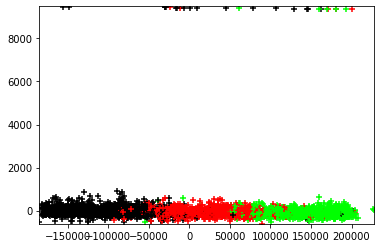

In [13]:
D_clus = DEC.predict(D_train, verbose=0)
D_clus = D_clus.argmax(1)
plot_cluster(D_train, D_clus, n_clusters)

# Baseline Linear

In [8]:
def BaseLinear():
    inp = Input(shape=(R_train.shape[-1], ), name='r_input')
    r = inp
    r = BatchNormalization()(r)
    
    ys = []
    for i in range(n_clusters):
        y = Dense(1, activation='linear', kernel_initializer='normal', name='branch_%d' % i) (r)
        ys.append(y)
        
    ys = Concatenate()(ys)
    
    return Model(inputs=inp, outputs=ys)


## Kmeans + Linear

In [9]:
def Baseloss(y_true, y_pred):
    y = K.repeat_elements(K.reshape(y_true[:, 0], (-1, 1)), rep=n_clusters, axis=1)
    t = y_true[:, 1:]
    
    yf = y_pred * t
    y = y * t
    
    return K.flatten(K.sum(K.square(y - yf), axis=1))


def train_base_linear(D_cls, D_cls_val):
    base_linear = BaseLinear()
    base_linear.compile(optimizer='Adam', loss=Baseloss)
    checkpointer = ModelCheckpoint(filepath='./model/BaseLinearCheckpoint', verbose=1, save_best_only=True)
    target = np.hstack([y_train.reshape(-1, 1), D_cls])
    target_val = np.hstack([y_test.reshape(-1, 1), D_cls_val])

    hist = base_linear.fit(R_train, target, validation_data=(R_test, target_val), batch_size=256, epochs=100, callbacks=[checkpointer])
    
    return base_linear, hist

In [10]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
D_clus = kmeans.fit_predict(D_train)
D_clus = np.eye(n_clusters)[D_clus]

D_clus_val = kmeans.predict(D_test)
D_clus_val = np.eye(n_clusters)[D_clus_val]


losses = []
vs = []

if fully_observed:
    full_losses = []
    weighted_full_losses = []
    accs = []
    
hists = {}
hists['val_loss_hist'] = []
hists['loss_hist'] = []
    
for i in range(40):
    baselinear, hist = train_base_linear(D_clus, D_clus_val)
    hists['val_loss_hist'].append(hist.history['val_loss'])
    hists['loss_hist'].append(hist.history['loss'])
    baselinear.load_weights('./model/BaseLinearCheckpoint')
    
    t = kmeans.predict(D_test)
    pred = baselinear.predict(R_test)
    vs.append(np.mean(np.var(pred, axis=0)))
    yf = pred[np.arange(len(t)), t]

    loss = np.mean(np.square(y_test - yf))
    losses.append(loss)
    
    if fully_observed:
        w = np.eye(n_clusters)[t]
        w = np.sum(w, axis=0) / len(t)
        diff = np.square(pred - y_full_test)
        weighted_full_loss = np.mean(np.sum(diff*w, axis=-1))
        weighted_full_losses.append(weighted_full_loss)
        full_loss = np.mean(diff)
        full_losses.append(full_loss)
        
        accs.append(AoDT(pred, y_full_test)) 









Train on 4014 samples, validate on 446 samples
Epoch 1/100





4014/4014 [==============================] - 2s 460us/step - loss: 2440565.2422 - val_loss: 2513462.8520

Epoch 00001: val_loss improved from inf to 2513462.85202, saving model to ./model/BaseLinearCheckpoint
Epoch 2/100
4014/4014 [==============================] - 0s 15us/step - loss: 2440386.1541 - val_loss: 2513266.5146

Epoch 00002: val_loss improved from 2513462.85202 to 2513266.51457, saving model to ./model/BaseLinearCheckpoint
Epoch 3/100
4014/4014 [==============================] - 0s 17us/step - loss: 2440175.2313 - val_loss: 2513041.1861

Epoch 00003: val_loss improved from 2513266.51457 to 2513041.18610, saving model to ./model/BaseLinearCheckpoint
Epoch 4/100
4014/4014 [==============================] - 0s 17us/step - loss: 2439946.2201 - val_loss: 2512771.4731

Epoch 00004: val_loss improved from 2513041.18610 to 2512771.47309, saving model to ./model/BaseLinearCheckpoint
Epoch 5/100
4014/4014 [======

Epoch 24/100
4014/4014 [==============================] - 0s 17us/step - loss: 2403201.1262 - val_loss: 2474345.6155

Epoch 00024: val_loss improved from 2478123.80045 to 2474345.61547, saving model to ./model/BaseLinearCheckpoint
Epoch 25/100
4014/4014 [==============================] - 0s 17us/step - loss: 2399198.3308 - val_loss: 2470384.3206

Epoch 00025: val_loss improved from 2474345.61547 to 2470384.32063, saving model to ./model/BaseLinearCheckpoint
Epoch 26/100
4014/4014 [==============================] - 0s 19us/step - loss: 2395171.7788 - val_loss: 2466221.1043

Epoch 00026: val_loss improved from 2470384.32063 to 2466221.10426, saving model to ./model/BaseLinearCheckpoint
Epoch 27/100
4014/4014 [==============================] - 0s 17us/step - loss: 2390878.6763 - val_loss: 2461870.4910

Epoch 00027: val_loss improved from 2466221.10426 to 2461870.49103, saving model to ./model/BaseLinearCheckpoint
Epoch 28/100
4014/4014 [==============================] - 0s 18us/step - los


Epoch 00059: val_loss improved from 2255840.26233 to 2247400.67937, saving model to ./model/BaseLinearCheckpoint
Epoch 60/100
4014/4014 [==============================] - 0s 19us/step - loss: 2168374.7119 - val_loss: 2238842.7175

Epoch 00060: val_loss improved from 2247400.67937 to 2238842.71749, saving model to ./model/BaseLinearCheckpoint
Epoch 61/100
4014/4014 [==============================] - 0s 18us/step - loss: 2159727.8509 - val_loss: 2230267.9271

Epoch 00061: val_loss improved from 2238842.71749 to 2230267.92713, saving model to ./model/BaseLinearCheckpoint
Epoch 62/100
4014/4014 [==============================] - 0s 18us/step - loss: 2151083.6931 - val_loss: 2221512.4294

Epoch 00062: val_loss improved from 2230267.92713 to 2221512.42937, saving model to ./model/BaseLinearCheckpoint
Epoch 63/100
4014/4014 [==============================] - 0s 17us/step - loss: 2142307.6525 - val_loss: 2212716.2422

Epoch 00063: val_loss improved from 2221512.42937 to 2212716.24215, saving 

4014/4014 [==============================] - 0s 18us/step - loss: 1832688.3056 - val_loss: 1904757.4479

Epoch 00095: val_loss improved from 1914846.15303 to 1904757.44787, saving model to ./model/BaseLinearCheckpoint
Epoch 96/100
4014/4014 [==============================] - 0s 18us/step - loss: 1822508.4060 - val_loss: 1894685.4703

Epoch 00096: val_loss improved from 1904757.44787 to 1894685.47029, saving model to ./model/BaseLinearCheckpoint
Epoch 97/100
4014/4014 [==============================] - 0s 17us/step - loss: 1811841.6687 - val_loss: 1884579.3952

Epoch 00097: val_loss improved from 1894685.47029 to 1884579.39518, saving model to ./model/BaseLinearCheckpoint
Epoch 98/100
4014/4014 [==============================] - 0s 17us/step - loss: 1801974.9514 - val_loss: 1874467.0605

Epoch 00098: val_loss improved from 1884579.39518 to 1874467.06054, saving model to ./model/BaseLinearCheckpoint
Epoch 99/100
4014/4014 [==============================] - 0s 18us/step - loss: 1791756.47


Epoch 00030: val_loss improved from 2453432.35426 to 2448658.94058, saving model to ./model/BaseLinearCheckpoint
Epoch 31/100
4014/4014 [==============================] - 0s 19us/step - loss: 2372166.2738 - val_loss: 2443670.8554

Epoch 00031: val_loss improved from 2448658.94058 to 2443670.85538, saving model to ./model/BaseLinearCheckpoint
Epoch 32/100
4014/4014 [==============================] - 0s 19us/step - loss: 2366969.3029 - val_loss: 2438506.5213

Epoch 00032: val_loss improved from 2443670.85538 to 2438506.52130, saving model to ./model/BaseLinearCheckpoint
Epoch 33/100
4014/4014 [==============================] - 0s 18us/step - loss: 2361718.6119 - val_loss: 2433200.1693

Epoch 00033: val_loss improved from 2438506.52130 to 2433200.16928, saving model to ./model/BaseLinearCheckpoint
Epoch 34/100
4014/4014 [==============================] - 0s 19us/step - loss: 2356329.3095 - val_loss: 2427715.8408

Epoch 00034: val_loss improved from 2433200.16928 to 2427715.84081, saving 

4014/4014 [==============================] - 0s 19us/step - loss: 2115764.3501 - val_loss: 2187828.2825

Epoch 00066: val_loss improved from 2196720.39238 to 2187828.28251, saving model to ./model/BaseLinearCheckpoint
Epoch 67/100
4014/4014 [==============================] - 0s 20us/step - loss: 2106876.0798 - val_loss: 2178745.5740

Epoch 00067: val_loss improved from 2187828.28251 to 2178745.57399, saving model to ./model/BaseLinearCheckpoint
Epoch 68/100
4014/4014 [==============================] - 0s 18us/step - loss: 2097504.6369 - val_loss: 2169595.0561

Epoch 00068: val_loss improved from 2178745.57399 to 2169595.05605, saving model to ./model/BaseLinearCheckpoint
Epoch 69/100
4014/4014 [==============================] - 0s 17us/step - loss: 2088386.0476 - val_loss: 2160403.5224

Epoch 00069: val_loss improved from 2169595.05605 to 2160403.52242, saving model to ./model/BaseLinearCheckpoint
Epoch 70/100
4014/4014 [==============================] - 0s 19us/step - loss: 2079063.41

4014/4014 [==============================] - 0s 19us/step - loss: 2339358.2968 - val_loss: 2411083.0348

Epoch 00037: val_loss improved from 2416983.32063 to 2411083.03475, saving model to ./model/BaseLinearCheckpoint
Epoch 38/100
4014/4014 [==============================] - 0s 18us/step - loss: 2333336.5782 - val_loss: 2405028.4675

Epoch 00038: val_loss improved from 2411083.03475 to 2405028.46749, saving model to ./model/BaseLinearCheckpoint
Epoch 39/100
4014/4014 [==============================] - 0s 18us/step - loss: 2327032.8717 - val_loss: 2398824.1323

Epoch 00039: val_loss improved from 2405028.46749 to 2398824.13229, saving model to ./model/BaseLinearCheckpoint
Epoch 40/100
4014/4014 [==============================] - 0s 18us/step - loss: 2320756.2318 - val_loss: 2392437.0056

Epoch 00040: val_loss improved from 2398824.13229 to 2392437.00561, saving model to ./model/BaseLinearCheckpoint
Epoch 41/100
4014/4014 [==============================] - 0s 20us/step - loss: 2314377.89

4014/4014 [==============================] - 0s 17us/step - loss: 2050858.9718 - val_loss: 2123382.2937

Epoch 00073: val_loss improved from 2132782.03643 to 2123382.29372, saving model to ./model/BaseLinearCheckpoint
Epoch 74/100
4014/4014 [==============================] - 0s 19us/step - loss: 2041062.0122 - val_loss: 2113989.5751

Epoch 00074: val_loss improved from 2123382.29372 to 2113989.57511, saving model to ./model/BaseLinearCheckpoint
Epoch 75/100
4014/4014 [==============================] - 0s 18us/step - loss: 2031748.4590 - val_loss: 2104429.1558

Epoch 00075: val_loss improved from 2113989.57511 to 2104429.15583, saving model to ./model/BaseLinearCheckpoint
Epoch 76/100
4014/4014 [==============================] - 0s 19us/step - loss: 2022197.9642 - val_loss: 2094915.7562

Epoch 00076: val_loss improved from 2104429.15583 to 2094915.75617, saving model to ./model/BaseLinearCheckpoint
Epoch 77/100
4014/4014 [==============================] - 0s 19us/step - loss: 2012688.57


Epoch 00008: val_loss improved from 2511306.67601 to 2510622.02915, saving model to ./model/BaseLinearCheckpoint
Epoch 9/100
4014/4014 [==============================] - 0s 18us/step - loss: 2437329.7358 - val_loss: 2509780.8184

Epoch 00009: val_loss improved from 2510622.02915 to 2509780.81839, saving model to ./model/BaseLinearCheckpoint
Epoch 10/100
4014/4014 [==============================] - 0s 18us/step - loss: 2436417.8896 - val_loss: 2508781.6547

Epoch 00010: val_loss improved from 2509780.81839 to 2508781.65471, saving model to ./model/BaseLinearCheckpoint
Epoch 11/100
4014/4014 [==============================] - 0s 18us/step - loss: 2435340.5110 - val_loss: 2507611.7646

Epoch 00011: val_loss improved from 2508781.65471 to 2507611.76457, saving model to ./model/BaseLinearCheckpoint
Epoch 12/100
4014/4014 [==============================] - 0s 21us/step - loss: 2434060.8399 - val_loss: 2506242.1805

Epoch 00012: val_loss improved from 2507611.76457 to 2506242.18049, saving m

4014/4014 [==============================] - 0s 20us/step - loss: 2292341.5518 - val_loss: 2362591.9137

Epoch 00044: val_loss improved from 2369432.95291 to 2362591.91368, saving model to ./model/BaseLinearCheckpoint
Epoch 45/100
4014/4014 [==============================] - 0s 20us/step - loss: 2285435.1891 - val_loss: 2355497.5650

Epoch 00045: val_loss improved from 2362591.91368 to 2355497.56502, saving model to ./model/BaseLinearCheckpoint
Epoch 46/100
4014/4014 [==============================] - 0s 18us/step - loss: 2278170.2096 - val_loss: 2348345.2578

Epoch 00046: val_loss improved from 2355497.56502 to 2348345.25785, saving model to ./model/BaseLinearCheckpoint
Epoch 47/100
4014/4014 [==============================] - 0s 17us/step - loss: 2270893.0278 - val_loss: 2341076.9114

Epoch 00047: val_loss improved from 2348345.25785 to 2341076.91143, saving model to ./model/BaseLinearCheckpoint
Epoch 48/100
4014/4014 [==============================] - 0s 20us/step - loss: 2263573.75

4014/4014 [==============================] - 0s 18us/step - loss: 1981069.3739 - val_loss: 2051765.2225

Epoch 00080: val_loss improved from 2061452.46020 to 2051765.22253, saving model to ./model/BaseLinearCheckpoint
Epoch 81/100
4014/4014 [==============================] - 0s 20us/step - loss: 1971490.1120 - val_loss: 2041927.1951

Epoch 00081: val_loss improved from 2051765.22253 to 2041927.19507, saving model to ./model/BaseLinearCheckpoint
Epoch 82/100
4014/4014 [==============================] - 0s 18us/step - loss: 1961379.3790 - val_loss: 2032043.3537

Epoch 00082: val_loss improved from 2041927.19507 to 2032043.35370, saving model to ./model/BaseLinearCheckpoint
Epoch 83/100
4014/4014 [==============================] - 0s 17us/step - loss: 1951416.3698 - val_loss: 2022186.8240

Epoch 00083: val_loss improved from 2032043.35370 to 2022186.82399, saving model to ./model/BaseLinearCheckpoint
Epoch 84/100
4014/4014 [==============================] - 0s 18us/step - loss: 1941941.46


Epoch 00015: val_loss improved from 2502829.89686 to 2500829.23991, saving model to ./model/BaseLinearCheckpoint
Epoch 16/100
4014/4014 [==============================] - 0s 18us/step - loss: 2427000.5861 - val_loss: 2498592.2590

Epoch 00016: val_loss improved from 2500829.23991 to 2498592.25897, saving model to ./model/BaseLinearCheckpoint
Epoch 17/100
4014/4014 [==============================] - 0s 19us/step - loss: 2424704.2415 - val_loss: 2496164.1816

Epoch 00017: val_loss improved from 2498592.25897 to 2496164.18161, saving model to ./model/BaseLinearCheckpoint
Epoch 18/100
4014/4014 [==============================] - 0s 19us/step - loss: 2422166.7019 - val_loss: 2493532.5392

Epoch 00018: val_loss improved from 2496164.18161 to 2493532.53924, saving model to ./model/BaseLinearCheckpoint
Epoch 19/100
4014/4014 [==============================] - 0s 19us/step - loss: 2419502.4357 - val_loss: 2490663.7960

Epoch 00019: val_loss improved from 2493532.53924 to 2490663.79596, saving 

4014/4014 [==============================] - 0s 18us/step - loss: 2241790.6231 - val_loss: 2310205.1132

Epoch 00051: val_loss improved from 2317926.52803 to 2310205.11323, saving model to ./model/BaseLinearCheckpoint
Epoch 52/100
4014/4014 [==============================] - 0s 19us/step - loss: 2234139.9179 - val_loss: 2302359.2825

Epoch 00052: val_loss improved from 2310205.11323 to 2302359.28251, saving model to ./model/BaseLinearCheckpoint
Epoch 53/100
4014/4014 [==============================] - 0s 18us/step - loss: 2226189.7790 - val_loss: 2294386.9350

Epoch 00053: val_loss improved from 2302359.28251 to 2294386.93498, saving model to ./model/BaseLinearCheckpoint
Epoch 54/100
4014/4014 [==============================] - 0s 18us/step - loss: 2218242.9827 - val_loss: 2286339.6379

Epoch 00054: val_loss improved from 2294386.93498 to 2286339.63789, saving model to ./model/BaseLinearCheckpoint
Epoch 55/100
4014/4014 [==============================] - 0s 18us/step - loss: 2210228.50

4014/4014 [==============================] - 0s 18us/step - loss: 1913342.3815 - val_loss: 1981064.1031

Epoch 00087: val_loss improved from 1991021.15191 to 1981064.10314, saving model to ./model/BaseLinearCheckpoint
Epoch 88/100
4014/4014 [==============================] - 0s 19us/step - loss: 1903309.0122 - val_loss: 1971063.9417

Epoch 00088: val_loss improved from 1981064.10314 to 1971063.94170, saving model to ./model/BaseLinearCheckpoint
Epoch 89/100
4014/4014 [==============================] - 0s 18us/step - loss: 1893167.0822 - val_loss: 1961023.0516

Epoch 00089: val_loss improved from 1971063.94170 to 1961023.05157, saving model to ./model/BaseLinearCheckpoint
Epoch 90/100
4014/4014 [==============================] - 0s 19us/step - loss: 1883271.2378 - val_loss: 1950978.3492

Epoch 00090: val_loss improved from 1961023.05157 to 1950978.34922, saving model to ./model/BaseLinearCheckpoint
Epoch 91/100
4014/4014 [==============================] - 0s 19us/step - loss: 1873065.37


Epoch 00022: val_loss improved from 2485174.20404 to 2481773.20628, saving model to ./model/BaseLinearCheckpoint
Epoch 23/100
4014/4014 [==============================] - 0s 20us/step - loss: 2406689.0964 - val_loss: 2478161.7410

Epoch 00023: val_loss improved from 2481773.20628 to 2478161.74103, saving model to ./model/BaseLinearCheckpoint
Epoch 24/100
4014/4014 [==============================] - 0s 18us/step - loss: 2402965.3931 - val_loss: 2474364.5493

Epoch 00024: val_loss improved from 2478161.74103 to 2474364.54933, saving model to ./model/BaseLinearCheckpoint
Epoch 25/100
4014/4014 [==============================] - 0s 20us/step - loss: 2399019.9486 - val_loss: 2470387.7388

Epoch 00025: val_loss improved from 2474364.54933 to 2470387.73879, saving model to ./model/BaseLinearCheckpoint
Epoch 26/100
4014/4014 [==============================] - 0s 18us/step - loss: 2394929.1435 - val_loss: 2466217.7108

Epoch 00026: val_loss improved from 2470387.73879 to 2466217.71076, saving 

4014/4014 [==============================] - 0s 19us/step - loss: 2184815.9841 - val_loss: 2255383.2814

Epoch 00058: val_loss improved from 2263834.09641 to 2255383.28139, saving model to ./model/BaseLinearCheckpoint
Epoch 59/100
4014/4014 [==============================] - 0s 20us/step - loss: 2176346.9109 - val_loss: 2246936.0617

Epoch 00059: val_loss improved from 2255383.28139 to 2246936.06166, saving model to ./model/BaseLinearCheckpoint
Epoch 60/100
4014/4014 [==============================] - 0s 19us/step - loss: 2167708.0681 - val_loss: 2238358.2220

Epoch 00060: val_loss improved from 2246936.06166 to 2238358.22197, saving model to ./model/BaseLinearCheckpoint
Epoch 61/100
4014/4014 [==============================] - 0s 19us/step - loss: 2158949.5732 - val_loss: 2229755.1099

Epoch 00061: val_loss improved from 2238358.22197 to 2229755.10987, saving model to ./model/BaseLinearCheckpoint
Epoch 62/100
4014/4014 [==============================] - 0s 18us/step - loss: 2150156.54

4014/4014 [==============================] - 0s 19us/step - loss: 1841652.5534 - val_loss: 1914047.7276

Epoch 00094: val_loss improved from 1924071.24888 to 1914047.72758, saving model to ./model/BaseLinearCheckpoint
Epoch 95/100
4014/4014 [==============================] - 0s 20us/step - loss: 1831497.0471 - val_loss: 1903950.9350

Epoch 00095: val_loss improved from 1914047.72758 to 1903950.93498, saving model to ./model/BaseLinearCheckpoint
Epoch 96/100
4014/4014 [==============================] - 0s 19us/step - loss: 1821411.8016 - val_loss: 1893815.6071

Epoch 00096: val_loss improved from 1903950.93498 to 1893815.60706, saving model to ./model/BaseLinearCheckpoint
Epoch 97/100
4014/4014 [==============================] - 0s 20us/step - loss: 1811464.2574 - val_loss: 1883703.6760

Epoch 00097: val_loss improved from 1893815.60706 to 1883703.67601, saving model to ./model/BaseLinearCheckpoint
Epoch 98/100
4014/4014 [==============================] - 0s 19us/step - loss: 1800965.25


Epoch 00029: val_loss improved from 2455240.25673 to 2450501.78363, saving model to ./model/BaseLinearCheckpoint
Epoch 30/100
4014/4014 [==============================] - 0s 19us/step - loss: 2375242.7512 - val_loss: 2445618.7646

Epoch 00030: val_loss improved from 2450501.78363 to 2445618.76457, saving model to ./model/BaseLinearCheckpoint
Epoch 31/100
4014/4014 [==============================] - 0s 20us/step - loss: 2370303.7854 - val_loss: 2440536.1031

Epoch 00031: val_loss improved from 2445618.76457 to 2440536.10314, saving model to ./model/BaseLinearCheckpoint
Epoch 32/100
4014/4014 [==============================] - 0s 18us/step - loss: 2365123.1934 - val_loss: 2435294.8027

Epoch 00032: val_loss improved from 2440536.10314 to 2435294.80269, saving model to ./model/BaseLinearCheckpoint
Epoch 33/100
4014/4014 [==============================] - 0s 19us/step - loss: 2359758.7673 - val_loss: 2429905.7063

Epoch 00033: val_loss improved from 2435294.80269 to 2429905.70628, saving 

4014/4014 [==============================] - 0s 20us/step - loss: 2122694.5102 - val_loss: 2191421.3195

Epoch 00065: val_loss improved from 2200341.11435 to 2191421.31951, saving model to ./model/BaseLinearCheckpoint
Epoch 66/100
4014/4014 [==============================] - 0s 19us/step - loss: 2113445.0962 - val_loss: 2182326.1704

Epoch 00066: val_loss improved from 2191421.31951 to 2182326.17040, saving model to ./model/BaseLinearCheckpoint
Epoch 67/100
4014/4014 [==============================] - 0s 19us/step - loss: 2104271.1561 - val_loss: 2173260.1592

Epoch 00067: val_loss improved from 2182326.17040 to 2173260.15919, saving model to ./model/BaseLinearCheckpoint
Epoch 68/100
4014/4014 [==============================] - 0s 19us/step - loss: 2095331.9280 - val_loss: 2164152.5426

Epoch 00068: val_loss improved from 2173260.15919 to 2164152.54260, saving model to ./model/BaseLinearCheckpoint
Epoch 69/100
4014/4014 [==============================] - 0s 19us/step - loss: 2086158.78

Train on 4014 samples, validate on 446 samples
Epoch 1/100
4014/4014 [==============================] - 1s 197us/step - loss: 2440503.7049 - val_loss: 2513307.9383

Epoch 00001: val_loss improved from inf to 2513307.93834, saving model to ./model/BaseLinearCheckpoint
Epoch 2/100
4014/4014 [==============================] - 0s 19us/step - loss: 2440311.0219 - val_loss: 2513098.9047

Epoch 00002: val_loss improved from 2513307.93834 to 2513098.90471, saving model to ./model/BaseLinearCheckpoint
Epoch 3/100
4014/4014 [==============================] - 0s 20us/step - loss: 2440085.5496 - val_loss: 2512850.8016

Epoch 00003: val_loss improved from 2513098.90471 to 2512850.80157, saving model to ./model/BaseLinearCheckpoint
Epoch 4/100
4014/4014 [==============================] - 0s 18us/step - loss: 2439815.3947 - val_loss: 2512553.1379

Epoch 00004: val_loss improved from 2512850.80157 to 2512553.13789, saving model to ./model/BaseLinearCheckpoint
Epoch 5/100
4014/4014 [===================

4014/4014 [==============================] - 0s 19us/step - loss: 2058711.2920 - val_loss: 2127665.0981

Epoch 00072: val_loss improved from 2137082.81670 to 2127665.09809, saving model to ./model/BaseLinearCheckpoint
Epoch 73/100
4014/4014 [==============================] - 0s 20us/step - loss: 2049262.9639 - val_loss: 2118194.2954

Epoch 00073: val_loss improved from 2127665.09809 to 2118194.29540, saving model to ./model/BaseLinearCheckpoint
Epoch 74/100
4014/4014 [==============================] - 0s 20us/step - loss: 2039584.6599 - val_loss: 2108750.1867

Epoch 00074: val_loss improved from 2118194.29540 to 2108750.18666, saving model to ./model/BaseLinearCheckpoint
Epoch 75/100
4014/4014 [==============================] - 0s 19us/step - loss: 2030230.0333 - val_loss: 2099143.7713

Epoch 00075: val_loss improved from 2108750.18666 to 2099143.77130, saving model to ./model/BaseLinearCheckpoint
Epoch 76/100
4014/4014 [==============================] - 0s 20us/step - loss: 2020529.53


Epoch 00007: val_loss improved from 2511814.49664 to 2511237.64686, saving model to ./model/BaseLinearCheckpoint
Epoch 8/100
4014/4014 [==============================] - 0s 19us/step - loss: 2438058.3910 - val_loss: 2510525.7511

Epoch 00008: val_loss improved from 2511237.64686 to 2510525.75112, saving model to ./model/BaseLinearCheckpoint
Epoch 9/100
4014/4014 [==============================] - 0s 19us/step - loss: 2437298.5538 - val_loss: 2509669.5179

Epoch 00009: val_loss improved from 2510525.75112 to 2509669.51794, saving model to ./model/BaseLinearCheckpoint
Epoch 10/100
4014/4014 [==============================] - 0s 20us/step - loss: 2436379.7202 - val_loss: 2508641.9843

Epoch 00010: val_loss improved from 2509669.51794 to 2508641.98430, saving model to ./model/BaseLinearCheckpoint
Epoch 11/100
4014/4014 [==============================] - 0s 19us/step - loss: 2435288.3924 - val_loss: 2507429.2466

Epoch 00011: val_loss improved from 2508641.98430 to 2507429.24664, saving mo

4014/4014 [==============================] - 0s 19us/step - loss: 2299418.0097 - val_loss: 2368544.7859

Epoch 00043: val_loss improved from 2375350.42825 to 2368544.78587, saving model to ./model/BaseLinearCheckpoint
Epoch 44/100
4014/4014 [==============================] - 0s 19us/step - loss: 2292520.2623 - val_loss: 2361614.8217

Epoch 00044: val_loss improved from 2368544.78587 to 2361614.82175, saving model to ./model/BaseLinearCheckpoint
Epoch 45/100
4014/4014 [==============================] - 0s 20us/step - loss: 2285625.6328 - val_loss: 2354563.5561

Epoch 00045: val_loss improved from 2361614.82175 to 2354563.55605, saving model to ./model/BaseLinearCheckpoint
Epoch 46/100
4014/4014 [==============================] - 0s 20us/step - loss: 2278307.5877 - val_loss: 2347427.3924

Epoch 00046: val_loss improved from 2354563.55605 to 2347427.39238, saving model to ./model/BaseLinearCheckpoint
Epoch 47/100
4014/4014 [==============================] - 0s 19us/step - loss: 2271258.63

4014/4014 [==============================] - 0s 20us/step - loss: 1991416.6172 - val_loss: 2059944.4865

Epoch 00079: val_loss improved from 2069759.75953 to 2059944.48655, saving model to ./model/BaseLinearCheckpoint
Epoch 80/100
4014/4014 [==============================] - 0s 19us/step - loss: 1981435.9502 - val_loss: 2050284.7971

Epoch 00080: val_loss improved from 2059944.48655 to 2050284.79709, saving model to ./model/BaseLinearCheckpoint
Epoch 81/100
4014/4014 [==============================] - 0s 18us/step - loss: 1971712.2077 - val_loss: 2040438.3974

Epoch 00081: val_loss improved from 2050284.79709 to 2040438.39742, saving model to ./model/BaseLinearCheckpoint
Epoch 82/100
4014/4014 [==============================] - 0s 21us/step - loss: 1961654.2166 - val_loss: 2030652.0706

Epoch 00082: val_loss improved from 2040438.39742 to 2030652.07063, saving model to ./model/BaseLinearCheckpoint
Epoch 83/100
4014/4014 [==============================] - 0s 19us/step - loss: 1951964.95


Epoch 00014: val_loss improved from 2505030.43834 to 2503257.59305, saving model to ./model/BaseLinearCheckpoint
Epoch 15/100
4014/4014 [==============================] - 0s 19us/step - loss: 2429245.0166 - val_loss: 2501268.5168

Epoch 00015: val_loss improved from 2503257.59305 to 2501268.51682, saving model to ./model/BaseLinearCheckpoint
Epoch 16/100
4014/4014 [==============================] - 0s 19us/step - loss: 2427104.6780 - val_loss: 2499053.9787

Epoch 00016: val_loss improved from 2501268.51682 to 2499053.97870, saving model to ./model/BaseLinearCheckpoint
Epoch 17/100
4014/4014 [==============================] - 0s 21us/step - loss: 2424762.1477 - val_loss: 2496627.0987

Epoch 00017: val_loss improved from 2499053.97870 to 2496627.09865, saving model to ./model/BaseLinearCheckpoint
Epoch 18/100
4014/4014 [==============================] - 0s 19us/step - loss: 2422228.6918 - val_loss: 2493990.8576

Epoch 00018: val_loss improved from 2496627.09865 to 2493990.85762, saving 

4014/4014 [==============================] - 0s 20us/step - loss: 2248652.4412 - val_loss: 2318777.9686

Epoch 00050: val_loss improved from 2326430.30717 to 2318777.96861, saving model to ./model/BaseLinearCheckpoint
Epoch 51/100
4014/4014 [==============================] - 0s 20us/step - loss: 2240981.3989 - val_loss: 2311080.0605

Epoch 00051: val_loss improved from 2318777.96861 to 2311080.06054, saving model to ./model/BaseLinearCheckpoint
Epoch 52/100
4014/4014 [==============================] - 0s 19us/step - loss: 2233000.1320 - val_loss: 2303258.5034

Epoch 00052: val_loss improved from 2311080.06054 to 2303258.50336, saving model to ./model/BaseLinearCheckpoint
Epoch 53/100
4014/4014 [==============================] - 0s 21us/step - loss: 2225331.2565 - val_loss: 2295277.6323

Epoch 00053: val_loss improved from 2303258.50336 to 2295277.63229, saving model to ./model/BaseLinearCheckpoint
Epoch 54/100
4014/4014 [==============================] - 0s 19us/step - loss: 2217184.44

4014/4014 [==============================] - 0s 20us/step - loss: 1921463.9145 - val_loss: 1992549.5174

Epoch 00086: val_loss improved from 2002521.69002 to 1992549.51738, saving model to ./model/BaseLinearCheckpoint
Epoch 87/100
4014/4014 [==============================] - 0s 19us/step - loss: 1911852.6580 - val_loss: 1982584.0387

Epoch 00087: val_loss improved from 1992549.51738 to 1982584.03868, saving model to ./model/BaseLinearCheckpoint
Epoch 88/100
4014/4014 [==============================] - 0s 19us/step - loss: 1901554.5645 - val_loss: 1972573.7500

Epoch 00088: val_loss improved from 1982584.03868 to 1972573.75000, saving model to ./model/BaseLinearCheckpoint
Epoch 89/100
4014/4014 [==============================] - 0s 20us/step - loss: 1891746.5356 - val_loss: 1962599.0549

Epoch 00089: val_loss improved from 1972573.75000 to 1962599.05493, saving model to ./model/BaseLinearCheckpoint
Epoch 90/100
4014/4014 [==============================] - 0s 20us/step - loss: 1881660.45


Epoch 00021: val_loss improved from 2488229.46076 to 2484966.14126, saving model to ./model/BaseLinearCheckpoint
Epoch 22/100
4014/4014 [==============================] - 0s 20us/step - loss: 2410303.6934 - val_loss: 2481533.2433

Epoch 00022: val_loss improved from 2484966.14126 to 2481533.24327, saving model to ./model/BaseLinearCheckpoint
Epoch 23/100
4014/4014 [==============================] - 0s 20us/step - loss: 2406786.9074 - val_loss: 2477898.0359

Epoch 00023: val_loss improved from 2481533.24327 to 2477898.03587, saving model to ./model/BaseLinearCheckpoint
Epoch 24/100
4014/4014 [==============================] - 0s 19us/step - loss: 2403094.2638 - val_loss: 2474056.7735

Epoch 00024: val_loss improved from 2477898.03587 to 2474056.77354, saving model to ./model/BaseLinearCheckpoint
Epoch 25/100
4014/4014 [==============================] - 0s 20us/step - loss: 2399175.0020 - val_loss: 2470045.0392

Epoch 00025: val_loss improved from 2474056.77354 to 2470045.03924, saving 

4014/4014 [==============================] - 0s 20us/step - loss: 2193537.5462 - val_loss: 2262780.9865

Epoch 00057: val_loss improved from 2271131.51233 to 2262780.98655, saving model to ./model/BaseLinearCheckpoint
Epoch 58/100
4014/4014 [==============================] - 0s 20us/step - loss: 2185051.5595 - val_loss: 2254430.8778

Epoch 00058: val_loss improved from 2262780.98655 to 2254430.87780, saving model to ./model/BaseLinearCheckpoint
Epoch 59/100
4014/4014 [==============================] - 0s 19us/step - loss: 2176771.2461 - val_loss: 2245939.5796

Epoch 00059: val_loss improved from 2254430.87780 to 2245939.57960, saving model to ./model/BaseLinearCheckpoint
Epoch 60/100
4014/4014 [==============================] - 0s 19us/step - loss: 2168181.6060 - val_loss: 2237365.6244

Epoch 00060: val_loss improved from 2245939.57960 to 2237365.62444, saving model to ./model/BaseLinearCheckpoint
Epoch 61/100
4014/4014 [==============================] - 0s 20us/step - loss: 2159484.18

4014/4014 [==============================] - 0s 19us/step - loss: 1852899.4824 - val_loss: 1922501.6530

Epoch 00093: val_loss improved from 1932505.32960 to 1922501.65303, saving model to ./model/BaseLinearCheckpoint
Epoch 94/100
4014/4014 [==============================] - 0s 20us/step - loss: 1842602.6374 - val_loss: 1912478.2186

Epoch 00094: val_loss improved from 1922501.65303 to 1912478.21861, saving model to ./model/BaseLinearCheckpoint
Epoch 95/100
4014/4014 [==============================] - 0s 20us/step - loss: 1831951.4727 - val_loss: 1902216.7758

Epoch 00095: val_loss improved from 1912478.21861 to 1902216.77578, saving model to ./model/BaseLinearCheckpoint
Epoch 96/100
4014/4014 [==============================] - 0s 20us/step - loss: 1821814.4175 - val_loss: 1892094.7164

Epoch 00096: val_loss improved from 1902216.77578 to 1892094.71637, saving model to ./model/BaseLinearCheckpoint
Epoch 97/100
4014/4014 [==============================] - 0s 20us/step - loss: 1811516.01


Epoch 00028: val_loss improved from 2459455.44507 to 2454804.36996, saving model to ./model/BaseLinearCheckpoint
Epoch 29/100
4014/4014 [==============================] - 0s 19us/step - loss: 2380792.3254 - val_loss: 2449974.3094

Epoch 00029: val_loss improved from 2454804.36996 to 2449974.30942, saving model to ./model/BaseLinearCheckpoint
Epoch 30/100
4014/4014 [==============================] - 0s 20us/step - loss: 2375894.4281 - val_loss: 2445005.1850

Epoch 00030: val_loss improved from 2449974.30942 to 2445005.18498, saving model to ./model/BaseLinearCheckpoint
Epoch 31/100
4014/4014 [==============================] - 0s 20us/step - loss: 2370921.3708 - val_loss: 2439833.9585

Epoch 00031: val_loss improved from 2445005.18498 to 2439833.95852, saving model to ./model/BaseLinearCheckpoint
Epoch 32/100
4014/4014 [==============================] - 0s 20us/step - loss: 2365691.3934 - val_loss: 2434553.5852

Epoch 00032: val_loss improved from 2439833.95852 to 2434553.58520, saving 

4014/4014 [==============================] - 0s 20us/step - loss: 2131488.5864 - val_loss: 2197616.8061

Epoch 00064: val_loss improved from 2206591.32848 to 2197616.80605, saving model to ./model/BaseLinearCheckpoint
Epoch 65/100
4014/4014 [==============================] - 0s 19us/step - loss: 2122562.5022 - val_loss: 2188626.3531

Epoch 00065: val_loss improved from 2197616.80605 to 2188626.35314, saving model to ./model/BaseLinearCheckpoint
Epoch 66/100
4014/4014 [==============================] - 0s 19us/step - loss: 2113503.8012 - val_loss: 2179587.7332

Epoch 00066: val_loss improved from 2188626.35314 to 2179587.73318, saving model to ./model/BaseLinearCheckpoint
Epoch 67/100
4014/4014 [==============================] - 0s 19us/step - loss: 2104253.1066 - val_loss: 2170434.2433

Epoch 00067: val_loss improved from 2179587.73318 to 2170434.24327, saving model to ./model/BaseLinearCheckpoint
Epoch 68/100
4014/4014 [==============================] - 0s 21us/step - loss: 2095129.85

4014/4014 [==============================] - 0s 21us/step - loss: 1780045.0919 - val_loss: 1846264.2590

Epoch 00100: val_loss improved from 1856414.97702 to 1846264.25897, saving model to ./model/BaseLinearCheckpoint
Train on 4014 samples, validate on 446 samples
Epoch 1/100
4014/4014 [==============================] - 1s 273us/step - loss: 2440695.7441 - val_loss: 2513437.1435

Epoch 00001: val_loss improved from inf to 2513437.14350, saving model to ./model/BaseLinearCheckpoint
Epoch 2/100
4014/4014 [==============================] - 0s 20us/step - loss: 2440515.7121 - val_loss: 2513243.6760

Epoch 00002: val_loss improved from 2513437.14350 to 2513243.67601, saving model to ./model/BaseLinearCheckpoint
Epoch 3/100
4014/4014 [==============================] - 0s 19us/step - loss: 2440316.8905 - val_loss: 2513025.7556

Epoch 00003: val_loss improved from 2513243.67601 to 2513025.75561, saving model to ./model/BaseLinearCheckpoint
Epoch 4/100
4014/4014 [==============================]


Epoch 00035: val_loss improved from 2425888.27018 to 2420182.64238, saving model to ./model/BaseLinearCheckpoint
Epoch 36/100
4014/4014 [==============================] - 0s 21us/step - loss: 2345002.3363 - val_loss: 2414325.5291

Epoch 00036: val_loss improved from 2420182.64238 to 2414325.52915, saving model to ./model/BaseLinearCheckpoint
Epoch 37/100
4014/4014 [==============================] - 0s 19us/step - loss: 2339006.6095 - val_loss: 2408355.5493

Epoch 00037: val_loss improved from 2414325.52915 to 2408355.54933, saving model to ./model/BaseLinearCheckpoint
Epoch 38/100
4014/4014 [==============================] - 0s 19us/step - loss: 2332937.6888 - val_loss: 2402187.0067

Epoch 00038: val_loss improved from 2408355.54933 to 2402187.00673, saving model to ./model/BaseLinearCheckpoint
Epoch 39/100
4014/4014 [==============================] - 0s 20us/step - loss: 2326709.0173 - val_loss: 2395927.2657

Epoch 00039: val_loss improved from 2402187.00673 to 2395927.26570, saving 

4014/4014 [==============================] - 0s 21us/step - loss: 2068958.6312 - val_loss: 2137393.7909

Epoch 00071: val_loss improved from 2146758.76906 to 2137393.79092, saving model to ./model/BaseLinearCheckpoint
Epoch 72/100
4014/4014 [==============================] - 0s 20us/step - loss: 2059400.2189 - val_loss: 2127979.6911

Epoch 00072: val_loss improved from 2137393.79092 to 2127979.69114, saving model to ./model/BaseLinearCheckpoint
Epoch 73/100
4014/4014 [==============================] - 0s 20us/step - loss: 2049903.5958 - val_loss: 2118548.6463

Epoch 00073: val_loss improved from 2127979.69114 to 2118548.64630, saving model to ./model/BaseLinearCheckpoint
Epoch 74/100
4014/4014 [==============================] - 0s 19us/step - loss: 2040541.0152 - val_loss: 2109093.8279

Epoch 00074: val_loss improved from 2118548.64630 to 2109093.82791, saving model to ./model/BaseLinearCheckpoint
Epoch 75/100
4014/4014 [==============================] - 0s 20us/step - loss: 2030713.05


Epoch 00006: val_loss improved from 2512225.80269 to 2511750.42152, saving model to ./model/BaseLinearCheckpoint
Epoch 7/100
4014/4014 [==============================] - 0s 20us/step - loss: 2438717.7923 - val_loss: 2511146.0493

Epoch 00007: val_loss improved from 2511750.42152 to 2511146.04933, saving model to ./model/BaseLinearCheckpoint
Epoch 8/100
4014/4014 [==============================] - 0s 20us/step - loss: 2438079.3594 - val_loss: 2510411.6166

Epoch 00008: val_loss improved from 2511146.04933 to 2510411.61659, saving model to ./model/BaseLinearCheckpoint
Epoch 9/100
4014/4014 [==============================] - 0s 21us/step - loss: 2437310.2869 - val_loss: 2509513.8969

Epoch 00009: val_loss improved from 2510411.61659 to 2509513.89686, saving model to ./model/BaseLinearCheckpoint
Epoch 10/100
4014/4014 [==============================] - 0s 20us/step - loss: 2436377.6160 - val_loss: 2508442.0796

Epoch 00010: val_loss improved from 2509513.89686 to 2508442.07960, saving mod

4014/4014 [==============================] - 0s 20us/step - loss: 2306196.7098 - val_loss: 2373606.0280

Epoch 00042: val_loss improved from 2380362.93386 to 2373606.02803, saving model to ./model/BaseLinearCheckpoint
Epoch 43/100
4014/4014 [==============================] - 0s 20us/step - loss: 2299356.4273 - val_loss: 2366790.4081

Epoch 00043: val_loss improved from 2373606.02803 to 2366790.40807, saving model to ./model/BaseLinearCheckpoint
Epoch 44/100
4014/4014 [==============================] - 0s 19us/step - loss: 2292478.0734 - val_loss: 2359773.6794

Epoch 00044: val_loss improved from 2366790.40807 to 2359773.67937, saving model to ./model/BaseLinearCheckpoint
Epoch 45/100
4014/4014 [==============================] - 0s 20us/step - loss: 2285424.5029 - val_loss: 2352726.8195

Epoch 00045: val_loss improved from 2359773.67937 to 2352726.81951, saving model to ./model/BaseLinearCheckpoint
Epoch 46/100
4014/4014 [==============================] - 0s 20us/step - loss: 2278427.93

4014/4014 [==============================] - 0s 20us/step - loss: 2001249.2731 - val_loss: 2066703.8672

Epoch 00078: val_loss improved from 2076441.45011 to 2066703.86715, saving model to ./model/BaseLinearCheckpoint
Epoch 79/100
4014/4014 [==============================] - 0s 22us/step - loss: 1991459.7626 - val_loss: 2056880.3716

Epoch 00079: val_loss improved from 2066703.86715 to 2056880.37164, saving model to ./model/BaseLinearCheckpoint
Epoch 80/100
4014/4014 [==============================] - 0s 20us/step - loss: 1981734.0992 - val_loss: 2047074.0998

Epoch 00080: val_loss improved from 2056880.37164 to 2047074.09978, saving model to ./model/BaseLinearCheckpoint
Epoch 81/100
4014/4014 [==============================] - 0s 23us/step - loss: 1971506.7889 - val_loss: 2037210.1973

Epoch 00081: val_loss improved from 2047074.09978 to 2037210.19731, saving model to ./model/BaseLinearCheckpoint
Epoch 82/100
4014/4014 [==============================] - 0s 21us/step - loss: 1961952.75


Epoch 00013: val_loss improved from 2506661.78700 to 2505136.18049, saving model to ./model/BaseLinearCheckpoint
Epoch 14/100
4014/4014 [==============================] - 0s 21us/step - loss: 2431343.2846 - val_loss: 2503416.6345

Epoch 00014: val_loss improved from 2505136.18049 to 2503416.63453, saving model to ./model/BaseLinearCheckpoint
Epoch 15/100
4014/4014 [==============================] - 0s 19us/step - loss: 2429510.4680 - val_loss: 2501491.0661

Epoch 00015: val_loss improved from 2503416.63453 to 2501491.06614, saving model to ./model/BaseLinearCheckpoint
Epoch 16/100
4014/4014 [==============================] - 0s 20us/step - loss: 2427460.7598 - val_loss: 2499343.0258

Epoch 00016: val_loss improved from 2501491.06614 to 2499343.02578, saving model to ./model/BaseLinearCheckpoint
Epoch 17/100
4014/4014 [==============================] - 0s 21us/step - loss: 2425216.8743 - val_loss: 2497003.3834

Epoch 00017: val_loss improved from 2499343.02578 to 2497003.38341, saving 

4014/4014 [==============================] - 0s 21us/step - loss: 2257862.3247 - val_loss: 2328044.0796

Epoch 00049: val_loss improved from 2335549.13341 to 2328044.07960, saving model to ./model/BaseLinearCheckpoint
Epoch 50/100
4014/4014 [==============================] - 0s 21us/step - loss: 2250306.0882 - val_loss: 2320480.0392

Epoch 00050: val_loss improved from 2328044.07960 to 2320480.03924, saving model to ./model/BaseLinearCheckpoint
Epoch 51/100
4014/4014 [==============================] - 0s 20us/step - loss: 2242561.9697 - val_loss: 2312760.1424

Epoch 00051: val_loss improved from 2320480.03924 to 2312760.14238, saving model to ./model/BaseLinearCheckpoint
Epoch 52/100
4014/4014 [==============================] - 0s 22us/step - loss: 2234753.8027 - val_loss: 2304949.6693

Epoch 00052: val_loss improved from 2312760.14238 to 2304949.66928, saving model to ./model/BaseLinearCheckpoint
Epoch 53/100
4014/4014 [==============================] - 0s 20us/step - loss: 2226986.34

Epoch 85/100
4014/4014 [==============================] - 0s 21us/step - loss: 1933711.0261 - val_loss: 2004522.2511

Epoch 00085: val_loss improved from 2014433.28083 to 2004522.25112, saving model to ./model/BaseLinearCheckpoint
Epoch 86/100
4014/4014 [==============================] - 0s 21us/step - loss: 1923606.0141 - val_loss: 1994693.3083

Epoch 00086: val_loss improved from 2004522.25112 to 1994693.30830, saving model to ./model/BaseLinearCheckpoint
Epoch 87/100
4014/4014 [==============================] - 0s 20us/step - loss: 1913614.0118 - val_loss: 1984691.3683

Epoch 00087: val_loss improved from 1994693.30830 to 1984691.36827, saving model to ./model/BaseLinearCheckpoint
Epoch 88/100
4014/4014 [==============================] - 0s 21us/step - loss: 1903539.2427 - val_loss: 1974617.4176

Epoch 00088: val_loss improved from 1984691.36827 to 1974617.41760, saving model to ./model/BaseLinearCheckpoint
Epoch 89/100
4014/4014 [==============================] - 0s 20us/step - los

Epoch 56/100
4014/4014 [==============================] - 0s 21us/step - loss: 2201625.7105 - val_loss: 2270397.0975

Epoch 00056: val_loss improved from 2278709.92265 to 2270397.09753, saving model to ./model/BaseLinearCheckpoint
Epoch 57/100
4014/4014 [==============================] - 0s 19us/step - loss: 2193298.2701 - val_loss: 2262079.1043

Epoch 00057: val_loss improved from 2270397.09753 to 2262079.10426, saving model to ./model/BaseLinearCheckpoint
Epoch 58/100
4014/4014 [==============================] - 0s 20us/step - loss: 2185069.0955 - val_loss: 2253701.4361

Epoch 00058: val_loss improved from 2262079.10426 to 2253701.43610, saving model to ./model/BaseLinearCheckpoint
Epoch 59/100
4014/4014 [==============================] - 0s 20us/step - loss: 2176433.0933 - val_loss: 2245177.9350

Epoch 00059: val_loss improved from 2253701.43610 to 2245177.93498, saving model to ./model/BaseLinearCheckpoint
Epoch 60/100
4014/4014 [==============================] - 0s 20us/step - los


Epoch 00091: val_loss improved from 1951460.39462 to 1941339.14238, saving model to ./model/BaseLinearCheckpoint
Epoch 92/100
4014/4014 [==============================] - 0s 20us/step - loss: 1862258.8554 - val_loss: 1931341.2197

Epoch 00092: val_loss improved from 1941339.14238 to 1931341.21973, saving model to ./model/BaseLinearCheckpoint
Epoch 93/100
4014/4014 [==============================] - 0s 23us/step - loss: 1852028.2120 - val_loss: 1921180.2702

Epoch 00093: val_loss improved from 1931341.21973 to 1921180.27018, saving model to ./model/BaseLinearCheckpoint
Epoch 94/100
4014/4014 [==============================] - 0s 21us/step - loss: 1841839.2248 - val_loss: 1911148.9389

Epoch 00094: val_loss improved from 1921180.27018 to 1911148.93890, saving model to ./model/BaseLinearCheckpoint
Epoch 95/100
4014/4014 [==============================] - 0s 20us/step - loss: 1832006.9608 - val_loss: 1900938.9826

Epoch 00095: val_loss improved from 1911148.93890 to 1900938.98262, saving 

Epoch 27/100
4014/4014 [==============================] - 0s 21us/step - loss: 2391020.5274 - val_loss: 2462258.2444

Epoch 00027: val_loss improved from 2466591.49215 to 2462258.24439, saving model to ./model/BaseLinearCheckpoint
Epoch 28/100
4014/4014 [==============================] - 0s 19us/step - loss: 2386606.5950 - val_loss: 2457777.9552

Epoch 00028: val_loss improved from 2462258.24439 to 2457777.95516, saving model to ./model/BaseLinearCheckpoint
Epoch 29/100
4014/4014 [==============================] - 0s 21us/step - loss: 2382006.3041 - val_loss: 2453114.9215

Epoch 00029: val_loss improved from 2457777.95516 to 2453114.92152, saving model to ./model/BaseLinearCheckpoint
Epoch 30/100
4014/4014 [==============================] - 0s 20us/step - loss: 2377216.5930 - val_loss: 2448263.6614

Epoch 00030: val_loss improved from 2453114.92152 to 2448263.66143, saving model to ./model/BaseLinearCheckpoint
Epoch 31/100
4014/4014 [==============================] - 0s 20us/step - los


Epoch 00062: val_loss improved from 2230520.45179 to 2221754.54933, saving model to ./model/BaseLinearCheckpoint
Epoch 63/100
4014/4014 [==============================] - 0s 19us/step - loss: 2142718.3723 - val_loss: 2213010.4462

Epoch 00063: val_loss improved from 2221754.54933 to 2213010.44619, saving model to ./model/BaseLinearCheckpoint
Epoch 64/100
4014/4014 [==============================] - 0s 20us/step - loss: 2133782.6077 - val_loss: 2204136.9910

Epoch 00064: val_loss improved from 2213010.44619 to 2204136.99103, saving model to ./model/BaseLinearCheckpoint
Epoch 65/100
4014/4014 [==============================] - 0s 22us/step - loss: 2124739.4483 - val_loss: 2195196.4496

Epoch 00065: val_loss improved from 2204136.99103 to 2195196.44955, saving model to ./model/BaseLinearCheckpoint
Epoch 66/100
4014/4014 [==============================] - 0s 21us/step - loss: 2115724.2370 - val_loss: 2186185.2545

Epoch 00066: val_loss improved from 2195196.44955 to 2186185.25448, saving 

4014/4014 [==============================] - 0s 23us/step - loss: 1802455.5568 - val_loss: 1873872.7371

Epoch 00098: val_loss improved from 1883992.46020 to 1873872.73711, saving model to ./model/BaseLinearCheckpoint
Epoch 99/100
4014/4014 [==============================] - 0s 20us/step - loss: 1792222.3509 - val_loss: 1863745.6508

Epoch 00099: val_loss improved from 1873872.73711 to 1863745.65078, saving model to ./model/BaseLinearCheckpoint
Epoch 100/100
4014/4014 [==============================] - 0s 19us/step - loss: 1781560.7869 - val_loss: 1853562.0342

Epoch 00100: val_loss improved from 1863745.65078 to 1853562.03419, saving model to ./model/BaseLinearCheckpoint
Train on 4014 samples, validate on 446 samples
Epoch 1/100
4014/4014 [==============================] - 1s 348us/step - loss: 2440543.7071 - val_loss: 2513348.4103

Epoch 00001: val_loss improved from inf to 2513348.41031, saving model to ./model/BaseLinearCheckpoint
Epoch 2/100
4014/4014 [============================


Epoch 00033: val_loss improved from 2437086.81951 to 2431710.85090, saving model to ./model/BaseLinearCheckpoint
Epoch 34/100
4014/4014 [==============================] - 0s 20us/step - loss: 2357052.3226 - val_loss: 2426143.3128

Epoch 00034: val_loss improved from 2431710.85090 to 2426143.31278, saving model to ./model/BaseLinearCheckpoint
Epoch 35/100
4014/4014 [==============================] - 0s 21us/step - loss: 2351436.5580 - val_loss: 2420455.7186

Epoch 00035: val_loss improved from 2426143.31278 to 2420455.71861, saving model to ./model/BaseLinearCheckpoint
Epoch 36/100
4014/4014 [==============================] - 0s 22us/step - loss: 2345682.5099 - val_loss: 2414575.1031

Epoch 00036: val_loss improved from 2420455.71861 to 2414575.10314, saving model to ./model/BaseLinearCheckpoint
Epoch 37/100
4014/4014 [==============================] - 0s 21us/step - loss: 2339774.2316 - val_loss: 2408574.4081

Epoch 00037: val_loss improved from 2414575.10314 to 2408574.40807, saving 

4014/4014 [==============================] - 0s 20us/step - loss: 2088551.7882 - val_loss: 2155647.6351

Epoch 00069: val_loss improved from 2164871.76906 to 2155647.63509, saving model to ./model/BaseLinearCheckpoint
Epoch 70/100
4014/4014 [==============================] - 0s 21us/step - loss: 2079086.8967 - val_loss: 2146391.1211

Epoch 00070: val_loss improved from 2155647.63509 to 2146391.12108, saving model to ./model/BaseLinearCheckpoint
Epoch 71/100
4014/4014 [==============================] - 0s 21us/step - loss: 2069911.7473 - val_loss: 2137018.7735

Epoch 00071: val_loss improved from 2146391.12108 to 2137018.77354, saving model to ./model/BaseLinearCheckpoint
Epoch 72/100
4014/4014 [==============================] - 0s 19us/step - loss: 2060614.2046 - val_loss: 2127633.5936

Epoch 00072: val_loss improved from 2137018.77354 to 2127633.59361, saving model to ./model/BaseLinearCheckpoint
Epoch 73/100
4014/4014 [==============================] - 0s 20us/step - loss: 2051149.70

4014/4014 [==============================] - 0s 23us/step - loss: 2318902.2773 - val_loss: 2388586.4787

Epoch 00040: val_loss improved from 2394994.90919 to 2388586.47870, saving model to ./model/BaseLinearCheckpoint
Epoch 41/100
4014/4014 [==============================] - 0s 23us/step - loss: 2312401.1644 - val_loss: 2382030.7287

Epoch 00041: val_loss improved from 2388586.47870 to 2382030.72870, saving model to ./model/BaseLinearCheckpoint
Epoch 42/100
4014/4014 [==============================] - 0s 23us/step - loss: 2305698.4263 - val_loss: 2375361.8363

Epoch 00042: val_loss improved from 2382030.72870 to 2375361.83632, saving model to ./model/BaseLinearCheckpoint
Epoch 43/100
4014/4014 [==============================] - 0s 23us/step - loss: 2298930.6357 - val_loss: 2368540.3061

Epoch 00043: val_loss improved from 2375361.83632 to 2368540.30605, saving model to ./model/BaseLinearCheckpoint
Epoch 44/100
4014/4014 [==============================] - 0s 23us/step - loss: 2292071.17

Epoch 76/100
4014/4014 [==============================] - 0s 23us/step - loss: 2019962.7230 - val_loss: 2089138.7422

Epoch 00076: val_loss improved from 2098732.47422 to 2089138.74215, saving model to ./model/BaseLinearCheckpoint
Epoch 77/100
4014/4014 [==============================] - 0s 23us/step - loss: 2009897.5328 - val_loss: 2079483.6816

Epoch 00077: val_loss improved from 2089138.74215 to 2079483.68161, saving model to ./model/BaseLinearCheckpoint
Epoch 78/100
4014/4014 [==============================] - 0s 22us/step - loss: 2000121.8356 - val_loss: 2069802.0392

Epoch 00078: val_loss improved from 2079483.68161 to 2069802.03924, saving model to ./model/BaseLinearCheckpoint
Epoch 79/100
4014/4014 [==============================] - 0s 21us/step - loss: 1990241.8601 - val_loss: 2060008.6194

Epoch 00079: val_loss improved from 2069802.03924 to 2060008.61939, saving model to ./model/BaseLinearCheckpoint
Epoch 80/100
4014/4014 [==============================] - 0s 23us/step - los

Epoch 47/100
4014/4014 [==============================] - 0s 23us/step - loss: 2271013.5078 - val_loss: 2340207.5482

Epoch 00047: val_loss improved from 2347504.30717 to 2340207.54821, saving model to ./model/BaseLinearCheckpoint
Epoch 48/100
4014/4014 [==============================] - 0s 22us/step - loss: 2263802.1299 - val_loss: 2332775.9709

Epoch 00048: val_loss improved from 2340207.54821 to 2332775.97085, saving model to ./model/BaseLinearCheckpoint
Epoch 49/100
4014/4014 [==============================] - 0s 24us/step - loss: 2256178.4088 - val_loss: 2325255.8520

Epoch 00049: val_loss improved from 2332775.97085 to 2325255.85202, saving model to ./model/BaseLinearCheckpoint
Epoch 50/100
4014/4014 [==============================] - 0s 23us/step - loss: 2248631.8171 - val_loss: 2317614.4462

Epoch 00050: val_loss improved from 2325255.85202 to 2317614.44619, saving model to ./model/BaseLinearCheckpoint
Epoch 51/100
4014/4014 [==============================] - 0s 23us/step - los


Epoch 00082: val_loss improved from 2040446.13845 to 2030550.26401, saving model to ./model/BaseLinearCheckpoint
Epoch 83/100
4014/4014 [==============================] - 0s 23us/step - loss: 1951746.3505 - val_loss: 2020719.0135

Epoch 00083: val_loss improved from 2030550.26401 to 2020719.01345, saving model to ./model/BaseLinearCheckpoint
Epoch 84/100
4014/4014 [==============================] - 0s 23us/step - loss: 1941582.2592 - val_loss: 2010801.9182

Epoch 00084: val_loss improved from 2020719.01345 to 2010801.91816, saving model to ./model/BaseLinearCheckpoint
Epoch 85/100
4014/4014 [==============================] - 0s 22us/step - loss: 1931729.0994 - val_loss: 2000867.0062

Epoch 00085: val_loss improved from 2010801.91816 to 2000867.00617, saving model to ./model/BaseLinearCheckpoint
Epoch 86/100
4014/4014 [==============================] - 0s 24us/step - loss: 1921449.5480 - val_loss: 1990924.5415

Epoch 00086: val_loss improved from 2000867.00617 to 1990924.54148, saving 

4014/4014 [==============================] - 0s 23us/step - loss: 2422239.1246 - val_loss: 2494071.0998

Epoch 00018: val_loss improved from 2496665.00673 to 2494071.09978, saving model to ./model/BaseLinearCheckpoint
Epoch 19/100
4014/4014 [==============================] - 0s 24us/step - loss: 2419475.2892 - val_loss: 2491276.9058

Epoch 00019: val_loss improved from 2494071.09978 to 2491276.90583, saving model to ./model/BaseLinearCheckpoint
Epoch 20/100
4014/4014 [==============================] - 0s 23us/step - loss: 2416585.2245 - val_loss: 2488273.9675

Epoch 00020: val_loss improved from 2491276.90583 to 2488273.96749, saving model to ./model/BaseLinearCheckpoint
Epoch 21/100
4014/4014 [==============================] - 0s 23us/step - loss: 2413433.6353 - val_loss: 2485091.6031

Epoch 00021: val_loss improved from 2488273.96749 to 2485091.60314, saving model to ./model/BaseLinearCheckpoint
Epoch 22/100
4014/4014 [==============================] - 0s 23us/step - loss: 2410092.08

Epoch 54/100
4014/4014 [==============================] - 0s 24us/step - loss: 2218493.7784 - val_loss: 2289046.9327

Epoch 00054: val_loss improved from 2297038.74888 to 2289046.93274, saving model to ./model/BaseLinearCheckpoint
Epoch 55/100
4014/4014 [==============================] - 0s 23us/step - loss: 2210426.2786 - val_loss: 2280959.9170

Epoch 00055: val_loss improved from 2289046.93274 to 2280959.91704, saving model to ./model/BaseLinearCheckpoint
Epoch 56/100
4014/4014 [==============================] - 0s 23us/step - loss: 2202257.2588 - val_loss: 2272755.7119

Epoch 00056: val_loss improved from 2280959.91704 to 2272755.71188, saving model to ./model/BaseLinearCheckpoint
Epoch 57/100
4014/4014 [==============================] - 0s 22us/step - loss: 2193813.8384 - val_loss: 2264498.9675

Epoch 00057: val_loss improved from 2272755.71188 to 2264498.96749, saving model to ./model/BaseLinearCheckpoint
Epoch 58/100
4014/4014 [==============================] - 0s 23us/step - los


Epoch 00089: val_loss improved from 1975209.56502 to 1965168.72982, saving model to ./model/BaseLinearCheckpoint
Epoch 90/100
4014/4014 [==============================] - 0s 23us/step - loss: 1883392.4847 - val_loss: 1955142.6687

Epoch 00090: val_loss improved from 1965168.72982 to 1955142.66872, saving model to ./model/BaseLinearCheckpoint
Epoch 91/100
4014/4014 [==============================] - 0s 23us/step - loss: 1873500.1168 - val_loss: 1945093.8072

Epoch 00091: val_loss improved from 1955142.66872 to 1945093.80717, saving model to ./model/BaseLinearCheckpoint
Epoch 92/100
4014/4014 [==============================] - 0s 23us/step - loss: 1863130.0304 - val_loss: 1935038.5039

Epoch 00092: val_loss improved from 1945093.80717 to 1935038.50392, saving model to ./model/BaseLinearCheckpoint
Epoch 93/100
4014/4014 [==============================] - 0s 22us/step - loss: 1853048.3128 - val_loss: 1924901.5746

Epoch 00093: val_loss improved from 1935038.50392 to 1924901.57455, saving 

Epoch 25/100
4014/4014 [==============================] - 0s 23us/step - loss: 2399628.0196 - val_loss: 2470276.5538

Epoch 00025: val_loss improved from 2474296.49215 to 2470276.55381, saving model to ./model/BaseLinearCheckpoint
Epoch 26/100
4014/4014 [==============================] - 0s 24us/step - loss: 2395562.4327 - val_loss: 2466075.6704

Epoch 00026: val_loss improved from 2470276.55381 to 2466075.67040, saving model to ./model/BaseLinearCheckpoint
Epoch 27/100
4014/4014 [==============================] - 0s 23us/step - loss: 2391241.1481 - val_loss: 2461683.2377

Epoch 00027: val_loss improved from 2466075.67040 to 2461683.23767, saving model to ./model/BaseLinearCheckpoint
Epoch 28/100
4014/4014 [==============================] - 0s 24us/step - loss: 2386780.9339 - val_loss: 2457132.0191

Epoch 00028: val_loss improved from 2461683.23767 to 2457132.01906, saving model to ./model/BaseLinearCheckpoint
Epoch 29/100
4014/4014 [==============================] - 0s 22us/step - los


Epoch 00060: val_loss improved from 2245557.81951 to 2237029.85650, saving model to ./model/BaseLinearCheckpoint
Epoch 61/100
4014/4014 [==============================] - 0s 22us/step - loss: 2159657.8889 - val_loss: 2228345.9596

Epoch 00061: val_loss improved from 2237029.85650 to 2228345.95964, saving model to ./model/BaseLinearCheckpoint
Epoch 62/100
4014/4014 [==============================] - 0s 23us/step - loss: 2150952.8655 - val_loss: 2219516.0258

Epoch 00062: val_loss improved from 2228345.95964 to 2219516.02578, saving model to ./model/BaseLinearCheckpoint
Epoch 63/100
4014/4014 [==============================] - 0s 24us/step - loss: 2142089.5461 - val_loss: 2210739.5034

Epoch 00063: val_loss improved from 2219516.02578 to 2210739.50336, saving model to ./model/BaseLinearCheckpoint
Epoch 64/100
4014/4014 [==============================] - 0s 23us/step - loss: 2133266.2383 - val_loss: 2201811.9865

Epoch 00064: val_loss improved from 2210739.50336 to 2201811.98655, saving 

Epoch 96/100
4014/4014 [==============================] - 0s 31us/step - loss: 1822307.7071 - val_loss: 1891271.1738

Epoch 00096: val_loss improved from 1901466.16648 to 1891271.17377, saving model to ./model/BaseLinearCheckpoint
Epoch 97/100
4014/4014 [==============================] - 0s 29us/step - loss: 1811913.7505 - val_loss: 1881140.0695

Epoch 00097: val_loss improved from 1891271.17377 to 1881140.06951, saving model to ./model/BaseLinearCheckpoint
Epoch 98/100
4014/4014 [==============================] - 0s 26us/step - loss: 1801805.0425 - val_loss: 1870977.1362

Epoch 00098: val_loss improved from 1881140.06951 to 1870977.13621, saving model to ./model/BaseLinearCheckpoint
Epoch 99/100
4014/4014 [==============================] - 0s 28us/step - loss: 1791568.2859 - val_loss: 1860781.5146

Epoch 00099: val_loss improved from 1870977.13621 to 1860781.51457, saving model to ./model/BaseLinearCheckpoint
Epoch 100/100
4014/4014 [==============================] - 0s 28us/step - lo

Epoch 67/100
4014/4014 [==============================] - 0s 23us/step - loss: 2103852.0534 - val_loss: 2170719.8688

Epoch 00067: val_loss improved from 2179862.00448 to 2170719.86883, saving model to ./model/BaseLinearCheckpoint
Epoch 68/100
4014/4014 [==============================] - 0s 23us/step - loss: 2094632.6791 - val_loss: 2161512.6682

Epoch 00068: val_loss improved from 2170719.86883 to 2161512.66816, saving model to ./model/BaseLinearCheckpoint
Epoch 69/100
4014/4014 [==============================] - 0s 23us/step - loss: 2085307.4822 - val_loss: 2152339.1026

Epoch 00069: val_loss improved from 2161512.66816 to 2152339.10258, saving model to ./model/BaseLinearCheckpoint
Epoch 70/100
4014/4014 [==============================] - 0s 23us/step - loss: 2076018.9818 - val_loss: 2142981.6071

Epoch 00070: val_loss improved from 2152339.10258 to 2142981.60706, saving model to ./model/BaseLinearCheckpoint
Epoch 71/100
4014/4014 [==============================] - 0s 22us/step - los

Epoch 38/100
4014/4014 [==============================] - 0s 25us/step - loss: 2332569.6016 - val_loss: 2402868.2657

Epoch 00038: val_loss improved from 2408975.02466 to 2402868.26570, saving model to ./model/BaseLinearCheckpoint
Epoch 39/100
4014/4014 [==============================] - 0s 23us/step - loss: 2326308.5273 - val_loss: 2396665.7063

Epoch 00039: val_loss improved from 2402868.26570 to 2396665.70628, saving model to ./model/BaseLinearCheckpoint
Epoch 40/100
4014/4014 [==============================] - 0s 23us/step - loss: 2320046.7960 - val_loss: 2390305.0404

Epoch 00040: val_loss improved from 2396665.70628 to 2390305.04036, saving model to ./model/BaseLinearCheckpoint
Epoch 41/100
4014/4014 [==============================] - 0s 23us/step - loss: 2313516.2706 - val_loss: 2383762.0381

Epoch 00041: val_loss improved from 2390305.04036 to 2383762.03812, saving model to ./model/BaseLinearCheckpoint
Epoch 42/100
4014/4014 [==============================] - 0s 22us/step - los


Epoch 00073: val_loss improved from 2129896.23374 to 2120506.53700, saving model to ./model/BaseLinearCheckpoint
Epoch 74/100
4014/4014 [==============================] - 0s 24us/step - loss: 2040405.9609 - val_loss: 2111031.4871

Epoch 00074: val_loss improved from 2120506.53700 to 2111031.48711, saving model to ./model/BaseLinearCheckpoint
Epoch 75/100
4014/4014 [==============================] - 0s 23us/step - loss: 2030959.5108 - val_loss: 2101478.6855

Epoch 00075: val_loss improved from 2111031.48711 to 2101478.68554, saving model to ./model/BaseLinearCheckpoint
Epoch 76/100
4014/4014 [==============================] - 0s 24us/step - loss: 2021348.7966 - val_loss: 2091912.3044

Epoch 00076: val_loss improved from 2101478.68554 to 2091912.30437, saving model to ./model/BaseLinearCheckpoint
Epoch 77/100
4014/4014 [==============================] - 0s 22us/step - loss: 2011859.9286 - val_loss: 2082311.2999

Epoch 00077: val_loss improved from 2091912.30437 to 2082311.29989, saving 

4014/4014 [==============================] - 0s 20us/step - loss: 2437334.9807 - val_loss: 2509668.8643

Epoch 00009: val_loss improved from 2510531.20291 to 2509668.86435, saving model to ./model/BaseLinearCheckpoint
Epoch 10/100
4014/4014 [==============================] - 0s 21us/step - loss: 2436406.2037 - val_loss: 2508629.0348

Epoch 00010: val_loss improved from 2509668.86435 to 2508629.03475, saving model to ./model/BaseLinearCheckpoint
Epoch 11/100
4014/4014 [==============================] - 0s 21us/step - loss: 2435308.2936 - val_loss: 2507413.9182

Epoch 00011: val_loss improved from 2508629.03475 to 2507413.91816, saving model to ./model/BaseLinearCheckpoint
Epoch 12/100
4014/4014 [==============================] - 0s 22us/step - loss: 2434023.5289 - val_loss: 2506004.2556

Epoch 00012: val_loss improved from 2507413.91816 to 2506004.25561, saving model to ./model/BaseLinearCheckpoint
Epoch 13/100
4014/4014 [==============================] - 0s 21us/step - loss: 2432539.61

4014/4014 [==============================] - 0s 24us/step - loss: 2285595.9107 - val_loss: 2354361.5628

Epoch 00045: val_loss improved from 2361437.86771 to 2354361.56278, saving model to ./model/BaseLinearCheckpoint
Epoch 46/100
4014/4014 [==============================] - 0s 24us/step - loss: 2278454.2992 - val_loss: 2347167.6839

Epoch 00046: val_loss improved from 2354361.56278 to 2347167.68386, saving model to ./model/BaseLinearCheckpoint
Epoch 47/100
4014/4014 [==============================] - 0s 24us/step - loss: 2271104.1013 - val_loss: 2339845.1256

Epoch 00047: val_loss improved from 2347167.68386 to 2339845.12556, saving model to ./model/BaseLinearCheckpoint
Epoch 48/100
4014/4014 [==============================] - 0s 22us/step - loss: 2263769.5320 - val_loss: 2332447.5684

Epoch 00048: val_loss improved from 2339845.12556 to 2332447.56839, saving model to ./model/BaseLinearCheckpoint
Epoch 49/100
4014/4014 [==============================] - 0s 22us/step - loss: 2256391.99

4014/4014 [==============================] - 0s 25us/step - loss: 1971646.7908 - val_loss: 2039926.6839

Epoch 00081: val_loss improved from 2049724.76009 to 2039926.68386, saving model to ./model/BaseLinearCheckpoint
Epoch 82/100
4014/4014 [==============================] - 0s 23us/step - loss: 1961858.2150 - val_loss: 2030149.0970

Epoch 00082: val_loss improved from 2039926.68386 to 2030149.09697, saving model to ./model/BaseLinearCheckpoint
Epoch 83/100
4014/4014 [==============================] - 0s 24us/step - loss: 1951923.3457 - val_loss: 2020165.9406

Epoch 00083: val_loss improved from 2030149.09697 to 2020165.94058, saving model to ./model/BaseLinearCheckpoint
Epoch 84/100
4014/4014 [==============================] - 0s 23us/step - loss: 1941666.7971 - val_loss: 2010309.9641

Epoch 00084: val_loss improved from 2020165.94058 to 2010309.96413, saving model to ./model/BaseLinearCheckpoint
Epoch 85/100
4014/4014 [==============================] - 0s 23us/step - loss: 1932089.10


Epoch 00016: val_loss improved from 2500784.69395 to 2498560.27018, saving model to ./model/BaseLinearCheckpoint
Epoch 17/100
4014/4014 [==============================] - 0s 23us/step - loss: 2424774.5325 - val_loss: 2496129.6984

Epoch 00017: val_loss improved from 2498560.27018 to 2496129.69843, saving model to ./model/BaseLinearCheckpoint
Epoch 18/100
4014/4014 [==============================] - 0s 23us/step - loss: 2422227.1441 - val_loss: 2493489.9652

Epoch 00018: val_loss improved from 2496129.69843 to 2493489.96525, saving model to ./model/BaseLinearCheckpoint
Epoch 19/100
4014/4014 [==============================] - 0s 23us/step - loss: 2419540.6156 - val_loss: 2490643.3901

Epoch 00019: val_loss improved from 2493489.96525 to 2490643.39013, saving model to ./model/BaseLinearCheckpoint
Epoch 20/100
4014/4014 [==============================] - 0s 25us/step - loss: 2416574.9185 - val_loss: 2487592.7926

Epoch 00020: val_loss improved from 2490643.39013 to 2487592.79260, saving 

Epoch 52/100
4014/4014 [==============================] - 0s 22us/step - loss: 2233946.6566 - val_loss: 2302818.1928

Epoch 00052: val_loss improved from 2310659.16816 to 2302818.19283, saving model to ./model/BaseLinearCheckpoint
Epoch 53/100
4014/4014 [==============================] - 0s 27us/step - loss: 2226134.7359 - val_loss: 2294955.6939

Epoch 00053: val_loss improved from 2302818.19283 to 2294955.69395, saving model to ./model/BaseLinearCheckpoint
Epoch 54/100
4014/4014 [==============================] - 0s 22us/step - loss: 2218290.0196 - val_loss: 2286905.0751

Epoch 00054: val_loss improved from 2294955.69395 to 2286905.07511, saving model to ./model/BaseLinearCheckpoint
Epoch 55/100
4014/4014 [==============================] - 0s 23us/step - loss: 2210083.3639 - val_loss: 2278767.8969

Epoch 00055: val_loss improved from 2286905.07511 to 2278767.89686, saving model to ./model/BaseLinearCheckpoint
Epoch 56/100
4014/4014 [==============================] - 0s 22us/step - los


Epoch 00087: val_loss improved from 1992022.84081 to 1981990.21637, saving model to ./model/BaseLinearCheckpoint
Epoch 88/100
4014/4014 [==============================] - 0s 23us/step - loss: 1903379.5857 - val_loss: 1972015.3716

Epoch 00088: val_loss improved from 1981990.21637 to 1972015.37164, saving model to ./model/BaseLinearCheckpoint
Epoch 89/100
4014/4014 [==============================] - 0s 22us/step - loss: 1893049.0303 - val_loss: 1961990.2511

Epoch 00089: val_loss improved from 1972015.37164 to 1961990.25112, saving model to ./model/BaseLinearCheckpoint
Epoch 90/100
4014/4014 [==============================] - 0s 23us/step - loss: 1883303.2096 - val_loss: 1952099.5706

Epoch 00090: val_loss improved from 1961990.25112 to 1952099.57063, saving model to ./model/BaseLinearCheckpoint
Epoch 91/100
4014/4014 [==============================] - 0s 23us/step - loss: 1873003.7370 - val_loss: 1941980.0443

Epoch 00091: val_loss improved from 1952099.57063 to 1941980.04428, saving 

Epoch 23/100
4014/4014 [==============================] - 0s 24us/step - loss: 2405805.1692 - val_loss: 2476713.5067

Epoch 00023: val_loss improved from 2480405.05717 to 2476713.50673, saving model to ./model/BaseLinearCheckpoint
Epoch 24/100
4014/4014 [==============================] - 0s 24us/step - loss: 2402033.7981 - val_loss: 2472837.3733

Epoch 00024: val_loss improved from 2476713.50673 to 2472837.37332, saving model to ./model/BaseLinearCheckpoint
Epoch 25/100
4014/4014 [==============================] - 0s 24us/step - loss: 2398086.8637 - val_loss: 2468772.1984

Epoch 00025: val_loss improved from 2472837.37332 to 2468772.19843, saving model to ./model/BaseLinearCheckpoint
Epoch 26/100
4014/4014 [==============================] - 0s 24us/step - loss: 2393966.6992 - val_loss: 2464548.6446

Epoch 00026: val_loss improved from 2468772.19843 to 2464548.64462, saving model to ./model/BaseLinearCheckpoint
Epoch 27/100
4014/4014 [==============================] - 0s 24us/step - los


Epoch 00058: val_loss improved from 2260870.92489 to 2252440.62892, saving model to ./model/BaseLinearCheckpoint
Epoch 59/100
4014/4014 [==============================] - 0s 23us/step - loss: 2175015.0655 - val_loss: 2243978.7029

Epoch 00059: val_loss improved from 2252440.62892 to 2243978.70291, saving model to ./model/BaseLinearCheckpoint
Epoch 60/100
4014/4014 [==============================] - 0s 24us/step - loss: 2166414.9094 - val_loss: 2235405.6570

Epoch 00060: val_loss improved from 2243978.70291 to 2235405.65695, saving model to ./model/BaseLinearCheckpoint
Epoch 61/100
4014/4014 [==============================] - 0s 24us/step - loss: 2157871.2785 - val_loss: 2226728.2130

Epoch 00061: val_loss improved from 2235405.65695 to 2226728.21300, saving model to ./model/BaseLinearCheckpoint
Epoch 62/100
4014/4014 [==============================] - 0s 24us/step - loss: 2149112.2270 - val_loss: 2217960.4742

Epoch 00062: val_loss improved from 2226728.21300 to 2217960.47422, saving 

Epoch 94/100
4014/4014 [==============================] - 0s 24us/step - loss: 1840336.2816 - val_loss: 1910062.4198

Epoch 00094: val_loss improved from 1920167.32791 to 1910062.41984, saving model to ./model/BaseLinearCheckpoint
Epoch 95/100
4014/4014 [==============================] - 0s 24us/step - loss: 1830501.8700 - val_loss: 1899890.6003

Epoch 00095: val_loss improved from 1910062.41984 to 1899890.60034, saving model to ./model/BaseLinearCheckpoint
Epoch 96/100
4014/4014 [==============================] - 0s 25us/step - loss: 1820230.1295 - val_loss: 1889738.4187

Epoch 00096: val_loss improved from 1899890.60034 to 1889738.41872, saving model to ./model/BaseLinearCheckpoint
Epoch 97/100
4014/4014 [==============================] - 0s 23us/step - loss: 1809891.8018 - val_loss: 1879687.2528

Epoch 00097: val_loss improved from 1889738.41872 to 1879687.25280, saving model to ./model/BaseLinearCheckpoint
Epoch 98/100
4014/4014 [==============================] - 0s 25us/step - los

Epoch 65/100
4014/4014 [==============================] - 0s 23us/step - loss: 2124658.5807 - val_loss: 2194098.2982

Epoch 00065: val_loss improved from 2203000.49215 to 2194098.29821, saving model to ./model/BaseLinearCheckpoint
Epoch 66/100
4014/4014 [==============================] - 0s 25us/step - loss: 2115510.6860 - val_loss: 2185071.0448

Epoch 00066: val_loss improved from 2194098.29821 to 2185071.04484, saving model to ./model/BaseLinearCheckpoint
Epoch 67/100
4014/4014 [==============================] - 0s 24us/step - loss: 2106561.3054 - val_loss: 2175968.1726

Epoch 00067: val_loss improved from 2185071.04484 to 2175968.17265, saving model to ./model/BaseLinearCheckpoint
Epoch 68/100
4014/4014 [==============================] - 0s 23us/step - loss: 2097459.4488 - val_loss: 2166787.3924

Epoch 00068: val_loss improved from 2175968.17265 to 2166787.39238, saving model to ./model/BaseLinearCheckpoint
Epoch 69/100
4014/4014 [==============================] - 0s 24us/step - los


Epoch 00100: val_loss improved from 1862204.64574 to 1852086.04204, saving model to ./model/BaseLinearCheckpoint
Train on 4014 samples, validate on 446 samples
Epoch 1/100
4014/4014 [==============================] - 2s 515us/step - loss: 2440578.6238 - val_loss: 2513387.9641

Epoch 00001: val_loss improved from inf to 2513387.96413, saving model to ./model/BaseLinearCheckpoint
Epoch 2/100
4014/4014 [==============================] - 0s 22us/step - loss: 2440385.2057 - val_loss: 2513184.3677

Epoch 00002: val_loss improved from 2513387.96413 to 2513184.36771, saving model to ./model/BaseLinearCheckpoint
Epoch 3/100
4014/4014 [==============================] - 0s 20us/step - loss: 2440174.3477 - val_loss: 2512949.0448

Epoch 00003: val_loss improved from 2513184.36771 to 2512949.04484, saving model to ./model/BaseLinearCheckpoint
Epoch 4/100
4014/4014 [==============================] - 0s 22us/step - loss: 2439920.0295 - val_loss: 2512655.8845

Epoch 00004: val_loss improved from 25129

Epoch 36/100
4014/4014 [==============================] - 0s 24us/step - loss: 2342933.8217 - val_loss: 2412600.1188

Epoch 00036: val_loss improved from 2418469.87108 to 2412600.11883, saving model to ./model/BaseLinearCheckpoint
Epoch 37/100
4014/4014 [==============================] - 0s 23us/step - loss: 2336951.3464 - val_loss: 2406630.5090

Epoch 00037: val_loss improved from 2412600.11883 to 2406630.50897, saving model to ./model/BaseLinearCheckpoint
Epoch 38/100
4014/4014 [==============================] - 0s 22us/step - loss: 2330958.8003 - val_loss: 2400487.5258

Epoch 00038: val_loss improved from 2406630.50897 to 2400487.52578, saving model to ./model/BaseLinearCheckpoint
Epoch 39/100
4014/4014 [==============================] - 0s 22us/step - loss: 2324717.1084 - val_loss: 2394192.2186

Epoch 00039: val_loss improved from 2400487.52578 to 2394192.21861, saving model to ./model/BaseLinearCheckpoint
Epoch 40/100
4014/4014 [==============================] - 0s 25us/step - los


Epoch 00071: val_loss improved from 2145118.97534 to 2135786.32231, saving model to ./model/BaseLinearCheckpoint
Epoch 72/100
4014/4014 [==============================] - 0s 24us/step - loss: 2058107.0963 - val_loss: 2126332.1732

Epoch 00072: val_loss improved from 2135786.32231 to 2126332.17321, saving model to ./model/BaseLinearCheckpoint
Epoch 73/100
4014/4014 [==============================] - 0s 23us/step - loss: 2048443.5605 - val_loss: 2116968.8974

Epoch 00073: val_loss improved from 2126332.17321 to 2116968.89742, saving model to ./model/BaseLinearCheckpoint
Epoch 74/100
4014/4014 [==============================] - 0s 25us/step - loss: 2038950.6763 - val_loss: 2107478.0314

Epoch 00074: val_loss improved from 2116968.89742 to 2107478.03139, saving model to ./model/BaseLinearCheckpoint
Epoch 75/100
4014/4014 [==============================] - 0s 23us/step - loss: 2029519.4874 - val_loss: 2097936.9804

Epoch 00075: val_loss improved from 2107478.03139 to 2097936.98038, saving 

4014/4014 [==============================] - 0s 24us/step - loss: 2438672.8019 - val_loss: 2511211.9305

Epoch 00007: val_loss improved from 2511813.31390 to 2511211.93049, saving model to ./model/BaseLinearCheckpoint
Epoch 8/100
4014/4014 [==============================] - 0s 20us/step - loss: 2438018.4283 - val_loss: 2510475.6951

Epoch 00008: val_loss improved from 2511211.93049 to 2510475.69507, saving model to ./model/BaseLinearCheckpoint
Epoch 9/100
4014/4014 [==============================] - 0s 22us/step - loss: 2437245.2340 - val_loss: 2509575.0807

Epoch 00009: val_loss improved from 2510475.69507 to 2509575.08072, saving model to ./model/BaseLinearCheckpoint
Epoch 10/100
4014/4014 [==============================] - 0s 23us/step - loss: 2436283.5019 - val_loss: 2508506.7904

Epoch 00010: val_loss improved from 2509575.08072 to 2508506.79036, saving model to ./model/BaseLinearCheckpoint
Epoch 11/100
4014/4014 [==============================] - 0s 20us/step - loss: 2435167.3213

Epoch 43/100
4014/4014 [==============================] - 0s 24us/step - loss: 2299577.1460 - val_loss: 2368473.0863

Epoch 00043: val_loss improved from 2375297.90583 to 2368473.08632, saving model to ./model/BaseLinearCheckpoint
Epoch 44/100
4014/4014 [==============================] - 0s 24us/step - loss: 2292847.8824 - val_loss: 2361541.1357

Epoch 00044: val_loss improved from 2368473.08632 to 2361541.13565, saving model to ./model/BaseLinearCheckpoint
Epoch 45/100
4014/4014 [==============================] - 0s 23us/step - loss: 2285852.3852 - val_loss: 2354502.7399

Epoch 00045: val_loss improved from 2361541.13565 to 2354502.73991, saving model to ./model/BaseLinearCheckpoint
Epoch 46/100
4014/4014 [==============================] - 0s 23us/step - loss: 2278794.5998 - val_loss: 2347353.9933

Epoch 00046: val_loss improved from 2354502.73991 to 2347353.99327, saving model to ./model/BaseLinearCheckpoint
Epoch 47/100
4014/4014 [==============================] - 0s 24us/step - los


Epoch 00078: val_loss improved from 2079551.78924 to 2069795.30101, saving model to ./model/BaseLinearCheckpoint
Epoch 79/100
4014/4014 [==============================] - 0s 23us/step - loss: 1992271.1466 - val_loss: 2060091.5673

Epoch 00079: val_loss improved from 2069795.30101 to 2060091.56726, saving model to ./model/BaseLinearCheckpoint
Epoch 80/100
4014/4014 [==============================] - 0s 24us/step - loss: 1982294.8861 - val_loss: 2050341.5235

Epoch 00080: val_loss improved from 2060091.56726 to 2050341.52354, saving model to ./model/BaseLinearCheckpoint
Epoch 81/100
4014/4014 [==============================] - 0s 24us/step - loss: 1972554.9000 - val_loss: 2040504.9580

Epoch 00081: val_loss improved from 2050341.52354 to 2040504.95796, saving model to ./model/BaseLinearCheckpoint
Epoch 82/100
4014/4014 [==============================] - 0s 24us/step - loss: 1962728.5435 - val_loss: 2030687.1592

Epoch 00082: val_loss improved from 2040504.95796 to 2030687.15919, saving 

4014/4014 [==============================] - 0s 22us/step - loss: 2430878.7592 - val_loss: 2503021.3879

Epoch 00014: val_loss improved from 2504791.57399 to 2503021.38789, saving model to ./model/BaseLinearCheckpoint
Epoch 15/100
4014/4014 [==============================] - 0s 21us/step - loss: 2428986.9320 - val_loss: 2501047.3599

Epoch 00015: val_loss improved from 2503021.38789 to 2501047.35987, saving model to ./model/BaseLinearCheckpoint
Epoch 16/100
4014/4014 [==============================] - 0s 24us/step - loss: 2426878.1883 - val_loss: 2498866.0123

Epoch 00016: val_loss improved from 2501047.35987 to 2498866.01233, saving model to ./model/BaseLinearCheckpoint
Epoch 17/100
4014/4014 [==============================] - 0s 23us/step - loss: 2424550.8383 - val_loss: 2496463.0179

Epoch 00017: val_loss improved from 2498866.01233 to 2496463.01794, saving model to ./model/BaseLinearCheckpoint
Epoch 18/100
4014/4014 [==============================] - 0s 24us/step - loss: 2422035.44

Epoch 50/100
4014/4014 [==============================] - 0s 26us/step - loss: 2249032.2978 - val_loss: 2319653.1401

Epoch 00050: val_loss improved from 2327258.63789 to 2319653.14013, saving model to ./model/BaseLinearCheckpoint
Epoch 51/100
4014/4014 [==============================] - 0s 25us/step - loss: 2241293.3681 - val_loss: 2311917.3038

Epoch 00051: val_loss improved from 2319653.14013 to 2311917.30381, saving model to ./model/BaseLinearCheckpoint
Epoch 52/100
4014/4014 [==============================] - 0s 26us/step - loss: 2233630.3827 - val_loss: 2304103.8016

Epoch 00052: val_loss improved from 2311917.30381 to 2304103.80157, saving model to ./model/BaseLinearCheckpoint
Epoch 53/100
4014/4014 [==============================] - 0s 24us/step - loss: 2225730.3284 - val_loss: 2296224.1570

Epoch 00053: val_loss improved from 2304103.80157 to 2296224.15695, saving model to ./model/BaseLinearCheckpoint
Epoch 54/100
4014/4014 [==============================] - 0s 24us/step - los


Epoch 00085: val_loss improved from 2014070.38677 to 2004275.13845, saving model to ./model/BaseLinearCheckpoint
Epoch 86/100
4014/4014 [==============================] - 0s 22us/step - loss: 1922805.3032 - val_loss: 1994330.4535

Epoch 00086: val_loss improved from 2004275.13845 to 1994330.45348, saving model to ./model/BaseLinearCheckpoint
Epoch 87/100
4014/4014 [==============================] - 0s 24us/step - loss: 1912877.6619 - val_loss: 1984362.3828

Epoch 00087: val_loss improved from 1994330.45348 to 1984362.38285, saving model to ./model/BaseLinearCheckpoint
Epoch 88/100
4014/4014 [==============================] - 0s 24us/step - loss: 1902701.6882 - val_loss: 1974343.8061

Epoch 00088: val_loss improved from 1984362.38285 to 1974343.80605, saving model to ./model/BaseLinearCheckpoint
Epoch 89/100
4014/4014 [==============================] - 0s 25us/step - loss: 1892695.5240 - val_loss: 1964435.8033

Epoch 00089: val_loss improved from 1974343.80605 to 1964435.80325, saving 

Epoch 21/100
4014/4014 [==============================] - 0s 24us/step - loss: 2412665.0750 - val_loss: 2482977.8643

Epoch 00021: val_loss improved from 2486316.89798 to 2482977.86435, saving model to ./model/BaseLinearCheckpoint
Epoch 22/100
4014/4014 [==============================] - 0s 23us/step - loss: 2409308.0747 - val_loss: 2479417.4518

Epoch 00022: val_loss improved from 2482977.86435 to 2479417.45179, saving model to ./model/BaseLinearCheckpoint
Epoch 23/100
4014/4014 [==============================] - 0s 23us/step - loss: 2405737.8475 - val_loss: 2475701.4563

Epoch 00023: val_loss improved from 2479417.45179 to 2475701.45628, saving model to ./model/BaseLinearCheckpoint
Epoch 24/100
4014/4014 [==============================] - 0s 26us/step - loss: 2402011.5470 - val_loss: 2471813.0213

Epoch 00024: val_loss improved from 2475701.45628 to 2471813.02130, saving model to ./model/BaseLinearCheckpoint
Epoch 25/100
4014/4014 [==============================] - 0s 25us/step - los


Epoch 00056: val_loss improved from 2275172.60090 to 2266940.36435, saving model to ./model/BaseLinearCheckpoint
Epoch 57/100
4014/4014 [==============================] - 0s 24us/step - loss: 2192492.1787 - val_loss: 2258610.6872

Epoch 00057: val_loss improved from 2266940.36435 to 2258610.68722, saving model to ./model/BaseLinearCheckpoint
Epoch 58/100
4014/4014 [==============================] - 0s 24us/step - loss: 2184080.4164 - val_loss: 2250137.7803

Epoch 00058: val_loss improved from 2258610.68722 to 2250137.78027, saving model to ./model/BaseLinearCheckpoint
Epoch 59/100
4014/4014 [==============================] - 0s 24us/step - loss: 2175370.9755 - val_loss: 2241626.5762

Epoch 00059: val_loss improved from 2250137.78027 to 2241626.57623, saving model to ./model/BaseLinearCheckpoint
Epoch 60/100
4014/4014 [==============================] - 0s 25us/step - loss: 2166909.8454 - val_loss: 2233011.1794

Epoch 00060: val_loss improved from 2241626.57623 to 2233011.17937, saving 

4014/4014 [==============================] - 0s 22us/step - loss: 1861204.4088 - val_loss: 1927037.6429

Epoch 00092: val_loss improved from 1937085.26513 to 1927037.64294, saving model to ./model/BaseLinearCheckpoint
Epoch 93/100
4014/4014 [==============================] - 0s 24us/step - loss: 1851426.0751 - val_loss: 1916901.3851

Epoch 00093: val_loss improved from 1927037.64294 to 1916901.38509, saving model to ./model/BaseLinearCheckpoint
Epoch 94/100
4014/4014 [==============================] - 0s 26us/step - loss: 1841269.9389 - val_loss: 1906746.0617

Epoch 00094: val_loss improved from 1916901.38509 to 1906746.06166, saving model to ./model/BaseLinearCheckpoint
Epoch 95/100
4014/4014 [==============================] - 0s 24us/step - loss: 1830984.5964 - val_loss: 1896638.1805

Epoch 00095: val_loss improved from 1906746.06166 to 1896638.18049, saving model to ./model/BaseLinearCheckpoint
Epoch 96/100
4014/4014 [==============================] - 0s 24us/step - loss: 1820976.23


Epoch 00027: val_loss improved from 2467334.76570 to 2463085.05942, saving model to ./model/BaseLinearCheckpoint
Epoch 28/100
4014/4014 [==============================] - 0s 24us/step - loss: 2387270.0462 - val_loss: 2458672.0471

Epoch 00028: val_loss improved from 2463085.05942 to 2458672.04709, saving model to ./model/BaseLinearCheckpoint
Epoch 29/100
4014/4014 [==============================] - 0s 24us/step - loss: 2382685.5893 - val_loss: 2454068.7399

Epoch 00029: val_loss improved from 2458672.04709 to 2454068.73991, saving model to ./model/BaseLinearCheckpoint
Epoch 30/100
4014/4014 [==============================] - 0s 24us/step - loss: 2378022.3604 - val_loss: 2449304.9933

Epoch 00030: val_loss improved from 2454068.73991 to 2449304.99327, saving model to ./model/BaseLinearCheckpoint
Epoch 31/100
4014/4014 [==============================] - 0s 23us/step - loss: 2373116.6025 - val_loss: 2444386.4092

Epoch 00031: val_loss improved from 2449304.99327 to 2444386.40919, saving 

4014/4014 [==============================] - 0s 24us/step - loss: 2144423.4283 - val_loss: 2215646.7388

Epoch 00063: val_loss improved from 2224429.83296 to 2215646.73879, saving model to ./model/BaseLinearCheckpoint
Epoch 64/100
4014/4014 [==============================] - 0s 24us/step - loss: 2135397.8265 - val_loss: 2206842.1883

Epoch 00064: val_loss improved from 2215646.73879 to 2206842.18834, saving model to ./model/BaseLinearCheckpoint
Epoch 65/100
4014/4014 [==============================] - 0s 24us/step - loss: 2126643.7630 - val_loss: 2197940.4832

Epoch 00065: val_loss improved from 2206842.18834 to 2197940.48318, saving model to ./model/BaseLinearCheckpoint
Epoch 66/100
4014/4014 [==============================] - 0s 23us/step - loss: 2117651.2402 - val_loss: 2188936.9596

Epoch 00066: val_loss improved from 2197940.48318 to 2188936.95964, saving model to ./model/BaseLinearCheckpoint
Epoch 67/100
4014/4014 [==============================] - 0s 25us/step - loss: 2108323.27

Epoch 99/100
4014/4014 [==============================] - 0s 23us/step - loss: 1793580.8411 - val_loss: 1867390.6166

Epoch 00099: val_loss improved from 1877530.35090 to 1867390.61659, saving model to ./model/BaseLinearCheckpoint
Epoch 100/100
4014/4014 [==============================] - 0s 24us/step - loss: 1783824.0564 - val_loss: 1857307.8257

Epoch 00100: val_loss improved from 1867390.61659 to 1857307.82567, saving model to ./model/BaseLinearCheckpoint
Train on 4014 samples, validate on 446 samples
Epoch 1/100
4014/4014 [==============================] - 2s 599us/step - loss: 2440615.9553 - val_loss: 2513552.7422

Epoch 00001: val_loss improved from inf to 2513552.74215, saving model to ./model/BaseLinearCheckpoint
Epoch 2/100
4014/4014 [==============================] - 0s 23us/step - loss: 2440434.9524 - val_loss: 2513363.9596

Epoch 00002: val_loss improved from 2513552.74215 to 2513363.95964, saving model to ./model/BaseLinearCheckpoint
Epoch 3/100
4014/4014 [================

Epoch 70/100
4014/4014 [==============================] - 0s 25us/step - loss: 2077205.6119 - val_loss: 2148761.4187

Epoch 00070: val_loss improved from 2157971.68049 to 2148761.41872, saving model to ./model/BaseLinearCheckpoint
Epoch 71/100
4014/4014 [==============================] - 0s 24us/step - loss: 2067568.0771 - val_loss: 2139433.9983

Epoch 00071: val_loss improved from 2148761.41872 to 2139433.99832, saving model to ./model/BaseLinearCheckpoint
Epoch 72/100
4014/4014 [==============================] - 0s 24us/step - loss: 2058163.4759 - val_loss: 2129995.8946

Epoch 00072: val_loss improved from 2139433.99832 to 2129995.89462, saving model to ./model/BaseLinearCheckpoint
Epoch 73/100
4014/4014 [==============================] - 0s 25us/step - loss: 2048846.2869 - val_loss: 2120657.1413

Epoch 00073: val_loss improved from 2129995.89462 to 2120657.14126, saving model to ./model/BaseLinearCheckpoint
Epoch 74/100
4014/4014 [==============================] - 0s 24us/step - los

4014/4014 [==============================] - 0s 26us/step - loss: 2312125.0078 - val_loss: 2381896.0022

Epoch 00041: val_loss improved from 2388455.84417 to 2381896.00224, saving model to ./model/BaseLinearCheckpoint
Epoch 42/100
4014/4014 [==============================] - 0s 25us/step - loss: 2305517.3122 - val_loss: 2375245.0807

Epoch 00042: val_loss improved from 2381896.00224 to 2375245.08072, saving model to ./model/BaseLinearCheckpoint
Epoch 43/100
4014/4014 [==============================] - 0s 26us/step - loss: 2298767.7346 - val_loss: 2368434.1222

Epoch 00043: val_loss improved from 2375245.08072 to 2368434.12220, saving model to ./model/BaseLinearCheckpoint
Epoch 44/100
4014/4014 [==============================] - 0s 24us/step - loss: 2291746.4134 - val_loss: 2361562.3397

Epoch 00044: val_loss improved from 2368434.12220 to 2361562.33969, saving model to ./model/BaseLinearCheckpoint
Epoch 45/100
4014/4014 [==============================] - 0s 23us/step - loss: 2284916.98

Epoch 77/100
4014/4014 [==============================] - 0s 26us/step - loss: 2009795.8665 - val_loss: 2079686.4630

Epoch 00077: val_loss improved from 2089318.40919 to 2079686.46300, saving model to ./model/BaseLinearCheckpoint
Epoch 78/100
4014/4014 [==============================] - 0s 25us/step - loss: 2000168.6799 - val_loss: 2070033.7758

Epoch 00078: val_loss improved from 2079686.46300 to 2070033.77578, saving model to ./model/BaseLinearCheckpoint
Epoch 79/100
4014/4014 [==============================] - 0s 25us/step - loss: 1990546.1687 - val_loss: 2060250.2528

Epoch 00079: val_loss improved from 2070033.77578 to 2060250.25280, saving model to ./model/BaseLinearCheckpoint
Epoch 80/100
4014/4014 [==============================] - 0s 24us/step - loss: 1980761.2162 - val_loss: 2050469.1508

Epoch 00080: val_loss improved from 2060250.25280 to 2050469.15078, saving model to ./model/BaseLinearCheckpoint
Epoch 81/100
4014/4014 [==============================] - 0s 24us/step - los

Epoch 48/100
4014/4014 [==============================] - 0s 24us/step - loss: 2264168.8718 - val_loss: 2334870.9361

Epoch 00048: val_loss improved from 2342307.48543 to 2334870.93610, saving model to ./model/BaseLinearCheckpoint
Epoch 49/100
4014/4014 [==============================] - 0s 25us/step - loss: 2256542.5019 - val_loss: 2327488.4047

Epoch 00049: val_loss improved from 2334870.93610 to 2327488.40471, saving model to ./model/BaseLinearCheckpoint
Epoch 50/100
4014/4014 [==============================] - 0s 24us/step - loss: 2248960.2569 - val_loss: 2319900.0975

Epoch 00050: val_loss improved from 2327488.40471 to 2319900.09753, saving model to ./model/BaseLinearCheckpoint
Epoch 51/100
4014/4014 [==============================] - 0s 24us/step - loss: 2241360.9712 - val_loss: 2312188.3767

Epoch 00051: val_loss improved from 2319900.09753 to 2312188.37668, saving model to ./model/BaseLinearCheckpoint
Epoch 52/100
4014/4014 [==============================] - 0s 25us/step - los


Epoch 00083: val_loss improved from 2034261.38341 to 2024388.02466, saving model to ./model/BaseLinearCheckpoint
Epoch 84/100
4014/4014 [==============================] - 0s 25us/step - loss: 1942426.9310 - val_loss: 2014453.9686

Epoch 00084: val_loss improved from 2024388.02466 to 2014453.96861, saving model to ./model/BaseLinearCheckpoint
Epoch 85/100
4014/4014 [==============================] - 0s 23us/step - loss: 1932794.1221 - val_loss: 2004568.6564

Epoch 00085: val_loss improved from 2014453.96861 to 2004568.65639, saving model to ./model/BaseLinearCheckpoint
Epoch 86/100
4014/4014 [==============================] - 0s 28us/step - loss: 1922423.7384 - val_loss: 1994690.7068

Epoch 00086: val_loss improved from 2004568.65639 to 1994690.70684, saving model to ./model/BaseLinearCheckpoint
Epoch 87/100
4014/4014 [==============================] - 0s 25us/step - loss: 1912563.7052 - val_loss: 1984748.9299

Epoch 00087: val_loss improved from 1994690.70684 to 1984748.92993, saving 

Epoch 19/100
4014/4014 [==============================] - 0s 23us/step - loss: 2419367.6332 - val_loss: 2490578.6043

Epoch 00019: val_loss improved from 2493417.45291 to 2490578.60426, saving model to ./model/BaseLinearCheckpoint
Epoch 20/100
4014/4014 [==============================] - 0s 25us/step - loss: 2416451.6716 - val_loss: 2487509.4787

Epoch 00020: val_loss improved from 2490578.60426 to 2487509.47870, saving model to ./model/BaseLinearCheckpoint
Epoch 21/100
4014/4014 [==============================] - 0s 25us/step - loss: 2413404.9164 - val_loss: 2484248.9372

Epoch 00021: val_loss improved from 2487509.47870 to 2484248.93722, saving model to ./model/BaseLinearCheckpoint
Epoch 22/100
4014/4014 [==============================] - 0s 26us/step - loss: 2409984.6386 - val_loss: 2480816.6637

Epoch 00022: val_loss improved from 2484248.93722 to 2480816.66368, saving model to ./model/BaseLinearCheckpoint
Epoch 23/100
4014/4014 [==============================] - 0s 24us/step - los


Epoch 00054: val_loss improved from 2294302.44955 to 2286224.89126, saving model to ./model/BaseLinearCheckpoint
Epoch 55/100
4014/4014 [==============================] - 0s 26us/step - loss: 2209948.1042 - val_loss: 2278101.4473

Epoch 00055: val_loss improved from 2286224.89126 to 2278101.44731, saving model to ./model/BaseLinearCheckpoint
Epoch 56/100
4014/4014 [==============================] - 0s 24us/step - loss: 2201779.7147 - val_loss: 2269866.8049

Epoch 00056: val_loss improved from 2278101.44731 to 2269866.80493, saving model to ./model/BaseLinearCheckpoint
Epoch 57/100
4014/4014 [==============================] - 0s 26us/step - loss: 2193550.2428 - val_loss: 2261580.9081

Epoch 00057: val_loss improved from 2269866.80493 to 2261580.90807, saving model to ./model/BaseLinearCheckpoint
Epoch 58/100
4014/4014 [==============================] - 0s 23us/step - loss: 2185091.7192 - val_loss: 2253146.3834

Epoch 00058: val_loss improved from 2261580.90807 to 2253146.38341, saving 

Epoch 90/100
4014/4014 [==============================] - 0s 24us/step - loss: 1882352.3592 - val_loss: 1950609.1648

Epoch 00090: val_loss improved from 1960698.64182 to 1950609.16480, saving model to ./model/BaseLinearCheckpoint
Epoch 91/100
4014/4014 [==============================] - 0s 25us/step - loss: 1872448.2095 - val_loss: 1940572.2584

Epoch 00091: val_loss improved from 1950609.16480 to 1940572.25841, saving model to ./model/BaseLinearCheckpoint
Epoch 92/100
4014/4014 [==============================] - 0s 26us/step - loss: 1862266.9037 - val_loss: 1930500.1474

Epoch 00092: val_loss improved from 1940572.25841 to 1930500.14742, saving model to ./model/BaseLinearCheckpoint
Epoch 93/100
4014/4014 [==============================] - 0s 26us/step - loss: 1852095.6018 - val_loss: 1920425.7550

Epoch 00093: val_loss improved from 1930500.14742 to 1920425.75504, saving model to ./model/BaseLinearCheckpoint
Epoch 94/100
4014/4014 [==============================] - 0s 26us/step - los

Epoch 61/100
4014/4014 [==============================] - 0s 25us/step - loss: 2159580.1305 - val_loss: 2228898.5460

Epoch 00061: val_loss improved from 2237561.47646 to 2228898.54596, saving model to ./model/BaseLinearCheckpoint
Epoch 62/100
4014/4014 [==============================] - 0s 26us/step - loss: 2150855.6849 - val_loss: 2220203.3823

Epoch 00062: val_loss improved from 2228898.54596 to 2220203.38229, saving model to ./model/BaseLinearCheckpoint
Epoch 63/100
4014/4014 [==============================] - 0s 26us/step - loss: 2142137.8873 - val_loss: 2211364.7904

Epoch 00063: val_loss improved from 2220203.38229 to 2211364.79036, saving model to ./model/BaseLinearCheckpoint
Epoch 64/100
4014/4014 [==============================] - 0s 23us/step - loss: 2133178.3534 - val_loss: 2202472.7365

Epoch 00064: val_loss improved from 2211364.79036 to 2202472.73655, saving model to ./model/BaseLinearCheckpoint
Epoch 65/100
4014/4014 [==============================] - 0s 25us/step - los


Epoch 00096: val_loss improved from 1902735.66536 to 1892663.54428, saving model to ./model/BaseLinearCheckpoint
Epoch 97/100
4014/4014 [==============================] - 0s 25us/step - loss: 1812528.2433 - val_loss: 1882629.0118

Epoch 00097: val_loss improved from 1892663.54428 to 1882629.01177, saving model to ./model/BaseLinearCheckpoint
Epoch 98/100
4014/4014 [==============================] - 0s 24us/step - loss: 1802391.1375 - val_loss: 1872420.1704

Epoch 00098: val_loss improved from 1882629.01177 to 1872420.17040, saving model to ./model/BaseLinearCheckpoint
Epoch 99/100
4014/4014 [==============================] - 0s 25us/step - loss: 1791808.5166 - val_loss: 1862280.2607

Epoch 00099: val_loss improved from 1872420.17040 to 1862280.26065, saving model to ./model/BaseLinearCheckpoint
Epoch 100/100
4014/4014 [==============================] - 0s 25us/step - loss: 1782242.6062 - val_loss: 1852161.0959

Epoch 00100: val_loss improved from 1862280.26065 to 1852161.09585, saving

4014/4014 [==============================] - 0s 25us/step - loss: 2366812.6952 - val_loss: 2437990.1906

Epoch 00032: val_loss improved from 2443151.81614 to 2437990.19058, saving model to ./model/BaseLinearCheckpoint
Epoch 33/100
4014/4014 [==============================] - 0s 24us/step - loss: 2361499.6236 - val_loss: 2432661.9787

Epoch 00033: val_loss improved from 2437990.19058 to 2432661.97870, saving model to ./model/BaseLinearCheckpoint
Epoch 34/100
4014/4014 [==============================] - 0s 25us/step - loss: 2356117.8732 - val_loss: 2427141.9092

Epoch 00034: val_loss improved from 2432661.97870 to 2427141.90919, saving model to ./model/BaseLinearCheckpoint
Epoch 35/100
4014/4014 [==============================] - 0s 25us/step - loss: 2350437.8860 - val_loss: 2421483.5213

Epoch 00035: val_loss improved from 2427141.90919 to 2421483.52130, saving model to ./model/BaseLinearCheckpoint
Epoch 36/100
4014/4014 [==============================] - 0s 25us/step - loss: 2344594.43

Epoch 68/100
4014/4014 [==============================] - 0s 26us/step - loss: 2096657.9657 - val_loss: 2167646.7466

Epoch 00068: val_loss improved from 2176859.08520 to 2167646.74664, saving model to ./model/BaseLinearCheckpoint
Epoch 69/100
4014/4014 [==============================] - 0s 26us/step - loss: 2087425.0435 - val_loss: 2158441.6037

Epoch 00069: val_loss improved from 2167646.74664 to 2158441.60370, saving model to ./model/BaseLinearCheckpoint
Epoch 70/100
4014/4014 [==============================] - 0s 25us/step - loss: 2077970.7514 - val_loss: 2149217.9322

Epoch 00070: val_loss improved from 2158441.60370 to 2149217.93217, saving model to ./model/BaseLinearCheckpoint
Epoch 71/100
4014/4014 [==============================] - 0s 24us/step - loss: 2068747.2629 - val_loss: 2139889.2427

Epoch 00071: val_loss improved from 2149217.93217 to 2139889.24271, saving model to ./model/BaseLinearCheckpoint
Epoch 72/100
4014/4014 [==============================] - 0s 26us/step - los

4014/4014 [==============================] - 0s 25us/step - loss: 2325796.1705 - val_loss: 2394247.7332

Epoch 00039: val_loss improved from 2400574.30717 to 2394247.73318, saving model to ./model/BaseLinearCheckpoint
Epoch 40/100
4014/4014 [==============================] - 0s 27us/step - loss: 2319281.0247 - val_loss: 2387760.2522

Epoch 00040: val_loss improved from 2394247.73318 to 2387760.25224, saving model to ./model/BaseLinearCheckpoint
Epoch 41/100
4014/4014 [==============================] - 0s 27us/step - loss: 2312796.0348 - val_loss: 2381201.4563

Epoch 00041: val_loss improved from 2387760.25224 to 2381201.45628, saving model to ./model/BaseLinearCheckpoint
Epoch 42/100
4014/4014 [==============================] - 0s 26us/step - loss: 2306158.2172 - val_loss: 2374468.1009

Epoch 00042: val_loss improved from 2381201.45628 to 2374468.10090, saving model to ./model/BaseLinearCheckpoint
Epoch 43/100
4014/4014 [==============================] - 0s 26us/step - loss: 2299509.35

Epoch 75/100
4014/4014 [==============================] - 0s 25us/step - loss: 2029853.9253 - val_loss: 2096845.2635

Epoch 00075: val_loss improved from 2106485.93498 to 2096845.26345, saving model to ./model/BaseLinearCheckpoint
Epoch 76/100
4014/4014 [==============================] - 0s 25us/step - loss: 2020151.1677 - val_loss: 2087247.1485

Epoch 00076: val_loss improved from 2096845.26345 to 2087247.14854, saving model to ./model/BaseLinearCheckpoint
Epoch 77/100
4014/4014 [==============================] - 0s 25us/step - loss: 2010518.1160 - val_loss: 2077583.2993

Epoch 00077: val_loss improved from 2087247.14854 to 2077583.29933, saving model to ./model/BaseLinearCheckpoint
Epoch 78/100
4014/4014 [==============================] - 0s 26us/step - loss: 2000860.0201 - val_loss: 2067831.5404

Epoch 00078: val_loss improved from 2077583.29933 to 2067831.54036, saving model to ./model/BaseLinearCheckpoint
Epoch 79/100
4014/4014 [==============================] - 0s 25us/step - los

In [11]:
# pre = list(np.array(vs).astype('float'))
# if os.path.isfile('./model/kmlinear_vs.json'):
#     with open('./model/kmlinear_vs.json', 'r', encoding='utf8') as f:
#         pre += json.loads(f.read())

# with open('./model/kmlinear_vs.json', 'w+', encoding='utf8') as f:
#     f.write(json.dumps(pre, ensure_ascii=False))

    
# print(np.mean(np.sort(pre)[:10]))


pre = list(np.array(accs).astype('float'))
if os.path.isfile('./model/kmlinear_aodt.json'):
    with open('./model/kmlinear_aodt.json', 'r', encoding='utf8') as f:
        pre += json.loads(f.read())

with open('./model/kmlinear_aodt.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(pre, ensure_ascii=False))


0.5437219730941705
[0.531390134529148, 0.594170403587444, 0.594170403587444, 0.625560538116592, 0.57847533632287, 0.5672645739910314, 0.6278026905829597, 0.6322869955156951, 0.6322869955156951, 0.6300448430493274, 0.5336322869955157, 0.6121076233183856, 0.6838565022421524, 0.6210762331838565, 0.547085201793722, 0.5852017937219731, 0.6031390134529148, 0.6345291479820628, 0.6345291479820628, 0.6524663677130045, 0.6322869955156951, 0.5022421524663677, 0.6233183856502242, 0.515695067264574, 0.6121076233183856, 0.6210762331838565, 0.6278026905829597, 0.6278026905829597, 0.6165919282511211, 0.547085201793722, 0.5852017937219731, 0.6322869955156951, 0.5717488789237668, 0.6188340807174888, 0.625560538116592, 0.5919282511210763, 0.6300448430493274, 0.6188340807174888, 0.6031390134529148, 0.6367713004484304, 0.6031390134529148, 0.625560538116592, 0.5896860986547086, 0.6188340807174888, 0.6322869955156951, 0.6233183856502242, 0.6367713004484304, 0.5426008968609866, 0.5829596412556054, 0.609865470

In [12]:
print(np.mean(np.sort(pre)[-20:]))
print(pre)

0.5684977578475335
[0.531390134529148, 0.594170403587444, 0.594170403587444, 0.625560538116592, 0.57847533632287, 0.5672645739910314, 0.6278026905829597, 0.6322869955156951, 0.6322869955156951, 0.6300448430493274, 0.5336322869955157, 0.6121076233183856, 0.6838565022421524, 0.6210762331838565, 0.547085201793722, 0.5852017937219731, 0.6031390134529148, 0.6345291479820628, 0.6345291479820628, 0.6524663677130045, 0.6322869955156951, 0.5022421524663677, 0.6233183856502242, 0.515695067264574, 0.6121076233183856, 0.6210762331838565, 0.6278026905829597, 0.6278026905829597, 0.6165919282511211, 0.547085201793722, 0.5852017937219731, 0.6322869955156951, 0.5717488789237668, 0.6188340807174888, 0.625560538116592, 0.5919282511210763, 0.6300448430493274, 0.6188340807174888, 0.6031390134529148, 0.6367713004484304, 0.6031390134529148, 0.625560538116592, 0.5896860986547086, 0.6188340807174888, 0.6322869955156951, 0.6233183856502242, 0.6367713004484304, 0.5426008968609866, 0.5829596412556054, 0.609865470

In [ ]:
hists['a_losses'] = list(np.array(losses).astype('float'))

if fully_observed:
    hists['full_losses'] = list(np.array(full_losses).astype('float'))
    hists['weighted_full_losses'] = list(np.array(weighted_full_losses).astype('float')) 

if os.path.isfile('./model/base_linear_hist.json'):
    with open('./model/base_linear_hist.json', 'r', encoding='utf8') as f:
        pre_hists = json.loads(f.read())
    hists['a_losses'] += pre_hists['a_losses']
    if fully_observed:
        hists['full_losses'] += pre_hists['full_losses']
        hists['weighted_full_losses'] += pre_hists['weighted_full_losses']
    hists['val_loss_hist'] += pre_hists['val_loss_hist']
    hists['loss_hist'] += pre_hists['loss_hist']
    
with open('./model/base_linear_hist.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(hists, ensure_ascii=False))

In [10]:
with open('./model/base_linear_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())
    
print(len(hists['a_losses']))

100


In [ ]:
with open('./model/base_linear_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())

a_losses = hists['a_losses']

topa_losses = np.sort(a_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(topa_losses)), "+-", np.log(np.sqrt(np.var(topa_losses))))

if fully_observed:
    full_losses = hists['full_losses']
    weighted_full_losses = hists['weighted_full_losses']
    topfull_losses = np.sort(full_losses)[:50]
    topweighted_full_losses = np.sort(weighted_full_losses)[:50]
    print('Base line model fully observed test loss: ', np.log(np.mean(topfull_losses)), "+-", np.log(np.sqrt(np.var(topfull_losses))))
    print('Base line model weighted full observed test loss: ', np.log(np.mean(topweighted_full_losses)), "+-", np.log(np.sqrt(np.var(topweighted_full_losses))))


## EM + Linear

In [9]:
def BaseEMLoss(y_true, y_pred):
    y = K.flatten(y_true[:, 0])
    t = y_true[:, 1:]
    
    yf = K.sum(y_pred * t, axis=-1)
    
    return K.flatten(K.square(yf - y))

def train_base_em_linear(D_cls, D_cls_val):
    base_linear = BaseLinear()
    base_linear.compile(optimizer='Adam', loss=BaseEMLoss)
    checkpointer = ModelCheckpoint(filepath='./model/BaseEMLinearCheckpoint', verbose=1, save_best_only=True)
    target = np.hstack([y_train.reshape(-1, 1), D_cls])
    target_val = np.hstack([y_test.reshape(-1, 1), D_cls_val])

    hist = base_linear.fit(R_train, target, validation_data=(R_test, target_val), batch_size=256, epochs=100, callbacks=[checkpointer])
    
    return base_linear, hist
    
    

In [10]:
gm = GaussianMixture(n_components=n_clusters, covariance_type='diag')
gm.fit(D_train)
D_clus = gm.predict_proba(D_train)
D_clus_val = gm.predict_proba(D_test)


e_losses = []
a_losses = []

vs = []

if fully_observed:
    full_losses = []
    weighted_full_losses = []
    accs = []
    
hists = {}
hists['val_loss_hist'] = []
hists['loss_hist'] = []

for i in range(50):
    base_linear, hist = train_base_em_linear(D_clus, D_clus_val)
    base_linear.load_weights('./model/BaseEMLinearCheckpoint')
    hists['val_loss_hist'].append(hist.history['val_loss'])
    hists['loss_hist'].append(hist.history['loss'])
    
    test_Y_pred = base_linear.predict(R_test)
    test_T_pred = D_clus_val

    # expected loss
    e_test_y_pred = np.sum(np.multiply(test_Y_pred, test_T_pred), axis=-1)
    vs.append(np.mean(np.var(test_Y_pred, axis=0)))
    e_test_loss = np.mean(np.square(e_test_y_pred - y_test))

    #absolute loss

    a_test_clus = np.argmax(test_T_pred, axis=-1)
    a_test_y_pred = test_Y_pred[np.arange(a_test_clus.size), a_test_clus]
    a_test_loss = np.mean(np.square(a_test_y_pred - y_test))
    
    e_losses.append(e_test_loss)
    a_losses.append(a_test_loss)
    
    if fully_observed:
        w = np.eye(n_clusters)[a_test_clus]
        w = np.sum(w, axis=0) / len(a_test_clus)
        diff = np.square(test_Y_pred - y_full_test)
        weighted_full_loss = np.mean(np.sum(diff*w, axis=-1))
        weighted_full_losses.append(weighted_full_loss)
        full_losses.append(np.mean(diff))
        accs.append(AoDT(test_Y_pred, y_full_test))

    









Train on 4014 samples, validate on 446 samples
Epoch 1/100





4014/4014 [==============================] - 2s 437us/step - loss: 2431538.5658 - val_loss: 2594730.9518

Epoch 00001: val_loss improved from inf to 2594730.95179, saving model to ./model/BaseEMLinearCheckpoint
Epoch 2/100
4014/4014 [==============================] - 0s 12us/step - loss: 2431365.2733 - val_loss: 2594537.2063

Epoch 00002: val_loss improved from 2594730.95179 to 2594537.20628, saving model to ./model/BaseEMLinearCheckpoint
Epoch 3/100
4014/4014 [==============================] - 0s 13us/step - loss: 2431153.1366 - val_loss: 2594299.7578

Epoch 00003: val_loss improved from 2594537.20628 to 2594299.75785, saving model to ./model/BaseEMLinearCheckpoint
Epoch 4/100
4014/4014 [==============================] - 0s 14us/step - loss: 2430870.1348 - val_loss: 2593978.7814

Epoch 00004: val_loss improved from 2594299.75785 to 2593978.78139, saving model to ./model/BaseEMLinearCheckpoint
Epoch 5/100
4014/4014

4014/4014 [==============================] - 0s 16us/step - loss: 2390353.4789 - val_loss: 2550093.3812

Epoch 00024: val_loss improved from 2554167.49327 to 2550093.38117, saving model to ./model/BaseEMLinearCheckpoint
Epoch 25/100
4014/4014 [==============================] - 0s 14us/step - loss: 2386298.1094 - val_loss: 2545849.6357

Epoch 00025: val_loss improved from 2550093.38117 to 2545849.63565, saving model to ./model/BaseEMLinearCheckpoint
Epoch 26/100
4014/4014 [==============================] - 0s 14us/step - loss: 2382180.3062 - val_loss: 2541442.6300

Epoch 00026: val_loss improved from 2545849.63565 to 2541442.63004, saving model to ./model/BaseEMLinearCheckpoint
Epoch 27/100
4014/4014 [==============================] - 0s 15us/step - loss: 2377771.8990 - val_loss: 2536824.9439

Epoch 00027: val_loss improved from 2541442.63004 to 2536824.94395, saving model to ./model/BaseEMLinearCheckpoint
Epoch 28/100
4014/4014 [==============================] - 0s 14us/step - loss: 23

4014/4014 [==============================] - 0s 15us/step - loss: 1837995.5504 - val_loss: 1969129.9871

Epoch 00094: val_loss improved from 1979509.46469 to 1969129.98711, saving model to ./model/BaseEMLinearCheckpoint
Epoch 95/100
4014/4014 [==============================] - 0s 17us/step - loss: 1828334.9053 - val_loss: 1958782.1256

Epoch 00095: val_loss improved from 1969129.98711 to 1958782.12556, saving model to ./model/BaseEMLinearCheckpoint
Epoch 96/100
4014/4014 [==============================] - 0s 16us/step - loss: 1818105.9648 - val_loss: 1948461.3234

Epoch 00096: val_loss improved from 1958782.12556 to 1948461.32343, saving model to ./model/BaseEMLinearCheckpoint
Epoch 97/100
4014/4014 [==============================] - 0s 15us/step - loss: 1808231.2970 - val_loss: 1938021.9479

Epoch 00097: val_loss improved from 1948461.32343 to 1938021.94787, saving model to ./model/BaseEMLinearCheckpoint
Epoch 98/100
4014/4014 [==============================] - 0s 16us/step - loss: 17

4014/4014 [==============================] - 0s 16us/step - loss: 2122650.4429 - val_loss: 2262340.2825

Epoch 00064: val_loss improved from 2271556.28363 to 2262340.28251, saving model to ./model/BaseEMLinearCheckpoint
Epoch 65/100
4014/4014 [==============================] - 0s 15us/step - loss: 2113800.8831 - val_loss: 2253006.3924

Epoch 00065: val_loss improved from 2262340.28251 to 2253006.39238, saving model to ./model/BaseEMLinearCheckpoint
Epoch 66/100
4014/4014 [==============================] - 0s 15us/step - loss: 2104828.5634 - val_loss: 2243634.1143

Epoch 00066: val_loss improved from 2253006.39238 to 2243634.11435, saving model to ./model/BaseEMLinearCheckpoint
Epoch 67/100
4014/4014 [==============================] - 0s 16us/step - loss: 2096075.4798 - val_loss: 2234137.5930

Epoch 00067: val_loss improved from 2243634.11435 to 2234137.59305, saving model to ./model/BaseEMLinearCheckpoint
Epoch 68/100
4014/4014 [==============================] - 0s 18us/step - loss: 20

4014/4014 [==============================] - 0s 16us/step - loss: 2343426.9544 - val_loss: 2499954.5594

Epoch 00034: val_loss improved from 2505688.86883 to 2499954.55942, saving model to ./model/BaseEMLinearCheckpoint
Epoch 35/100
4014/4014 [==============================] - 0s 16us/step - loss: 2337833.2438 - val_loss: 2494006.7735

Epoch 00035: val_loss improved from 2499954.55942 to 2494006.77354, saving model to ./model/BaseEMLinearCheckpoint
Epoch 36/100
4014/4014 [==============================] - 0s 17us/step - loss: 2332130.8208 - val_loss: 2487909.3341

Epoch 00036: val_loss improved from 2494006.77354 to 2487909.33408, saving model to ./model/BaseEMLinearCheckpoint
Epoch 37/100
4014/4014 [==============================] - 0s 17us/step - loss: 2326266.7920 - val_loss: 2481685.2702

Epoch 00037: val_loss improved from 2487909.33408 to 2481685.27018, saving model to ./model/BaseEMLinearCheckpoint
Epoch 38/100
4014/4014 [==============================] - 0s 16us/step - loss: 23

4014/4014 [==============================] - 0s 16us/step - loss: 2430824.0014 - val_loss: 2593761.1188

Epoch 00004: val_loss improved from 2594103.69283 to 2593761.11883, saving model to ./model/BaseEMLinearCheckpoint
Epoch 5/100
4014/4014 [==============================] - 0s 17us/step - loss: 2430463.9633 - val_loss: 2593313.7444

Epoch 00005: val_loss improved from 2593761.11883 to 2593313.74439, saving model to ./model/BaseEMLinearCheckpoint
Epoch 6/100
4014/4014 [==============================] - 0s 16us/step - loss: 2429995.1420 - val_loss: 2592738.1110

Epoch 00006: val_loss improved from 2593313.74439 to 2592738.11099, saving model to ./model/BaseEMLinearCheckpoint
Epoch 7/100
4014/4014 [==============================] - 0s 15us/step - loss: 2429389.3939 - val_loss: 2592014.4316

Epoch 00007: val_loss improved from 2592738.11099 to 2592014.43161, saving model to ./model/BaseEMLinearCheckpoint
Epoch 8/100
4014/4014 [==============================] - 0s 17us/step - loss: 242863

4014/4014 [==============================] - 0s 16us/step - loss: 2032256.1267 - val_loss: 2170095.8498

Epoch 00074: val_loss improved from 2179878.06278 to 2170095.84978, saving model to ./model/BaseEMLinearCheckpoint
Epoch 75/100
4014/4014 [==============================] - 0s 17us/step - loss: 2022792.9360 - val_loss: 2160168.6087

Epoch 00075: val_loss improved from 2170095.84978 to 2160168.60874, saving model to ./model/BaseEMLinearCheckpoint
Epoch 76/100
4014/4014 [==============================] - 0s 16us/step - loss: 2013464.5097 - val_loss: 2150318.4854

Epoch 00076: val_loss improved from 2160168.60874 to 2150318.48543, saving model to ./model/BaseEMLinearCheckpoint
Epoch 77/100
4014/4014 [==============================] - 0s 16us/step - loss: 2004217.6393 - val_loss: 2140301.3161

Epoch 00077: val_loss improved from 2150318.48543 to 2140301.31614, saving model to ./model/BaseEMLinearCheckpoint
Epoch 78/100
4014/4014 [==============================] - 0s 17us/step - loss: 19

4014/4014 [==============================] - 0s 17us/step - loss: 2280471.1958 - val_loss: 2433727.1951

Epoch 00044: val_loss improved from 2440902.18722 to 2433727.19507, saving model to ./model/BaseEMLinearCheckpoint
Epoch 45/100
4014/4014 [==============================] - 0s 17us/step - loss: 2273622.1396 - val_loss: 2426379.8643

Epoch 00045: val_loss improved from 2433727.19507 to 2426379.86435, saving model to ./model/BaseEMLinearCheckpoint
Epoch 46/100
4014/4014 [==============================] - 0s 16us/step - loss: 2266390.8206 - val_loss: 2418937.7052

Epoch 00046: val_loss improved from 2426379.86435 to 2418937.70516, saving model to ./model/BaseEMLinearCheckpoint
Epoch 47/100
4014/4014 [==============================] - 0s 16us/step - loss: 2259320.5341 - val_loss: 2411372.8800

Epoch 00047: val_loss improved from 2418937.70516 to 2411372.88004, saving model to ./model/BaseEMLinearCheckpoint
Epoch 48/100
4014/4014 [==============================] - 0s 16us/step - loss: 22

4014/4014 [==============================] - 0s 17us/step - loss: 2420315.2703 - val_loss: 2582282.8565

Epoch 00014: val_loss improved from 2584364.65022 to 2582282.85650, saving model to ./model/BaseEMLinearCheckpoint
Epoch 15/100
4014/4014 [==============================] - 0s 18us/step - loss: 2418185.6953 - val_loss: 2579999.2343

Epoch 00015: val_loss improved from 2582282.85650 to 2579999.23430, saving model to ./model/BaseEMLinearCheckpoint
Epoch 16/100
4014/4014 [==============================] - 0s 16us/step - loss: 2415867.6177 - val_loss: 2577513.3386

Epoch 00016: val_loss improved from 2579999.23430 to 2577513.33857, saving model to ./model/BaseEMLinearCheckpoint
Epoch 17/100
4014/4014 [==============================] - 0s 16us/step - loss: 2413359.5199 - val_loss: 2574805.5303

Epoch 00017: val_loss improved from 2577513.33857 to 2574805.53027, saving model to ./model/BaseEMLinearCheckpoint
Epoch 18/100
4014/4014 [==============================] - 0s 17us/step - loss: 24

4014/4014 [==============================] - 0s 16us/step - loss: 1936149.9695 - val_loss: 2072715.6693

Epoch 00084: val_loss improved from 2083002.53700 to 2072715.66928, saving model to ./model/BaseEMLinearCheckpoint
Epoch 85/100
4014/4014 [==============================] - 0s 17us/step - loss: 1925857.3772 - val_loss: 2062535.9966

Epoch 00085: val_loss improved from 2072715.66928 to 2062535.99664, saving model to ./model/BaseEMLinearCheckpoint
Epoch 86/100
4014/4014 [==============================] - 0s 19us/step - loss: 1916633.5885 - val_loss: 2052226.0247

Epoch 00086: val_loss improved from 2062535.99664 to 2052226.02466, saving model to ./model/BaseEMLinearCheckpoint
Epoch 87/100
4014/4014 [==============================] - 0s 17us/step - loss: 1906706.6919 - val_loss: 2041987.0661

Epoch 00087: val_loss improved from 2052226.02466 to 2041987.06614, saving model to ./model/BaseEMLinearCheckpoint
Epoch 88/100
4014/4014 [==============================] - 0s 17us/step - loss: 18

4014/4014 [==============================] - 0s 16us/step - loss: 2206904.7714 - val_loss: 2354328.3173

Epoch 00054: val_loss improved from 2362713.20404 to 2354328.31726, saving model to ./model/BaseEMLinearCheckpoint
Epoch 55/100
4014/4014 [==============================] - 0s 16us/step - loss: 2198797.8712 - val_loss: 2345862.7735

Epoch 00055: val_loss improved from 2354328.31726 to 2345862.77354, saving model to ./model/BaseEMLinearCheckpoint
Epoch 56/100
4014/4014 [==============================] - 0s 17us/step - loss: 2190650.9890 - val_loss: 2337364.7119

Epoch 00056: val_loss improved from 2345862.77354 to 2337364.71188, saving model to ./model/BaseEMLinearCheckpoint
Epoch 57/100
4014/4014 [==============================] - 0s 16us/step - loss: 2182645.5867 - val_loss: 2328711.6558

Epoch 00057: val_loss improved from 2337364.71188 to 2328711.65583, saving model to ./model/BaseEMLinearCheckpoint
Epoch 58/100
4014/4014 [==============================] - 0s 16us/step - loss: 21

4014/4014 [==============================] - 0s 17us/step - loss: 2390455.6736 - val_loss: 2548914.9619

Epoch 00024: val_loss improved from 2553016.00785 to 2548914.96188, saving model to ./model/BaseEMLinearCheckpoint
Epoch 25/100
4014/4014 [==============================] - 0s 17us/step - loss: 2386432.6279 - val_loss: 2544576.2119

Epoch 00025: val_loss improved from 2548914.96188 to 2544576.21188, saving model to ./model/BaseEMLinearCheckpoint
Epoch 26/100
4014/4014 [==============================] - 0s 17us/step - loss: 2382334.9922 - val_loss: 2540082.9473

Epoch 00026: val_loss improved from 2544576.21188 to 2540082.94731, saving model to ./model/BaseEMLinearCheckpoint
Epoch 27/100
4014/4014 [==============================] - 0s 16us/step - loss: 2377947.7988 - val_loss: 2535452.4002

Epoch 00027: val_loss improved from 2540082.94731 to 2535452.40022, saving model to ./model/BaseEMLinearCheckpoint
Epoch 28/100
4014/4014 [==============================] - 0s 16us/step - loss: 23

4014/4014 [==============================] - 0s 18us/step - loss: 1836756.1950 - val_loss: 1964134.0101

Epoch 00094: val_loss improved from 1974530.84417 to 1964134.01009, saving model to ./model/BaseEMLinearCheckpoint
Epoch 95/100
4014/4014 [==============================] - 0s 16us/step - loss: 1827085.4566 - val_loss: 1953624.4198

Epoch 00095: val_loss improved from 1964134.01009 to 1953624.41984, saving model to ./model/BaseEMLinearCheckpoint
Epoch 96/100
4014/4014 [==============================] - 0s 19us/step - loss: 1817210.3810 - val_loss: 1943235.6614

Epoch 00096: val_loss improved from 1953624.41984 to 1943235.66143, saving model to ./model/BaseEMLinearCheckpoint
Epoch 97/100
4014/4014 [==============================] - 0s 17us/step - loss: 1807630.4146 - val_loss: 1932784.7696

Epoch 00097: val_loss improved from 1943235.66143 to 1932784.76962, saving model to ./model/BaseEMLinearCheckpoint
Epoch 98/100
4014/4014 [==============================] - 0s 17us/step - loss: 17

4014/4014 [==============================] - 0s 17us/step - loss: 2123117.8986 - val_loss: 2266588.5460

Epoch 00064: val_loss improved from 2275795.35874 to 2266588.54596, saving model to ./model/BaseEMLinearCheckpoint
Epoch 65/100
4014/4014 [==============================] - 0s 18us/step - loss: 2114419.5548 - val_loss: 2257305.9933

Epoch 00065: val_loss improved from 2266588.54596 to 2257305.99327, saving model to ./model/BaseEMLinearCheckpoint
Epoch 66/100
4014/4014 [==============================] - 0s 17us/step - loss: 2105423.2568 - val_loss: 2247935.1525

Epoch 00066: val_loss improved from 2257305.99327 to 2247935.15247, saving model to ./model/BaseEMLinearCheckpoint
Epoch 67/100
4014/4014 [==============================] - 0s 15us/step - loss: 2096531.0103 - val_loss: 2238489.8599

Epoch 00067: val_loss improved from 2247935.15247 to 2238489.85987, saving model to ./model/BaseEMLinearCheckpoint
Epoch 68/100
4014/4014 [==============================] - 0s 17us/step - loss: 20

4014/4014 [==============================] - 0s 17us/step - loss: 2343718.0176 - val_loss: 2498948.7186

Epoch 00034: val_loss improved from 2504766.38453 to 2498948.71861, saving model to ./model/BaseEMLinearCheckpoint
Epoch 35/100
4014/4014 [==============================] - 0s 17us/step - loss: 2337995.1221 - val_loss: 2493004.0112

Epoch 00035: val_loss improved from 2498948.71861 to 2493004.01121, saving model to ./model/BaseEMLinearCheckpoint
Epoch 36/100
4014/4014 [==============================] - 0s 16us/step - loss: 2332343.9016 - val_loss: 2486912.1054

Epoch 00036: val_loss improved from 2493004.01121 to 2486912.10538, saving model to ./model/BaseEMLinearCheckpoint
Epoch 37/100
4014/4014 [==============================] - 0s 17us/step - loss: 2326405.6632 - val_loss: 2480654.0886

Epoch 00037: val_loss improved from 2486912.10538 to 2480654.08857, saving model to ./model/BaseEMLinearCheckpoint
Epoch 38/100
4014/4014 [==============================] - 0s 19us/step - loss: 23

4014/4014 [==============================] - 0s 18us/step - loss: 2430959.4666 - val_loss: 2593932.1031

Epoch 00004: val_loss improved from 2594254.23430 to 2593932.10314, saving model to ./model/BaseEMLinearCheckpoint
Epoch 5/100
4014/4014 [==============================] - 0s 18us/step - loss: 2430603.8668 - val_loss: 2593512.1110

Epoch 00005: val_loss improved from 2593932.10314 to 2593512.11099, saving model to ./model/BaseEMLinearCheckpoint
Epoch 6/100
4014/4014 [==============================] - 0s 17us/step - loss: 2430154.2499 - val_loss: 2592951.1323

Epoch 00006: val_loss improved from 2593512.11099 to 2592951.13229, saving model to ./model/BaseEMLinearCheckpoint
Epoch 7/100
4014/4014 [==============================] - 0s 16us/step - loss: 2429558.8722 - val_loss: 2592244.4406

Epoch 00007: val_loss improved from 2592951.13229 to 2592244.44058, saving model to ./model/BaseEMLinearCheckpoint
Epoch 8/100
4014/4014 [==============================] - 0s 18us/step - loss: 242882

4014/4014 [==============================] - 0s 17us/step - loss: 2031368.8190 - val_loss: 2169444.4428

Epoch 00074: val_loss improved from 2179206.74888 to 2169444.44283, saving model to ./model/BaseEMLinearCheckpoint
Epoch 75/100
4014/4014 [==============================] - 0s 18us/step - loss: 2022025.4551 - val_loss: 2159480.0303

Epoch 00075: val_loss improved from 2169444.44283 to 2159480.03027, saving model to ./model/BaseEMLinearCheckpoint
Epoch 76/100
4014/4014 [==============================] - 0s 16us/step - loss: 2012726.8440 - val_loss: 2149601.0953

Epoch 00076: val_loss improved from 2159480.03027 to 2149601.09529, saving model to ./model/BaseEMLinearCheckpoint
Epoch 77/100
4014/4014 [==============================] - 0s 17us/step - loss: 2003087.4263 - val_loss: 2139604.5874

Epoch 00077: val_loss improved from 2149601.09529 to 2139604.58744, saving model to ./model/BaseEMLinearCheckpoint
Epoch 78/100
4014/4014 [==============================] - 0s 17us/step - loss: 19

4014/4014 [==============================] - 0s 18us/step - loss: 2281805.5254 - val_loss: 2434671.1323

Epoch 00044: val_loss improved from 2441931.53475 to 2434671.13229, saving model to ./model/BaseEMLinearCheckpoint
Epoch 45/100
4014/4014 [==============================] - 0s 17us/step - loss: 2274672.2502 - val_loss: 2427343.8924

Epoch 00045: val_loss improved from 2434671.13229 to 2427343.89238, saving model to ./model/BaseEMLinearCheckpoint
Epoch 46/100
4014/4014 [==============================] - 0s 17us/step - loss: 2267659.4562 - val_loss: 2419898.6480

Epoch 00046: val_loss improved from 2427343.89238 to 2419898.64798, saving model to ./model/BaseEMLinearCheckpoint
Epoch 47/100
4014/4014 [==============================] - 0s 16us/step - loss: 2260555.7754 - val_loss: 2412319.6816

Epoch 00047: val_loss improved from 2419898.64798 to 2412319.68161, saving model to ./model/BaseEMLinearCheckpoint
Epoch 48/100
4014/4014 [==============================] - 0s 16us/step - loss: 22

4014/4014 [==============================] - 0s 18us/step - loss: 2420612.6090 - val_loss: 2582313.8161

Epoch 00014: val_loss improved from 2584398.30942 to 2582313.81614, saving model to ./model/BaseEMLinearCheckpoint
Epoch 15/100
4014/4014 [==============================] - 0s 19us/step - loss: 2418512.1459 - val_loss: 2580014.7399

Epoch 00015: val_loss improved from 2582313.81614 to 2580014.73991, saving model to ./model/BaseEMLinearCheckpoint
Epoch 16/100
4014/4014 [==============================] - 0s 17us/step - loss: 2416248.4469 - val_loss: 2577530.9922

Epoch 00016: val_loss improved from 2580014.73991 to 2577530.99215, saving model to ./model/BaseEMLinearCheckpoint
Epoch 17/100
4014/4014 [==============================] - 0s 18us/step - loss: 2413719.1018 - val_loss: 2574833.0404

Epoch 00017: val_loss improved from 2577530.99215 to 2574833.04036, saving model to ./model/BaseEMLinearCheckpoint
Epoch 18/100
4014/4014 [==============================] - 0s 17us/step - loss: 24

4014/4014 [==============================] - 0s 19us/step - loss: 1936304.1343 - val_loss: 2071577.7500

Epoch 00084: val_loss improved from 2081662.59081 to 2071577.75000, saving model to ./model/BaseEMLinearCheckpoint
Epoch 85/100
4014/4014 [==============================] - 0s 18us/step - loss: 1926920.2103 - val_loss: 2061299.0796

Epoch 00085: val_loss improved from 2071577.75000 to 2061299.07960, saving model to ./model/BaseEMLinearCheckpoint
Epoch 86/100
4014/4014 [==============================] - 0s 17us/step - loss: 1916971.7281 - val_loss: 2050976.3352

Epoch 00086: val_loss improved from 2061299.07960 to 2050976.33520, saving model to ./model/BaseEMLinearCheckpoint
Epoch 87/100
4014/4014 [==============================] - 0s 17us/step - loss: 1906985.5303 - val_loss: 2040725.5314

Epoch 00087: val_loss improved from 2050976.33520 to 2040725.53139, saving model to ./model/BaseEMLinearCheckpoint
Epoch 88/100
4014/4014 [==============================] - 0s 17us/step - loss: 18

4014/4014 [==============================] - 0s 17us/step - loss: 2207075.0308 - val_loss: 2354027.0684

Epoch 00054: val_loss improved from 2362493.95291 to 2354027.06839, saving model to ./model/BaseEMLinearCheckpoint
Epoch 55/100
4014/4014 [==============================] - 0s 19us/step - loss: 2199190.3530 - val_loss: 2345580.1177

Epoch 00055: val_loss improved from 2354027.06839 to 2345580.11771, saving model to ./model/BaseEMLinearCheckpoint
Epoch 56/100
4014/4014 [==============================] - 0s 18us/step - loss: 2191045.2829 - val_loss: 2337021.3935

Epoch 00056: val_loss improved from 2345580.11771 to 2337021.39350, saving model to ./model/BaseEMLinearCheckpoint
Epoch 57/100
4014/4014 [==============================] - 0s 18us/step - loss: 2182802.5881 - val_loss: 2328331.7904

Epoch 00057: val_loss improved from 2337021.39350 to 2328331.79036, saving model to ./model/BaseEMLinearCheckpoint
Epoch 58/100
4014/4014 [==============================] - 0s 17us/step - loss: 21

4014/4014 [==============================] - 0s 18us/step - loss: 2391631.3807 - val_loss: 2550174.0168

Epoch 00024: val_loss improved from 2554284.09978 to 2550174.01682, saving model to ./model/BaseEMLinearCheckpoint
Epoch 25/100
4014/4014 [==============================] - 0s 18us/step - loss: 2387641.6248 - val_loss: 2545861.9204

Epoch 00025: val_loss improved from 2550174.01682 to 2545861.92040, saving model to ./model/BaseEMLinearCheckpoint
Epoch 26/100
4014/4014 [==============================] - 0s 19us/step - loss: 2383470.0106 - val_loss: 2541385.3285

Epoch 00026: val_loss improved from 2545861.92040 to 2541385.32848, saving model to ./model/BaseEMLinearCheckpoint
Epoch 27/100
4014/4014 [==============================] - 0s 17us/step - loss: 2379206.4870 - val_loss: 2536704.1155

Epoch 00027: val_loss improved from 2541385.32848 to 2536704.11547, saving model to ./model/BaseEMLinearCheckpoint
Epoch 28/100
4014/4014 [==============================] - 0s 18us/step - loss: 23

4014/4014 [==============================] - 0s 18us/step - loss: 1838071.4448 - val_loss: 1965123.2988

Epoch 00094: val_loss improved from 1975538.82175 to 1965123.29877, saving model to ./model/BaseEMLinearCheckpoint
Epoch 95/100
4014/4014 [==============================] - 0s 19us/step - loss: 1828254.1437 - val_loss: 1954769.7702

Epoch 00095: val_loss improved from 1965123.29877 to 1954769.77018, saving model to ./model/BaseEMLinearCheckpoint
Epoch 96/100
4014/4014 [==============================] - 0s 18us/step - loss: 1818420.5449 - val_loss: 1944295.4652

Epoch 00096: val_loss improved from 1954769.77018 to 1944295.46525, saving model to ./model/BaseEMLinearCheckpoint
Epoch 97/100
4014/4014 [==============================] - 0s 19us/step - loss: 1808466.1340 - val_loss: 1933822.5437

Epoch 00097: val_loss improved from 1944295.46525 to 1933822.54372, saving model to ./model/BaseEMLinearCheckpoint
Epoch 98/100
4014/4014 [==============================] - 0s 16us/step - loss: 17

4014/4014 [==============================] - 0s 18us/step - loss: 2123179.3841 - val_loss: 2268618.6457

Epoch 00064: val_loss improved from 2277894.62108 to 2268618.64574, saving model to ./model/BaseEMLinearCheckpoint
Epoch 65/100
4014/4014 [==============================] - 0s 18us/step - loss: 2114161.7896 - val_loss: 2259418.3621

Epoch 00065: val_loss improved from 2268618.64574 to 2259418.36211, saving model to ./model/BaseEMLinearCheckpoint
Epoch 66/100
4014/4014 [==============================] - 0s 17us/step - loss: 2105475.3380 - val_loss: 2249989.3587

Epoch 00066: val_loss improved from 2259418.36211 to 2249989.35874, saving model to ./model/BaseEMLinearCheckpoint
Epoch 67/100
4014/4014 [==============================] - 0s 17us/step - loss: 2096467.8497 - val_loss: 2240683.5056

Epoch 00067: val_loss improved from 2249989.35874 to 2240683.50561, saving model to ./model/BaseEMLinearCheckpoint
Epoch 68/100
4014/4014 [==============================] - 0s 17us/step - loss: 20

4014/4014 [==============================] - 0s 17us/step - loss: 2342738.4676 - val_loss: 2497264.0213

Epoch 00034: val_loss improved from 2503111.09978 to 2497264.02130, saving model to ./model/BaseEMLinearCheckpoint
Epoch 35/100
4014/4014 [==============================] - 0s 17us/step - loss: 2337080.3690 - val_loss: 2491275.3879

Epoch 00035: val_loss improved from 2497264.02130 to 2491275.38789, saving model to ./model/BaseEMLinearCheckpoint
Epoch 36/100
4014/4014 [==============================] - 0s 18us/step - loss: 2331323.5117 - val_loss: 2485139.4809

Epoch 00036: val_loss improved from 2491275.38789 to 2485139.48094, saving model to ./model/BaseEMLinearCheckpoint
Epoch 37/100
4014/4014 [==============================] - 0s 19us/step - loss: 2325507.7582 - val_loss: 2478852.1244

Epoch 00037: val_loss improved from 2485139.48094 to 2478852.12444, saving model to ./model/BaseEMLinearCheckpoint
Epoch 38/100
4014/4014 [==============================] - 0s 18us/step - loss: 23

4014/4014 [==============================] - 0s 18us/step - loss: 2430979.8089 - val_loss: 2593870.6009

Epoch 00004: val_loss improved from 2594193.66704 to 2593870.60090, saving model to ./model/BaseEMLinearCheckpoint
Epoch 5/100
4014/4014 [==============================] - 0s 17us/step - loss: 2430648.5269 - val_loss: 2593446.1267

Epoch 00005: val_loss improved from 2593870.60090 to 2593446.12668, saving model to ./model/BaseEMLinearCheckpoint
Epoch 6/100
4014/4014 [==============================] - 0s 17us/step - loss: 2430199.2891 - val_loss: 2592903.0684

Epoch 00006: val_loss improved from 2593446.12668 to 2592903.06839, saving model to ./model/BaseEMLinearCheckpoint
Epoch 7/100
4014/4014 [==============================] - 0s 18us/step - loss: 2429642.1804 - val_loss: 2592212.2321

Epoch 00007: val_loss improved from 2592903.06839 to 2592212.23206, saving model to ./model/BaseEMLinearCheckpoint
Epoch 8/100
4014/4014 [==============================] - 0s 17us/step - loss: 242894

4014/4014 [==============================] - 0s 19us/step - loss: 2033864.2438 - val_loss: 2170819.8969

Epoch 00074: val_loss improved from 2180643.71861 to 2170819.89686, saving model to ./model/BaseEMLinearCheckpoint
Epoch 75/100
4014/4014 [==============================] - 0s 19us/step - loss: 2024209.6827 - val_loss: 2160837.0011

Epoch 00075: val_loss improved from 2170819.89686 to 2160837.00112, saving model to ./model/BaseEMLinearCheckpoint
Epoch 76/100
4014/4014 [==============================] - 0s 19us/step - loss: 2015004.2710 - val_loss: 2150820.6323

Epoch 00076: val_loss improved from 2160837.00112 to 2150820.63229, saving model to ./model/BaseEMLinearCheckpoint
Epoch 77/100
4014/4014 [==============================] - 0s 18us/step - loss: 2005350.4502 - val_loss: 2140962.1928

Epoch 00077: val_loss improved from 2150820.63229 to 2140962.19283, saving model to ./model/BaseEMLinearCheckpoint
Epoch 78/100
4014/4014 [==============================] - 0s 19us/step - loss: 19

4014/4014 [==============================] - 0s 17us/step - loss: 2281902.7879 - val_loss: 2433751.2982

Epoch 00044: val_loss improved from 2440977.46973 to 2433751.29821, saving model to ./model/BaseEMLinearCheckpoint
Epoch 45/100
4014/4014 [==============================] - 0s 18us/step - loss: 2275023.7044 - val_loss: 2426456.0067

Epoch 00045: val_loss improved from 2433751.29821 to 2426456.00673, saving model to ./model/BaseEMLinearCheckpoint
Epoch 46/100
4014/4014 [==============================] - 0s 21us/step - loss: 2267913.4734 - val_loss: 2418987.1996

Epoch 00046: val_loss improved from 2426456.00673 to 2418987.19955, saving model to ./model/BaseEMLinearCheckpoint
Epoch 47/100
4014/4014 [==============================] - 0s 17us/step - loss: 2260717.3007 - val_loss: 2411388.1670

Epoch 00047: val_loss improved from 2418987.19955 to 2411388.16704, saving model to ./model/BaseEMLinearCheckpoint
Epoch 48/100
4014/4014 [==============================] - 0s 18us/step - loss: 22

4014/4014 [==============================] - 0s 18us/step - loss: 2420296.8947 - val_loss: 2581893.5661

Epoch 00014: val_loss improved from 2583979.59081 to 2581893.56614, saving model to ./model/BaseEMLinearCheckpoint
Epoch 15/100
4014/4014 [==============================] - 0s 17us/step - loss: 2418213.9647 - val_loss: 2579589.0504

Epoch 00015: val_loss improved from 2581893.56614 to 2579589.05045, saving model to ./model/BaseEMLinearCheckpoint
Epoch 16/100
4014/4014 [==============================] - 0s 19us/step - loss: 2415911.9334 - val_loss: 2577075.9697

Epoch 00016: val_loss improved from 2579589.05045 to 2577075.96973, saving model to ./model/BaseEMLinearCheckpoint
Epoch 17/100
4014/4014 [==============================] - 0s 18us/step - loss: 2413424.6383 - val_loss: 2574376.2410

Epoch 00017: val_loss improved from 2577075.96973 to 2574376.24103, saving model to ./model/BaseEMLinearCheckpoint
Epoch 18/100
4014/4014 [==============================] - 0s 19us/step - loss: 24

4014/4014 [==============================] - 0s 19us/step - loss: 1935354.5653 - val_loss: 2070293.0291

Epoch 00084: val_loss improved from 2080362.07287 to 2070293.02915, saving model to ./model/BaseEMLinearCheckpoint
Epoch 85/100
4014/4014 [==============================] - 0s 18us/step - loss: 1925913.9237 - val_loss: 2059992.5325

Epoch 00085: val_loss improved from 2070293.02915 to 2059992.53251, saving model to ./model/BaseEMLinearCheckpoint
Epoch 86/100
4014/4014 [==============================] - 0s 18us/step - loss: 1916222.8916 - val_loss: 2049775.6054

Epoch 00086: val_loss improved from 2059992.53251 to 2049775.60538, saving model to ./model/BaseEMLinearCheckpoint
Epoch 87/100
4014/4014 [==============================] - 0s 20us/step - loss: 1906349.7254 - val_loss: 2039490.4226

Epoch 00087: val_loss improved from 2049775.60538 to 2039490.42265, saving model to ./model/BaseEMLinearCheckpoint
Epoch 88/100
4014/4014 [==============================] - 0s 19us/step - loss: 18

4014/4014 [==============================] - 0s 19us/step - loss: 2207978.1943 - val_loss: 2353719.2029

Epoch 00054: val_loss improved from 2362078.53812 to 2353719.20291, saving model to ./model/BaseEMLinearCheckpoint
Epoch 55/100
4014/4014 [==============================] - 0s 19us/step - loss: 2199960.6339 - val_loss: 2345275.0291

Epoch 00055: val_loss improved from 2353719.20291 to 2345275.02915, saving model to ./model/BaseEMLinearCheckpoint
Epoch 56/100
4014/4014 [==============================] - 0s 18us/step - loss: 2191738.2451 - val_loss: 2336701.9709

Epoch 00056: val_loss improved from 2345275.02915 to 2336701.97085, saving model to ./model/BaseEMLinearCheckpoint
Epoch 57/100
4014/4014 [==============================] - 0s 19us/step - loss: 2183710.4608 - val_loss: 2328018.2130

Epoch 00057: val_loss improved from 2336701.97085 to 2328018.21300, saving model to ./model/BaseEMLinearCheckpoint
Epoch 58/100
4014/4014 [==============================] - 0s 20us/step - loss: 21

4014/4014 [==============================] - 0s 19us/step - loss: 2391158.1191 - val_loss: 2550348.1054

Epoch 00024: val_loss improved from 2554428.14910 to 2550348.10538, saving model to ./model/BaseEMLinearCheckpoint
Epoch 25/100
4014/4014 [==============================] - 0s 19us/step - loss: 2387236.1906 - val_loss: 2546117.6211

Epoch 00025: val_loss improved from 2550348.10538 to 2546117.62108, saving model to ./model/BaseEMLinearCheckpoint
Epoch 26/100
4014/4014 [==============================] - 0s 17us/step - loss: 2383042.7637 - val_loss: 2541688.1222

Epoch 00026: val_loss improved from 2546117.62108 to 2541688.12220, saving model to ./model/BaseEMLinearCheckpoint
Epoch 27/100
4014/4014 [==============================] - 0s 18us/step - loss: 2378673.9005 - val_loss: 2537069.0314

Epoch 00027: val_loss improved from 2541688.12220 to 2537069.03139, saving model to ./model/BaseEMLinearCheckpoint
Epoch 28/100
4014/4014 [==============================] - 0s 16us/step - loss: 23

4014/4014 [==============================] - 0s 18us/step - loss: 1837997.7780 - val_loss: 1967862.7904

Epoch 00094: val_loss improved from 1978182.19170 to 1967862.79036, saving model to ./model/BaseEMLinearCheckpoint
Epoch 95/100
4014/4014 [==============================] - 0s 20us/step - loss: 1828207.9785 - val_loss: 1957556.0807

Epoch 00095: val_loss improved from 1967862.79036 to 1957556.08072, saving model to ./model/BaseEMLinearCheckpoint
Epoch 96/100
4014/4014 [==============================] - 0s 17us/step - loss: 1818246.3208 - val_loss: 1947009.2248

Epoch 00096: val_loss improved from 1957556.08072 to 1947009.22478, saving model to ./model/BaseEMLinearCheckpoint
Epoch 97/100
4014/4014 [==============================] - 0s 18us/step - loss: 1808179.6665 - val_loss: 1936614.1127

Epoch 00097: val_loss improved from 1947009.22478 to 1936614.11267, saving model to ./model/BaseEMLinearCheckpoint
Epoch 98/100
4014/4014 [==============================] - 0s 19us/step - loss: 17

4014/4014 [==============================] - 0s 20us/step - loss: 2122406.7019 - val_loss: 2268075.9305

Epoch 00064: val_loss improved from 2277233.11659 to 2268075.93049, saving model to ./model/BaseEMLinearCheckpoint
Epoch 65/100
4014/4014 [==============================] - 0s 20us/step - loss: 2113607.9167 - val_loss: 2258774.4294

Epoch 00065: val_loss improved from 2268075.93049 to 2258774.42937, saving model to ./model/BaseEMLinearCheckpoint
Epoch 66/100
4014/4014 [==============================] - 0s 18us/step - loss: 2104979.0379 - val_loss: 2249391.4070

Epoch 00066: val_loss improved from 2258774.42937 to 2249391.40695, saving model to ./model/BaseEMLinearCheckpoint
Epoch 67/100
4014/4014 [==============================] - 0s 18us/step - loss: 2095895.5035 - val_loss: 2239973.5583

Epoch 00067: val_loss improved from 2249391.40695 to 2239973.55830, saving model to ./model/BaseEMLinearCheckpoint
Epoch 68/100
4014/4014 [==============================] - 0s 19us/step - loss: 20

4014/4014 [==============================] - 0s 18us/step - loss: 2343989.9294 - val_loss: 2499990.6592

Epoch 00034: val_loss improved from 2505757.83744 to 2499990.65919, saving model to ./model/BaseEMLinearCheckpoint
Epoch 35/100
4014/4014 [==============================] - 0s 19us/step - loss: 2338430.8612 - val_loss: 2494100.5000

Epoch 00035: val_loss improved from 2499990.65919 to 2494100.50000, saving model to ./model/BaseEMLinearCheckpoint
Epoch 36/100
4014/4014 [==============================] - 0s 19us/step - loss: 2332694.9149 - val_loss: 2487960.9462

Epoch 00036: val_loss improved from 2494100.50000 to 2487960.94619, saving model to ./model/BaseEMLinearCheckpoint
Epoch 37/100
4014/4014 [==============================] - 0s 18us/step - loss: 2326764.3590 - val_loss: 2481722.9574

Epoch 00037: val_loss improved from 2487960.94619 to 2481722.95740, saving model to ./model/BaseEMLinearCheckpoint
Epoch 38/100
4014/4014 [==============================] - 0s 19us/step - loss: 23

4014/4014 [==============================] - 0s 19us/step - loss: 2431008.9355 - val_loss: 2593943.8318

Epoch 00004: val_loss improved from 2594242.80157 to 2593943.83184, saving model to ./model/BaseEMLinearCheckpoint
Epoch 5/100
4014/4014 [==============================] - 0s 20us/step - loss: 2430681.1707 - val_loss: 2593540.1435

Epoch 00005: val_loss improved from 2593943.83184 to 2593540.14350, saving model to ./model/BaseEMLinearCheckpoint
Epoch 6/100
4014/4014 [==============================] - 0s 20us/step - loss: 2430250.7524 - val_loss: 2593007.8161

Epoch 00006: val_loss improved from 2593540.14350 to 2593007.81614, saving model to ./model/BaseEMLinearCheckpoint
Epoch 7/100
4014/4014 [==============================] - 0s 19us/step - loss: 2429691.0098 - val_loss: 2592315.7982

Epoch 00007: val_loss improved from 2593007.81614 to 2592315.79821, saving model to ./model/BaseEMLinearCheckpoint
Epoch 8/100
4014/4014 [==============================] - 0s 18us/step - loss: 242896

4014/4014 [==============================] - 0s 18us/step - loss: 2031066.2654 - val_loss: 2168511.3778

Epoch 00074: val_loss improved from 2178390.48430 to 2168511.37780, saving model to ./model/BaseEMLinearCheckpoint
Epoch 75/100
4014/4014 [==============================] - 0s 18us/step - loss: 2021548.8982 - val_loss: 2158520.9417

Epoch 00075: val_loss improved from 2168511.37780 to 2158520.94170, saving model to ./model/BaseEMLinearCheckpoint
Epoch 76/100
4014/4014 [==============================] - 0s 19us/step - loss: 2012234.5093 - val_loss: 2148622.4944

Epoch 00076: val_loss improved from 2158520.94170 to 2148622.49439, saving model to ./model/BaseEMLinearCheckpoint
Epoch 77/100
4014/4014 [==============================] - 0s 19us/step - loss: 2002588.0378 - val_loss: 2138664.4092

Epoch 00077: val_loss improved from 2148622.49439 to 2138664.40919, saving model to ./model/BaseEMLinearCheckpoint
Epoch 78/100
4014/4014 [==============================] - 0s 19us/step - loss: 19

4014/4014 [==============================] - 0s 19us/step - loss: 2428050.9890 - val_loss: 2590675.9888

Epoch 00009: val_loss improved from 2591665.10538 to 2590675.98879, saving model to ./model/BaseEMLinearCheckpoint
Epoch 10/100
4014/4014 [==============================] - 0s 18us/step - loss: 2426989.3394 - val_loss: 2589492.1267

Epoch 00010: val_loss improved from 2590675.98879 to 2589492.12668, saving model to ./model/BaseEMLinearCheckpoint
Epoch 11/100
4014/4014 [==============================] - 0s 19us/step - loss: 2425758.7764 - val_loss: 2588090.6536

Epoch 00011: val_loss improved from 2589492.12668 to 2588090.65359, saving model to ./model/BaseEMLinearCheckpoint
Epoch 12/100
4014/4014 [==============================] - 0s 20us/step - loss: 2424314.5861 - val_loss: 2586481.9765

Epoch 00012: val_loss improved from 2588090.65359 to 2586481.97646, saving model to ./model/BaseEMLinearCheckpoint
Epoch 13/100
4014/4014 [==============================] - 0s 19us/step - loss: 24

4014/4014 [==============================] - 0s 18us/step - loss: 1984970.6038 - val_loss: 2122636.8935

Epoch 00079: val_loss improved from 2132715.73767 to 2122636.89350, saving model to ./model/BaseEMLinearCheckpoint
Epoch 80/100
4014/4014 [==============================] - 0s 21us/step - loss: 1975070.8840 - val_loss: 2112591.5247

Epoch 00080: val_loss improved from 2122636.89350 to 2112591.52466, saving model to ./model/BaseEMLinearCheckpoint
Epoch 81/100
4014/4014 [==============================] - 0s 20us/step - loss: 1965655.9069 - val_loss: 2102464.1783

Epoch 00081: val_loss improved from 2112591.52466 to 2102464.17825, saving model to ./model/BaseEMLinearCheckpoint
Epoch 82/100
4014/4014 [==============================] - 0s 19us/step - loss: 1955985.7387 - val_loss: 2092362.3711

Epoch 00082: val_loss improved from 2102464.17825 to 2092362.37108, saving model to ./model/BaseEMLinearCheckpoint
Epoch 83/100
4014/4014 [==============================] - 0s 19us/step - loss: 19

4014/4014 [==============================] - 0s 19us/step - loss: 2245198.8573 - val_loss: 2396603.5852

Epoch 00049: val_loss improved from 2404396.90919 to 2396603.58520, saving model to ./model/BaseEMLinearCheckpoint
Epoch 50/100
4014/4014 [==============================] - 0s 20us/step - loss: 2237761.4736 - val_loss: 2388769.7186

Epoch 00050: val_loss improved from 2396603.58520 to 2388769.71861, saving model to ./model/BaseEMLinearCheckpoint
Epoch 51/100
4014/4014 [==============================] - 0s 19us/step - loss: 2230145.4553 - val_loss: 2380702.7870

Epoch 00051: val_loss improved from 2388769.71861 to 2380702.78700, saving model to ./model/BaseEMLinearCheckpoint
Epoch 52/100
4014/4014 [==============================] - 0s 19us/step - loss: 2222264.2799 - val_loss: 2372611.7130

Epoch 00052: val_loss improved from 2380702.78700 to 2372611.71300, saving model to ./model/BaseEMLinearCheckpoint
Epoch 53/100
4014/4014 [==============================] - 0s 19us/step - loss: 22

4014/4014 [==============================] - 0s 19us/step - loss: 2408473.5714 - val_loss: 2568712.1334

Epoch 00019: val_loss improved from 2571840.55605 to 2568712.13341, saving model to ./model/BaseEMLinearCheckpoint
Epoch 20/100
4014/4014 [==============================] - 0s 19us/step - loss: 2405456.4880 - val_loss: 2565354.7892

Epoch 00020: val_loss improved from 2568712.13341 to 2565354.78924, saving model to ./model/BaseEMLinearCheckpoint
Epoch 21/100
4014/4014 [==============================] - 0s 20us/step - loss: 2402204.5218 - val_loss: 2561837.2735

Epoch 00021: val_loss improved from 2565354.78924 to 2561837.27354, saving model to ./model/BaseEMLinearCheckpoint
Epoch 22/100
4014/4014 [==============================] - 0s 19us/step - loss: 2398734.3470 - val_loss: 2558121.5908

Epoch 00022: val_loss improved from 2561837.27354 to 2558121.59081, saving model to ./model/BaseEMLinearCheckpoint
Epoch 23/100
4014/4014 [==============================] - 0s 19us/step - loss: 23

4014/4014 [==============================] - 0s 20us/step - loss: 1887576.6201 - val_loss: 2017663.9966

Epoch 00089: val_loss improved from 2028051.59305 to 2017663.99664, saving model to ./model/BaseEMLinearCheckpoint
Epoch 90/100
4014/4014 [==============================] - 0s 20us/step - loss: 1877643.9276 - val_loss: 2007336.9114

Epoch 00090: val_loss improved from 2017663.99664 to 2007336.91143, saving model to ./model/BaseEMLinearCheckpoint
Epoch 91/100
4014/4014 [==============================] - 0s 19us/step - loss: 1867728.3578 - val_loss: 1996965.6048

Epoch 00091: val_loss improved from 2007336.91143 to 1996965.60482, saving model to ./model/BaseEMLinearCheckpoint
Epoch 92/100
4014/4014 [==============================] - 0s 19us/step - loss: 1858022.8878 - val_loss: 1986468.7287

Epoch 00092: val_loss improved from 1996965.60482 to 1986468.72870, saving model to ./model/BaseEMLinearCheckpoint
Epoch 93/100
4014/4014 [==============================] - 0s 20us/step - loss: 18

4014/4014 [==============================] - 0s 19us/step - loss: 2165442.0249 - val_loss: 2311371.6256

Epoch 00059: val_loss improved from 2320115.04821 to 2311371.62556, saving model to ./model/BaseEMLinearCheckpoint
Epoch 60/100
4014/4014 [==============================] - 0s 20us/step - loss: 2156967.1605 - val_loss: 2302461.6570

Epoch 00060: val_loss improved from 2311371.62556 to 2302461.65695, saving model to ./model/BaseEMLinearCheckpoint
Epoch 61/100
4014/4014 [==============================] - 0s 19us/step - loss: 2148511.5561 - val_loss: 2293534.4709

Epoch 00061: val_loss improved from 2302461.65695 to 2293534.47085, saving model to ./model/BaseEMLinearCheckpoint
Epoch 62/100
4014/4014 [==============================] - 0s 20us/step - loss: 2139940.1076 - val_loss: 2284431.1043

Epoch 00062: val_loss improved from 2293534.47085 to 2284431.10426, saving model to ./model/BaseEMLinearCheckpoint
Epoch 63/100
4014/4014 [==============================] - 0s 20us/step - loss: 21

4014/4014 [==============================] - 0s 18us/step - loss: 2368402.3871 - val_loss: 2525722.2321

Epoch 00029: val_loss improved from 2530674.81951 to 2525722.23206, saving model to ./model/BaseEMLinearCheckpoint
Epoch 30/100
4014/4014 [==============================] - 0s 20us/step - loss: 2363620.3561 - val_loss: 2520583.9922

Epoch 00030: val_loss improved from 2525722.23206 to 2520583.99215, saving model to ./model/BaseEMLinearCheckpoint
Epoch 31/100
4014/4014 [==============================] - 0s 19us/step - loss: 2358595.2931 - val_loss: 2515253.1043

Epoch 00031: val_loss improved from 2520583.99215 to 2515253.10426, saving model to ./model/BaseEMLinearCheckpoint
Epoch 32/100
4014/4014 [==============================] - 0s 20us/step - loss: 2353422.4190 - val_loss: 2509753.3262

Epoch 00032: val_loss improved from 2515253.10426 to 2509753.32623, saving model to ./model/BaseEMLinearCheckpoint
Epoch 33/100
4014/4014 [==============================] - 0s 19us/step - loss: 23

4014/4014 [==============================] - 0s 19us/step - loss: 1787996.8964 - val_loss: 1913456.6598

Epoch 00099: val_loss improved from 1923959.05381 to 1913456.65975, saving model to ./model/BaseEMLinearCheckpoint
Epoch 100/100
4014/4014 [==============================] - 0s 20us/step - loss: 1778295.2476 - val_loss: 1903164.2046

Epoch 00100: val_loss improved from 1913456.65975 to 1903164.20460, saving model to ./model/BaseEMLinearCheckpoint
Train on 4014 samples, validate on 446 samples
Epoch 1/100
4014/4014 [==============================] - 2s 507us/step - loss: 2431610.0629 - val_loss: 2594663.6009

Epoch 00001: val_loss improved from inf to 2594663.60090, saving model to ./model/BaseEMLinearCheckpoint
Epoch 2/100
4014/4014 [==============================] - 0s 21us/step - loss: 2431430.1213 - val_loss: 2594474.7209

Epoch 00002: val_loss improved from 2594663.60090 to 2594474.72085, saving model to ./model/BaseEMLinearCheckpoint
Epoch 3/100
4014/4014 [=====================

4014/4014 [==============================] - 0s 20us/step - loss: 2077862.4600 - val_loss: 2217739.5090

Epoch 00069: val_loss improved from 2227313.38341 to 2217739.50897, saving model to ./model/BaseEMLinearCheckpoint
Epoch 70/100
4014/4014 [==============================] - 0s 19us/step - loss: 2068693.4690 - val_loss: 2208094.3587

Epoch 00070: val_loss improved from 2217739.50897 to 2208094.35874, saving model to ./model/BaseEMLinearCheckpoint
Epoch 71/100
4014/4014 [==============================] - 0s 20us/step - loss: 2059608.7526 - val_loss: 2198365.5090

Epoch 00071: val_loss improved from 2208094.35874 to 2198365.50897, saving model to ./model/BaseEMLinearCheckpoint
Epoch 72/100
4014/4014 [==============================] - 0s 19us/step - loss: 2050312.5490 - val_loss: 2188626.5740

Epoch 00072: val_loss improved from 2198365.50897 to 2188626.57399, saving model to ./model/BaseEMLinearCheckpoint
Epoch 73/100
4014/4014 [==============================] - 0s 20us/step - loss: 20

4014/4014 [==============================] - 0s 21us/step - loss: 2313657.3876 - val_loss: 2467738.3128

Epoch 00039: val_loss improved from 2474250.85762 to 2467738.31278, saving model to ./model/BaseEMLinearCheckpoint
Epoch 40/100
4014/4014 [==============================] - 0s 21us/step - loss: 2307376.8219 - val_loss: 2461092.5650

Epoch 00040: val_loss improved from 2467738.31278 to 2461092.56502, saving model to ./model/BaseEMLinearCheckpoint
Epoch 41/100
4014/4014 [==============================] - 0s 20us/step - loss: 2301010.8935 - val_loss: 2454241.5751

Epoch 00041: val_loss improved from 2461092.56502 to 2454241.57511, saving model to ./model/BaseEMLinearCheckpoint
Epoch 42/100
4014/4014 [==============================] - 0s 21us/step - loss: 2294389.7033 - val_loss: 2447353.5034

Epoch 00042: val_loss improved from 2454241.57511 to 2447353.50336, saving model to ./model/BaseEMLinearCheckpoint
Epoch 43/100
4014/4014 [==============================] - 0s 20us/step - loss: 22

4014/4014 [==============================] - 0s 19us/step - loss: 2427392.2253 - val_loss: 2589767.2063

Epoch 00009: val_loss improved from 2590872.78924 to 2589767.20628, saving model to ./model/BaseEMLinearCheckpoint
Epoch 10/100
4014/4014 [==============================] - 0s 20us/step - loss: 2426262.1561 - val_loss: 2588463.4978

Epoch 00010: val_loss improved from 2589767.20628 to 2588463.49776, saving model to ./model/BaseEMLinearCheckpoint
Epoch 11/100
4014/4014 [==============================] - 0s 20us/step - loss: 2424902.1266 - val_loss: 2586949.8722

Epoch 00011: val_loss improved from 2588463.49776 to 2586949.87220, saving model to ./model/BaseEMLinearCheckpoint
Epoch 12/100
4014/4014 [==============================] - 0s 22us/step - loss: 2423378.1594 - val_loss: 2585230.8296

Epoch 00012: val_loss improved from 2586949.87220 to 2585230.82960, saving model to ./model/BaseEMLinearCheckpoint
Epoch 13/100
4014/4014 [==============================] - 0s 21us/step - loss: 24

4014/4014 [==============================] - 0s 20us/step - loss: 1983251.9715 - val_loss: 2120415.4462

Epoch 00079: val_loss improved from 2130477.68498 to 2120415.44619, saving model to ./model/BaseEMLinearCheckpoint
Epoch 80/100
4014/4014 [==============================] - 0s 23us/step - loss: 1973580.0674 - val_loss: 2110330.4047

Epoch 00080: val_loss improved from 2120415.44619 to 2110330.40471, saving model to ./model/BaseEMLinearCheckpoint
Epoch 81/100
4014/4014 [==============================] - 0s 19us/step - loss: 1963913.1336 - val_loss: 2100179.1906

Epoch 00081: val_loss improved from 2110330.40471 to 2100179.19058, saving model to ./model/BaseEMLinearCheckpoint
Epoch 82/100
4014/4014 [==============================] - 0s 20us/step - loss: 1954503.0159 - val_loss: 2089980.3285

Epoch 00082: val_loss improved from 2100179.19058 to 2089980.32848, saving model to ./model/BaseEMLinearCheckpoint
Epoch 83/100
4014/4014 [==============================] - 0s 21us/step - loss: 19

4014/4014 [==============================] - 0s 20us/step - loss: 2246431.4562 - val_loss: 2398613.3576

Epoch 00049: val_loss improved from 2406372.60314 to 2398613.35762, saving model to ./model/BaseEMLinearCheckpoint
Epoch 50/100
4014/4014 [==============================] - 0s 21us/step - loss: 2238880.5883 - val_loss: 2390745.5471

Epoch 00050: val_loss improved from 2398613.35762 to 2390745.54709, saving model to ./model/BaseEMLinearCheckpoint
Epoch 51/100
4014/4014 [==============================] - 0s 21us/step - loss: 2231414.8230 - val_loss: 2382805.3475

Epoch 00051: val_loss improved from 2390745.54709 to 2382805.34753, saving model to ./model/BaseEMLinearCheckpoint
Epoch 52/100
4014/4014 [==============================] - 0s 21us/step - loss: 2223658.2259 - val_loss: 2374631.1435

Epoch 00052: val_loss improved from 2382805.34753 to 2374631.14350, saving model to ./model/BaseEMLinearCheckpoint
Epoch 53/100
4014/4014 [==============================] - 0s 20us/step - loss: 22

4014/4014 [==============================] - 0s 20us/step - loss: 2407826.6019 - val_loss: 2569426.8935

Epoch 00019: val_loss improved from 2572454.99888 to 2569426.89350, saving model to ./model/BaseEMLinearCheckpoint
Epoch 20/100
4014/4014 [==============================] - 0s 20us/step - loss: 2404754.8733 - val_loss: 2566223.0975

Epoch 00020: val_loss improved from 2569426.89350 to 2566223.09753, saving model to ./model/BaseEMLinearCheckpoint
Epoch 21/100
4014/4014 [==============================] - 0s 20us/step - loss: 2401582.5856 - val_loss: 2562816.5751

Epoch 00021: val_loss improved from 2566223.09753 to 2562816.57511, saving model to ./model/BaseEMLinearCheckpoint
Epoch 22/100
4014/4014 [==============================] - 0s 20us/step - loss: 2398148.3003 - val_loss: 2559210.3442

Epoch 00022: val_loss improved from 2562816.57511 to 2559210.34417, saving model to ./model/BaseEMLinearCheckpoint
Epoch 23/100
4014/4014 [==============================] - 0s 21us/step - loss: 23

4014/4014 [==============================] - 0s 20us/step - loss: 1887500.4652 - val_loss: 2024395.7573

Epoch 00089: val_loss improved from 2034677.38117 to 2024395.75729, saving model to ./model/BaseEMLinearCheckpoint
Epoch 90/100
4014/4014 [==============================] - 0s 22us/step - loss: 1877386.6025 - val_loss: 2013990.5151

Epoch 00090: val_loss improved from 2024395.75729 to 2013990.51513, saving model to ./model/BaseEMLinearCheckpoint
Epoch 91/100
4014/4014 [==============================] - 0s 19us/step - loss: 1867605.0242 - val_loss: 2003620.6132

Epoch 00091: val_loss improved from 2013990.51513 to 2003620.61323, saving model to ./model/BaseEMLinearCheckpoint
Epoch 92/100
4014/4014 [==============================] - 0s 21us/step - loss: 1857926.6733 - val_loss: 1993353.3133

Epoch 00092: val_loss improved from 2003620.61323 to 1993353.31334, saving model to ./model/BaseEMLinearCheckpoint
Epoch 93/100
4014/4014 [==============================] - 0s 21us/step - loss: 18

4014/4014 [==============================] - 0s 22us/step - loss: 2166082.5491 - val_loss: 2313398.7769

Epoch 00059: val_loss improved from 2322194.53251 to 2313398.77691, saving model to ./model/BaseEMLinearCheckpoint
Epoch 60/100
4014/4014 [==============================] - 0s 23us/step - loss: 2157641.0485 - val_loss: 2304581.4260

Epoch 00060: val_loss improved from 2313398.77691 to 2304581.42601, saving model to ./model/BaseEMLinearCheckpoint
Epoch 61/100
4014/4014 [==============================] - 0s 21us/step - loss: 2149133.3738 - val_loss: 2295682.9742

Epoch 00061: val_loss improved from 2304581.42601 to 2295682.97422, saving model to ./model/BaseEMLinearCheckpoint
Epoch 62/100
4014/4014 [==============================] - 0s 21us/step - loss: 2140471.1751 - val_loss: 2286596.2825

Epoch 00062: val_loss improved from 2295682.97422 to 2286596.28251, saving model to ./model/BaseEMLinearCheckpoint
Epoch 63/100
4014/4014 [==============================] - 0s 22us/step - loss: 21

4014/4014 [==============================] - 0s 21us/step - loss: 2369457.6099 - val_loss: 2527101.7960

Epoch 00029: val_loss improved from 2532032.15247 to 2527101.79596, saving model to ./model/BaseEMLinearCheckpoint
Epoch 30/100
4014/4014 [==============================] - 0s 23us/step - loss: 2364721.7993 - val_loss: 2521960.2085

Epoch 00030: val_loss improved from 2527101.79596 to 2521960.20852, saving model to ./model/BaseEMLinearCheckpoint
Epoch 31/100
4014/4014 [==============================] - 0s 24us/step - loss: 2359754.3663 - val_loss: 2516681.5695

Epoch 00031: val_loss improved from 2521960.20852 to 2516681.56951, saving model to ./model/BaseEMLinearCheckpoint
Epoch 32/100
4014/4014 [==============================] - 0s 25us/step - loss: 2354606.7449 - val_loss: 2511200.4305

Epoch 00032: val_loss improved from 2516681.56951 to 2511200.43049, saving model to ./model/BaseEMLinearCheckpoint
Epoch 33/100
4014/4014 [==============================] - 0s 22us/step - loss: 23

4014/4014 [==============================] - 0s 22us/step - loss: 1789597.1376 - val_loss: 1915312.8133

Epoch 00099: val_loss improved from 1925695.22029 to 1915312.81334, saving model to ./model/BaseEMLinearCheckpoint
Epoch 100/100
4014/4014 [==============================] - 0s 22us/step - loss: 1779441.0024 - val_loss: 1904848.5073

Epoch 00100: val_loss improved from 1915312.81334 to 1904848.50729, saving model to ./model/BaseEMLinearCheckpoint
Train on 4014 samples, validate on 446 samples
Epoch 1/100
4014/4014 [==============================] - 2s 622us/step - loss: 2431599.3733 - val_loss: 2594791.4742

Epoch 00001: val_loss improved from inf to 2594791.47422, saving model to ./model/BaseEMLinearCheckpoint
Epoch 2/100
4014/4014 [==============================] - 0s 19us/step - loss: 2431427.5552 - val_loss: 2594616.0628

Epoch 00002: val_loss improved from 2594791.47422 to 2594616.06278, saving model to ./model/BaseEMLinearCheckpoint
Epoch 3/100
4014/4014 [=====================

4014/4014 [==============================] - 0s 23us/step - loss: 2077046.5698 - val_loss: 2221890.9854

Epoch 00069: val_loss improved from 2231416.60314 to 2221890.98543, saving model to ./model/BaseEMLinearCheckpoint
Epoch 70/100
4014/4014 [==============================] - 0s 23us/step - loss: 2067831.4245 - val_loss: 2212327.8397

Epoch 00070: val_loss improved from 2221890.98543 to 2212327.83969, saving model to ./model/BaseEMLinearCheckpoint
Epoch 71/100
4014/4014 [==============================] - 0s 23us/step - loss: 2058889.2233 - val_loss: 2202612.5886

Epoch 00071: val_loss improved from 2212327.83969 to 2202612.58857, saving model to ./model/BaseEMLinearCheckpoint
Epoch 72/100
4014/4014 [==============================] - 0s 22us/step - loss: 2049361.9837 - val_loss: 2192971.6188

Epoch 00072: val_loss improved from 2202612.58857 to 2192971.61883, saving model to ./model/BaseEMLinearCheckpoint
Epoch 73/100
4014/4014 [==============================] - 0s 22us/step - loss: 20

4014/4014 [==============================] - 0s 25us/step - loss: 2313506.2691 - val_loss: 2466718.5975

Epoch 00039: val_loss improved from 2473290.74439 to 2466718.59753, saving model to ./model/BaseEMLinearCheckpoint
Epoch 40/100
4014/4014 [==============================] - 0s 24us/step - loss: 2307272.1048 - val_loss: 2460020.0381

Epoch 00040: val_loss improved from 2466718.59753 to 2460020.03812, saving model to ./model/BaseEMLinearCheckpoint
Epoch 41/100
4014/4014 [==============================] - 0s 25us/step - loss: 2300871.5298 - val_loss: 2453200.8991

Epoch 00041: val_loss improved from 2460020.03812 to 2453200.89910, saving model to ./model/BaseEMLinearCheckpoint
Epoch 42/100
4014/4014 [==============================] - 0s 26us/step - loss: 2294327.1242 - val_loss: 2446227.4608

Epoch 00042: val_loss improved from 2453200.89910 to 2446227.46076, saving model to ./model/BaseEMLinearCheckpoint
Epoch 43/100
4014/4014 [==============================] - 0s 25us/step - loss: 22

4014/4014 [==============================] - 0s 21us/step - loss: 2427840.1979 - val_loss: 2590668.7197

Epoch 00009: val_loss improved from 2591645.83632 to 2590668.71973, saving model to ./model/BaseEMLinearCheckpoint
Epoch 10/100
4014/4014 [==============================] - 0s 21us/step - loss: 2426744.3326 - val_loss: 2589474.9036

Epoch 00010: val_loss improved from 2590668.71973 to 2589474.90359, saving model to ./model/BaseEMLinearCheckpoint
Epoch 11/100
4014/4014 [==============================] - 0s 19us/step - loss: 2425477.3264 - val_loss: 2588089.6614

Epoch 00011: val_loss improved from 2589474.90359 to 2588089.66143, saving model to ./model/BaseEMLinearCheckpoint
Epoch 12/100
4014/4014 [==============================] - 0s 21us/step - loss: 2423996.6178 - val_loss: 2586487.5717

Epoch 00012: val_loss improved from 2588089.66143 to 2586487.57175, saving model to ./model/BaseEMLinearCheckpoint
Epoch 13/100
4014/4014 [==============================] - 0s 21us/step - loss: 24

4014/4014 [==============================] - 0s 23us/step - loss: 1984517.7777 - val_loss: 2125393.8935

Epoch 00079: val_loss improved from 2135368.51906 to 2125393.89350, saving model to ./model/BaseEMLinearCheckpoint
Epoch 80/100
4014/4014 [==============================] - 0s 24us/step - loss: 1974953.5044 - val_loss: 2115378.8946

Epoch 00080: val_loss improved from 2125393.89350 to 2115378.89462, saving model to ./model/BaseEMLinearCheckpoint
Epoch 81/100
4014/4014 [==============================] - 0s 24us/step - loss: 1965350.3299 - val_loss: 2105226.1424

Epoch 00081: val_loss improved from 2115378.89462 to 2105226.14238, saving model to ./model/BaseEMLinearCheckpoint
Epoch 82/100
4014/4014 [==============================] - 0s 24us/step - loss: 1955575.4458 - val_loss: 2095178.7814

Epoch 00082: val_loss improved from 2105226.14238 to 2095178.78139, saving model to ./model/BaseEMLinearCheckpoint
Epoch 83/100
4014/4014 [==============================] - 0s 21us/step - loss: 19

4014/4014 [==============================] - 0s 22us/step - loss: 2245320.4773 - val_loss: 2395951.5336

Epoch 00049: val_loss improved from 2403720.66031 to 2395951.53363, saving model to ./model/BaseEMLinearCheckpoint
Epoch 50/100
4014/4014 [==============================] - 0s 22us/step - loss: 2237765.5681 - val_loss: 2388015.6839

Epoch 00050: val_loss improved from 2395951.53363 to 2388015.68386, saving model to ./model/BaseEMLinearCheckpoint
Epoch 51/100
4014/4014 [==============================] - 0s 22us/step - loss: 2230061.1865 - val_loss: 2380009.6816

Epoch 00051: val_loss improved from 2388015.68386 to 2380009.68161, saving model to ./model/BaseEMLinearCheckpoint
Epoch 52/100
4014/4014 [==============================] - 0s 22us/step - loss: 2222520.5110 - val_loss: 2371841.7825

Epoch 00052: val_loss improved from 2380009.68161 to 2371841.78251, saving model to ./model/BaseEMLinearCheckpoint
Epoch 53/100
4014/4014 [==============================] - 0s 22us/step - loss: 22

4014/4014 [==============================] - 0s 24us/step - loss: 2408131.4889 - val_loss: 2568435.7702

Epoch 00019: val_loss improved from 2571597.15471 to 2568435.77018, saving model to ./model/BaseEMLinearCheckpoint
Epoch 20/100
4014/4014 [==============================] - 0s 24us/step - loss: 2405003.7699 - val_loss: 2565088.4552

Epoch 00020: val_loss improved from 2568435.77018 to 2565088.45516, saving model to ./model/BaseEMLinearCheckpoint
Epoch 21/100
4014/4014 [==============================] - 0s 24us/step - loss: 2401748.7493 - val_loss: 2561572.7130

Epoch 00021: val_loss improved from 2565088.45516 to 2561572.71300, saving model to ./model/BaseEMLinearCheckpoint
Epoch 22/100
4014/4014 [==============================] - 0s 24us/step - loss: 2398298.7171 - val_loss: 2557831.0830

Epoch 00022: val_loss improved from 2561572.71300 to 2557831.08296, saving model to ./model/BaseEMLinearCheckpoint
Epoch 23/100
4014/4014 [==============================] - 0s 25us/step - loss: 23

4014/4014 [==============================] - 0s 23us/step - loss: 1887259.3221 - val_loss: 2018186.0527

Epoch 00089: val_loss improved from 2028499.14126 to 2018186.05269, saving model to ./model/BaseEMLinearCheckpoint
Epoch 90/100
4014/4014 [==============================] - 0s 24us/step - loss: 1877591.3771 - val_loss: 2007804.1143

Epoch 00090: val_loss improved from 2018186.05269 to 2007804.11435, saving model to ./model/BaseEMLinearCheckpoint
Epoch 91/100
4014/4014 [==============================] - 0s 22us/step - loss: 1867505.4345 - val_loss: 1997398.1687

Epoch 00091: val_loss improved from 2007804.11435 to 1997398.16872, saving model to ./model/BaseEMLinearCheckpoint
Epoch 92/100
4014/4014 [==============================] - 0s 23us/step - loss: 1857948.1822 - val_loss: 1987037.3683

Epoch 00092: val_loss improved from 1997398.16872 to 1987037.36827, saving model to ./model/BaseEMLinearCheckpoint
Epoch 93/100
4014/4014 [==============================] - 0s 24us/step - loss: 18

4014/4014 [==============================] - 0s 23us/step - loss: 2164692.3716 - val_loss: 2311179.8094

Epoch 00059: val_loss improved from 2320004.10987 to 2311179.80942, saving model to ./model/BaseEMLinearCheckpoint
Epoch 60/100
4014/4014 [==============================] - 0s 25us/step - loss: 2156126.0020 - val_loss: 2302293.4025

Epoch 00060: val_loss improved from 2311179.80942 to 2302293.40247, saving model to ./model/BaseEMLinearCheckpoint
Epoch 61/100
4014/4014 [==============================] - 0s 22us/step - loss: 2147732.5867 - val_loss: 2293307.7074

Epoch 00061: val_loss improved from 2302293.40247 to 2293307.70740, saving model to ./model/BaseEMLinearCheckpoint
Epoch 62/100
4014/4014 [==============================] - 0s 22us/step - loss: 2139126.7748 - val_loss: 2284248.7735

Epoch 00062: val_loss improved from 2293307.70740 to 2284248.77354, saving model to ./model/BaseEMLinearCheckpoint
Epoch 63/100
4014/4014 [==============================] - 0s 23us/step - loss: 21

4014/4014 [==============================] - 0s 23us/step - loss: 2369843.3556 - val_loss: 2527721.3341

Epoch 00029: val_loss improved from 2532687.26906 to 2527721.33408, saving model to ./model/BaseEMLinearCheckpoint
Epoch 30/100
4014/4014 [==============================] - 0s 24us/step - loss: 2364988.8032 - val_loss: 2522580.1805

Epoch 00030: val_loss improved from 2527721.33408 to 2522580.18049, saving model to ./model/BaseEMLinearCheckpoint
Epoch 31/100
4014/4014 [==============================] - 0s 22us/step - loss: 2359947.0937 - val_loss: 2517299.5370

Epoch 00031: val_loss improved from 2522580.18049 to 2517299.53700, saving model to ./model/BaseEMLinearCheckpoint
Epoch 32/100
4014/4014 [==============================] - 0s 23us/step - loss: 2354803.8554 - val_loss: 2511837.6424

Epoch 00032: val_loss improved from 2517299.53700 to 2511837.64238, saving model to ./model/BaseEMLinearCheckpoint
Epoch 33/100
4014/4014 [==============================] - 0s 23us/step - loss: 23

4014/4014 [==============================] - 0s 22us/step - loss: 1788640.9954 - val_loss: 1915707.8481

Epoch 00099: val_loss improved from 1926092.70852 to 1915707.84809, saving model to ./model/BaseEMLinearCheckpoint
Epoch 100/100
4014/4014 [==============================] - 0s 23us/step - loss: 1778699.5449 - val_loss: 1905300.3677

Epoch 00100: val_loss improved from 1915707.84809 to 1905300.36771, saving model to ./model/BaseEMLinearCheckpoint
Train on 4014 samples, validate on 446 samples
Epoch 1/100
4014/4014 [==============================] - 3s 741us/step - loss: 2431524.2557 - val_loss: 2594543.5224

Epoch 00001: val_loss improved from inf to 2594543.52242, saving model to ./model/BaseEMLinearCheckpoint
Epoch 2/100
4014/4014 [==============================] - 0s 21us/step - loss: 2431359.2541 - val_loss: 2594369.0269

Epoch 00002: val_loss improved from 2594543.52242 to 2594369.02691, saving model to ./model/BaseEMLinearCheckpoint
Epoch 3/100
4014/4014 [=====================

4014/4014 [==============================] - 0s 23us/step - loss: 2077117.1237 - val_loss: 2218824.8969

Epoch 00069: val_loss improved from 2228371.62108 to 2218824.89686, saving model to ./model/BaseEMLinearCheckpoint
Epoch 70/100
4014/4014 [==============================] - 0s 24us/step - loss: 2068120.9621 - val_loss: 2209219.1771

Epoch 00070: val_loss improved from 2218824.89686 to 2209219.17713, saving model to ./model/BaseEMLinearCheckpoint
Epoch 71/100
4014/4014 [==============================] - 0s 24us/step - loss: 2058828.4547 - val_loss: 2199519.0191

Epoch 00071: val_loss improved from 2209219.17713 to 2199519.01906, saving model to ./model/BaseEMLinearCheckpoint
Epoch 72/100
4014/4014 [==============================] - 0s 23us/step - loss: 2049585.9346 - val_loss: 2189854.6883

Epoch 00072: val_loss improved from 2199519.01906 to 2189854.68834, saving model to ./model/BaseEMLinearCheckpoint
Epoch 73/100
4014/4014 [==============================] - 0s 23us/step - loss: 20

4014/4014 [==============================] - 0s 25us/step - loss: 2313992.9614 - val_loss: 2467903.1839

Epoch 00039: val_loss improved from 2474459.17377 to 2467903.18386, saving model to ./model/BaseEMLinearCheckpoint
Epoch 40/100
4014/4014 [==============================] - 0s 23us/step - loss: 2307826.6112 - val_loss: 2461191.8688

Epoch 00040: val_loss improved from 2467903.18386 to 2461191.86883, saving model to ./model/BaseEMLinearCheckpoint
Epoch 41/100
4014/4014 [==============================] - 0s 24us/step - loss: 2301218.0128 - val_loss: 2454389.7814

Epoch 00041: val_loss improved from 2461191.86883 to 2454389.78139, saving model to ./model/BaseEMLinearCheckpoint
Epoch 42/100
4014/4014 [==============================] - 0s 24us/step - loss: 2294653.9776 - val_loss: 2447422.0964

Epoch 00042: val_loss improved from 2454389.78139 to 2447422.09641, saving model to ./model/BaseEMLinearCheckpoint
Epoch 43/100
4014/4014 [==============================] - 0s 24us/step - loss: 22

4014/4014 [==============================] - 0s 21us/step - loss: 2428030.6117 - val_loss: 2590605.9383

Epoch 00009: val_loss improved from 2591617.66256 to 2590605.93834, saving model to ./model/BaseEMLinearCheckpoint
Epoch 10/100
4014/4014 [==============================] - 0s 22us/step - loss: 2426981.0883 - val_loss: 2589390.7231

Epoch 00010: val_loss improved from 2590605.93834 to 2589390.72309, saving model to ./model/BaseEMLinearCheckpoint
Epoch 11/100
4014/4014 [==============================] - 0s 20us/step - loss: 2425708.4884 - val_loss: 2587997.0863

Epoch 00011: val_loss improved from 2589390.72309 to 2587997.08632, saving model to ./model/BaseEMLinearCheckpoint
Epoch 12/100
4014/4014 [==============================] - 0s 21us/step - loss: 2424295.8857 - val_loss: 2586378.3520

Epoch 00012: val_loss improved from 2587997.08632 to 2586378.35202, saving model to ./model/BaseEMLinearCheckpoint
Epoch 13/100
4014/4014 [==============================] - 0s 22us/step - loss: 24

4014/4014 [==============================] - 0s 22us/step - loss: 1985292.0685 - val_loss: 2122642.8004

Epoch 00079: val_loss improved from 2132693.00000 to 2122642.80045, saving model to ./model/BaseEMLinearCheckpoint
Epoch 80/100
4014/4014 [==============================] - 0s 24us/step - loss: 1975876.8316 - val_loss: 2112481.5751

Epoch 00080: val_loss improved from 2122642.80045 to 2112481.57511, saving model to ./model/BaseEMLinearCheckpoint
Epoch 81/100
4014/4014 [==============================] - 0s 23us/step - loss: 1966176.2871 - val_loss: 2102374.9260

Epoch 00081: val_loss improved from 2112481.57511 to 2102374.92601, saving model to ./model/BaseEMLinearCheckpoint
Epoch 82/100
4014/4014 [==============================] - 0s 23us/step - loss: 1956582.5770 - val_loss: 2092250.5886

Epoch 00082: val_loss improved from 2102374.92601 to 2092250.58857, saving model to ./model/BaseEMLinearCheckpoint
Epoch 83/100
4014/4014 [==============================] - 0s 23us/step - loss: 19

Epoch 14/100
4014/4014 [==============================] - 0s 22us/step - loss: 2420546.8852 - val_loss: 2582071.6368

Epoch 00014: val_loss improved from 2584125.58520 to 2582071.63677, saving model to ./model/BaseEMLinearCheckpoint
Epoch 15/100
4014/4014 [==============================] - 0s 20us/step - loss: 2418498.0138 - val_loss: 2579804.4608

Epoch 00015: val_loss improved from 2582071.63677 to 2579804.46076, saving model to ./model/BaseEMLinearCheckpoint
Epoch 16/100
4014/4014 [==============================] - 0s 20us/step - loss: 2416192.9198 - val_loss: 2577321.1502

Epoch 00016: val_loss improved from 2579804.46076 to 2577321.15022, saving model to ./model/BaseEMLinearCheckpoint
Epoch 17/100
4014/4014 [==============================] - 0s 23us/step - loss: 2413731.2496 - val_loss: 2574612.4036

Epoch 00017: val_loss improved from 2577321.15022 to 2574612.40359, saving model to ./model/BaseEMLinearCheckpoint
Epoch 18/100
4014/4014 [==============================] - 0s 23us/st

4014/4014 [==============================] - 0s 25us/step - loss: 1936410.3759 - val_loss: 2070226.3285

Epoch 00084: val_loss improved from 2080483.80717 to 2070226.32848, saving model to ./model/BaseEMLinearCheckpoint
Epoch 85/100
4014/4014 [==============================] - 0s 25us/step - loss: 1926832.9986 - val_loss: 2059830.7052

Epoch 00085: val_loss improved from 2070226.32848 to 2059830.70516, saving model to ./model/BaseEMLinearCheckpoint
Epoch 86/100
4014/4014 [==============================] - 0s 22us/step - loss: 1916884.9486 - val_loss: 2049549.0673

Epoch 00086: val_loss improved from 2059830.70516 to 2049549.06726, saving model to ./model/BaseEMLinearCheckpoint
Epoch 87/100
4014/4014 [==============================] - 0s 23us/step - loss: 1906837.7134 - val_loss: 2039219.8845

Epoch 00087: val_loss improved from 2049549.06726 to 2039219.88453, saving model to ./model/BaseEMLinearCheckpoint
Epoch 88/100
4014/4014 [==============================] - 0s 23us/step - loss: 18

4014/4014 [==============================] - 0s 23us/step - loss: 2206782.6794 - val_loss: 2354961.9036

Epoch 00054: val_loss improved from 2363341.36547 to 2354961.90359, saving model to ./model/BaseEMLinearCheckpoint
Epoch 55/100
4014/4014 [==============================] - 0s 24us/step - loss: 2198688.1852 - val_loss: 2346544.2108

Epoch 00055: val_loss improved from 2354961.90359 to 2346544.21076, saving model to ./model/BaseEMLinearCheckpoint
Epoch 56/100
4014/4014 [==============================] - 0s 25us/step - loss: 2190761.5685 - val_loss: 2337946.9484

Epoch 00056: val_loss improved from 2346544.21076 to 2337946.94843, saving model to ./model/BaseEMLinearCheckpoint
Epoch 57/100
4014/4014 [==============================] - 0s 23us/step - loss: 2182439.5741 - val_loss: 2329426.7567

Epoch 00057: val_loss improved from 2337946.94843 to 2329426.75673, saving model to ./model/BaseEMLinearCheckpoint
Epoch 58/100
4014/4014 [==============================] - 0s 23us/step - loss: 21

4014/4014 [==============================] - 0s 25us/step - loss: 2390505.7971 - val_loss: 2549212.1424

Epoch 00024: val_loss improved from 2553364.58857 to 2549212.14238, saving model to ./model/BaseEMLinearCheckpoint
Epoch 25/100
4014/4014 [==============================] - 0s 26us/step - loss: 2386497.9164 - val_loss: 2544905.8576

Epoch 00025: val_loss improved from 2549212.14238 to 2544905.85762, saving model to ./model/BaseEMLinearCheckpoint
Epoch 26/100
4014/4014 [==============================] - 0s 25us/step - loss: 2382346.7065 - val_loss: 2540393.8004

Epoch 00026: val_loss improved from 2544905.85762 to 2540393.80045, saving model to ./model/BaseEMLinearCheckpoint
Epoch 27/100
4014/4014 [==============================] - 0s 26us/step - loss: 2377914.9434 - val_loss: 2535718.6401

Epoch 00027: val_loss improved from 2540393.80045 to 2535718.64013, saving model to ./model/BaseEMLinearCheckpoint
Epoch 28/100
4014/4014 [==============================] - 0s 26us/step - loss: 23

4014/4014 [==============================] - 0s 26us/step - loss: 1837019.2798 - val_loss: 1964488.5291

Epoch 00094: val_loss improved from 1974873.75673 to 1964488.52915, saving model to ./model/BaseEMLinearCheckpoint
Epoch 95/100
4014/4014 [==============================] - 0s 28us/step - loss: 1827292.5732 - val_loss: 1953945.2640

Epoch 00095: val_loss improved from 1964488.52915 to 1953945.26401, saving model to ./model/BaseEMLinearCheckpoint
Epoch 96/100
4014/4014 [==============================] - 0s 28us/step - loss: 1816930.4949 - val_loss: 1943624.0348

Epoch 00096: val_loss improved from 1953945.26401 to 1943624.03475, saving model to ./model/BaseEMLinearCheckpoint
Epoch 97/100
4014/4014 [==============================] - 0s 28us/step - loss: 1807328.3102 - val_loss: 1933179.9742

Epoch 00097: val_loss improved from 1943624.03475 to 1933179.97422, saving model to ./model/BaseEMLinearCheckpoint
Epoch 98/100
4014/4014 [==============================] - 0s 28us/step - loss: 17

In [11]:
# pre = list(np.array(vs).astype('float'))
# if os.path.isfile('./model/emlinear_vs.json'):
#     with open('./model/emlinear_vs.json', 'r', encoding='utf8') as f:
#         pre += json.loads(f.read())

# with open('./model/emlinear_vs.json', 'w+', encoding='utf8') as f:
#     f.write(json.dumps(pre, ensure_ascii=False))

    
# print(np.mean(np.sort(pre)[:10]))

# pre = list(np.array(accs).astype('float'))
# if os.path.isfile('./model/emlinear_aodt.json'):
#     with open('./model/emlinear_aodt.json', 'r', encoding='utf8') as f:
#         pre += json.loads(f.read())

# with open('./model/emlinear_aodt.json', 'w+', encoding='utf8') as f:
#     f.write(json.dumps(pre, ensure_ascii=False))

    
print(np.mean(np.sort(pre)[-20:]))
print(pre)

0.6236547085201793
[0.625560538116592, 0.6233183856502242, 0.625560538116592, 0.6233183856502242, 0.625560538116592, 0.625560538116592, 0.625560538116592, 0.625560538116592, 0.6233183856502242, 0.625560538116592, 0.625560538116592, 0.625560538116592, 0.625560538116592, 0.625560538116592, 0.625560538116592, 0.625560538116592, 0.625560538116592, 0.6233183856502242, 0.6233183856502242, 0.625560538116592, 0.6233183856502242, 0.625560538116592, 0.6233183856502242, 0.625560538116592, 0.625560538116592, 0.6233183856502242, 0.6233183856502242, 0.625560538116592, 0.625560538116592, 0.625560538116592, 0.6233183856502242, 0.625560538116592, 0.625560538116592, 0.625560538116592, 0.625560538116592, 0.625560538116592, 0.6233183856502242, 0.625560538116592, 0.6233183856502242, 0.625560538116592, 0.625560538116592, 0.6233183856502242, 0.6233183856502242, 0.625560538116592, 0.625560538116592, 0.6233183856502242, 0.625560538116592, 0.6233183856502242, 0.625560538116592, 0.6233183856502242]


In [10]:
hists['e_losses'] = list(np.array(e_losses).astype('float'))
hists['a_losses'] = list(np.array(a_losses).astype('float'))

if fully_observed:
    hists['full_losses'] = list(np.array(full_losses).astype('float'))
    hists['weighted_full_losses'] = list(np.array(weighted_full_losses).astype('float')) 

if os.path.isfile('./model/base_em_linear_hist.json'):
    with open('./model/base_em_linear_hist.json', 'r', encoding='utf8') as f:
        pre_hists = json.loads(f.read())
    hists['e_losses'] += pre_hists['e_losses']
    hists['a_losses'] += pre_hists['a_losses']
    if fully_observed:
        hists['full_losses'] += pre_hists['full_losses']
        hists['weighted_full_losses'] += pre_hists['weighted_full_losses']
    hists['val_loss_hist'] += pre_hists['val_loss_hist']
    hists['loss_hist'] += pre_hists['loss_hist']
    
with open('./model/base_em_linear_hist.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(hists, ensure_ascii=False))

In [11]:
with open('./model/base_em_linear_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())
    
print(len(hists['e_losses']))

100


In [12]:
with open('./model/base_em_linear_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())

e_losses = hists['e_losses']
a_losses = hists['a_losses']

tope_losses = np.sort(e_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(tope_losses)), "+-", np.log(np.sqrt(np.var(tope_losses))))
topa_losses = np.sort(a_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(topa_losses)), "+-", np.log(np.sqrt(np.var(topa_losses))))

if fully_observed:
    full_losses = hists['full_losses']
    weighted_full_losses = hists['weighted_full_losses']
    topfull_losses = np.sort(full_losses)[:50]
    topweighted_full_losses = np.sort(weighted_full_losses)[:50]
    print('Base line model fully observed test loss: ', np.log(np.mean(topfull_losses)), "+-", np.log(np.sqrt(np.var(topfull_losses))))
    print('Base line model weighted full observed test loss: ', np.log(np.mean(topweighted_full_losses)), "+-", np.log(np.sqrt(np.var(topweighted_full_losses))))


Base line model test loss:  9.478055993926777 +- 6.0576864070960985
Base line model test loss:  9.478055987999634 +- 6.057686422669058
Base line model fully observed test loss:  9.657312336283296 +- 5.91618595782887
Base line model weighted full observed test loss:  9.79228500204626 +- 6.029530315043287


# Baseline Branched

In [12]:
def BaseModel(rdims, bdims):
    inp = Input(shape=(R_train.shape[-1], ), name='recipient_input')
    r = inp
    r = BatchNormalization()(r)
    for i in range(len(rdims)-1):
        r = Dense(rdims[i], activation='relu', kernel_initializer='normal', name='r_representation_%d' % i)(r)
    r = BatchNormalization()(r)
    r = Dense(rdims[-1], activation='relu', kernel_initializer='normal', name='r_representation')(r)
    
    ys = []
    for i in range(n_clusters):
        z = Dense(bdims[0], activation='relu', kernel_initializer='normal', name='branch_%d_0' % i)(r)
        for j in range(1, len(bdims)):
            z = Dense(bdims[j], activation='relu', kernel_initializer='normal', name='branch_%d_%d' % (i, j))(z)
        z = Dense(1, activation='relu', kernel_initializer='normal', name='branch_%d' % i)(z)
        ys.append(z)
        
    ys = Concatenate()(ys)
    
    return Model(inputs=inp, outputs=r), Model(inputs=inp, outputs=ys)

## Kmeans + Branched

In [9]:
def Baseloss(y_true, y_pred):
    y = K.repeat_elements(K.reshape(y_true[:, 0], (-1, 1)), rep=n_clusters, axis=1)
    t = y_true[:, 1:]
    
    yf = y_pred * t
    y = y * t
    
    return K.flatten(K.sum(K.square(y - yf), axis=1))

In [10]:
def train_base(D_cls, D_cls_val):
    RBase, Base = BaseModel(rdims, bdims)
    Base.compile(optimizer='Adam', loss=Baseloss)
    checkpointer = ModelCheckpoint(filepath='./model/BaseCheckpoint', verbose=1, save_best_only=True)
    target = np.hstack([y_train.reshape(-1, 1), D_cls])
    target_val = np.hstack([y_test.reshape(-1, 1), D_cls_val])

    hist = Base.fit(R_train, target, validation_data=(R_test, target_val), batch_size=256, epochs=30, callbacks=[checkpointer])
    
    return Base, hist

#Base.save_weights(model_path + '/BaseWeights')









Train on 4014 samples, validate on 446 samples
Epoch 1/30





4014/4014 [==============================] - 2s 580us/step - loss: 2450937.7215 - val_loss: 2420248.8576

Epoch 00001: val_loss improved from inf to 2420248.85762, saving model to ./model/BaseCheckpoint
Epoch 2/30
4014/4014 [==============================] - 0s 38us/step - loss: 2449816.6690 - val_loss: 2415228.0841

Epoch 00002: val_loss improved from 2420248.85762 to 2415228.08408, saving model to ./model/BaseCheckpoint
Epoch 3/30
4014/4014 [==============================] - 0s 41us/step - loss: 2435385.1969 - val_loss: 2349297.2040

Epoch 00003: val_loss improved from 2415228.08408 to 2349297.20404, saving model to ./model/BaseCheckpoint
Epoch 4/30
4014/4014 [==============================] - 0s 38us/step - loss: 2318370.2332 - val_loss: 1934077.0168

Epoch 00004: val_loss improved from 2349297.20404 to 1934077.01682, saving model to ./model/BaseCheckpoint
Epoch 5/30
4014/4014 [==============================] - 0

4014/4014 [==============================] - 0s 37us/step - loss: 445064.2246 - val_loss: 922034.2960

Epoch 00010: val_loss did not improve from 818724.81390
Epoch 11/30
4014/4014 [==============================] - 0s 36us/step - loss: 452026.9875 - val_loss: 738456.2500

Epoch 00011: val_loss improved from 818724.81390 to 738456.25000, saving model to ./model/BaseCheckpoint
Epoch 12/30
4014/4014 [==============================] - 0s 34us/step - loss: 436301.5172 - val_loss: 566785.9874

Epoch 00012: val_loss improved from 738456.25000 to 566785.98739, saving model to ./model/BaseCheckpoint
Epoch 13/30
4014/4014 [==============================] - 0s 35us/step - loss: 427407.0176 - val_loss: 535430.5870

Epoch 00013: val_loss improved from 566785.98739 to 535430.58702, saving model to ./model/BaseCheckpoint
Epoch 14/30
4014/4014 [==============================] - 0s 35us/step - loss: 410179.2152 - val_loss: 530822.1570

Epoch 00014: val_loss improved from 535430.58702 to 530822.15695, 

4014/4014 [==============================] - 0s 38us/step - loss: 330309.7602 - val_loss: 500156.7001

Epoch 00022: val_loss did not improve from 453490.75603
Epoch 23/30
4014/4014 [==============================] - 0s 37us/step - loss: 319007.1196 - val_loss: 509115.2517

Epoch 00023: val_loss did not improve from 453490.75603
Epoch 24/30
4014/4014 [==============================] - 0s 36us/step - loss: 318312.4567 - val_loss: 509224.6889

Epoch 00024: val_loss did not improve from 453490.75603
Epoch 25/30
4014/4014 [==============================] - 0s 37us/step - loss: 308229.7789 - val_loss: 494161.2612

Epoch 00025: val_loss did not improve from 453490.75603
Epoch 26/30
4014/4014 [==============================] - 0s 38us/step - loss: 302472.2037 - val_loss: 501162.2096

Epoch 00026: val_loss did not improve from 453490.75603
Epoch 27/30
4014/4014 [==============================] - 0s 40us/step - loss: 294761.0161 - val_loss: 507139.7604

Epoch 00027: val_loss did not improve from


Epoch 00017: val_loss did not improve from 503977.09571
Epoch 18/30
4014/4014 [==============================] - 0s 38us/step - loss: 358464.3550 - val_loss: 564686.4524

Epoch 00018: val_loss did not improve from 503977.09571
Epoch 19/30
4014/4014 [==============================] - 0s 40us/step - loss: 358926.4839 - val_loss: 533931.5605

Epoch 00019: val_loss did not improve from 503977.09571
Epoch 20/30
4014/4014 [==============================] - 0s 37us/step - loss: 353149.6230 - val_loss: 537037.2929

Epoch 00020: val_loss did not improve from 503977.09571
Epoch 21/30
4014/4014 [==============================] - 0s 39us/step - loss: 338466.8062 - val_loss: 549425.9650

Epoch 00021: val_loss did not improve from 503977.09571
Epoch 22/30
4014/4014 [==============================] - 0s 38us/step - loss: 330785.2552 - val_loss: 582535.4759

Epoch 00022: val_loss did not improve from 503977.09571
Epoch 23/30
4014/4014 [==============================] - 0s 38us/step - loss: 325923.398

4014/4014 [==============================] - 2s 593us/step - loss: 2450880.5948 - val_loss: 2420035.8845

Epoch 00001: val_loss improved from inf to 2420035.88453, saving model to ./model/BaseCheckpoint
Epoch 2/30
4014/4014 [==============================] - 0s 47us/step - loss: 2448822.1574 - val_loss: 2411552.4058

Epoch 00002: val_loss improved from 2420035.88453 to 2411552.40583, saving model to ./model/BaseCheckpoint
Epoch 3/30
4014/4014 [==============================] - 0s 46us/step - loss: 2423384.9432 - val_loss: 2312266.0493

Epoch 00003: val_loss improved from 2411552.40583 to 2312266.04933, saving model to ./model/BaseCheckpoint
Epoch 4/30
4014/4014 [==============================] - 0s 40us/step - loss: 2238944.6934 - val_loss: 1806427.4989

Epoch 00004: val_loss improved from 2312266.04933 to 1806427.49888, saving model to ./model/BaseCheckpoint
Epoch 5/30
4014/4014 [==============================] - 0s 42us/step - loss: 1507583.7413 - val_loss: 800994.9022

Epoch 00005: 


Epoch 00027: val_loss did not improve from 1167104.19675
Epoch 28/30
4014/4014 [==============================] - 0s 39us/step - loss: 914405.5772 - val_loss: 1234323.7971

Epoch 00028: val_loss did not improve from 1167104.19675
Epoch 29/30
4014/4014 [==============================] - 0s 40us/step - loss: 910670.5055 - val_loss: 1243181.1844

Epoch 00029: val_loss did not improve from 1167104.19675
Epoch 30/30
4014/4014 [==============================] - 0s 40us/step - loss: 904237.9499 - val_loss: 1229576.4322

Epoch 00030: val_loss did not improve from 1167104.19675
Train on 4014 samples, validate on 446 samples
Epoch 1/30
4014/4014 [==============================] - 3s 747us/step - loss: 2450922.4065 - val_loss: 2420208.4002

Epoch 00001: val_loss improved from inf to 2420208.40022, saving model to ./model/BaseCheckpoint
Epoch 2/30
4014/4014 [==============================] - 0s 48us/step - loss: 2449619.4241 - val_loss: 2415554.1256

Epoch 00002: val_loss improved from 2420208.40

4014/4014 [==============================] - 0s 42us/step - loss: 316556.2925 - val_loss: 532940.6118

Epoch 00024: val_loss did not improve from 487682.18217
Epoch 25/30
4014/4014 [==============================] - 0s 40us/step - loss: 309793.4407 - val_loss: 511463.1560

Epoch 00025: val_loss did not improve from 487682.18217
Epoch 26/30
4014/4014 [==============================] - 0s 43us/step - loss: 297610.9650 - val_loss: 507917.8859

Epoch 00026: val_loss did not improve from 487682.18217
Epoch 27/30
4014/4014 [==============================] - 0s 40us/step - loss: 294126.3773 - val_loss: 538242.0891

Epoch 00027: val_loss did not improve from 487682.18217
Epoch 28/30
4014/4014 [==============================] - 0s 41us/step - loss: 289372.2517 - val_loss: 532902.4906

Epoch 00028: val_loss did not improve from 487682.18217
Epoch 29/30
4014/4014 [==============================] - 0s 44us/step - loss: 289592.9790 - val_loss: 512369.6362

Epoch 00029: val_loss did not improve from

Epoch 6/30
4014/4014 [==============================] - 0s 47us/step - loss: 779370.4063 - val_loss: 4305777.5426

Epoch 00006: val_loss did not improve from 848193.17489
Epoch 7/30
4014/4014 [==============================] - 0s 62us/step - loss: 594112.7139 - val_loss: 2612190.5325

Epoch 00007: val_loss did not improve from 848193.17489
Epoch 8/30
4014/4014 [==============================] - 0s 61us/step - loss: 501748.5866 - val_loss: 1343936.2141

Epoch 00008: val_loss did not improve from 848193.17489
Epoch 9/30
4014/4014 [==============================] - 0s 68us/step - loss: 465080.3360 - val_loss: 833641.8161

Epoch 00009: val_loss improved from 848193.17489 to 833641.81614, saving model to ./model/BaseCheckpoint
Epoch 10/30
4014/4014 [==============================] - 0s 44us/step - loss: 445627.1288 - val_loss: 643953.9037

Epoch 00010: val_loss improved from 833641.81614 to 643953.90373, saving model to ./model/BaseCheckpoint
Epoch 11/30
4014/4014 [=========================

4014/4014 [==============================] - 0s 55us/step - loss: 2430926.9123 - val_loss: 2342311.7691

Epoch 00003: val_loss improved from 2413951.73655 to 2342311.76906, saving model to ./model/BaseCheckpoint
Epoch 4/30
4014/4014 [==============================] - 0s 51us/step - loss: 2298658.1721 - val_loss: 1949319.1984

Epoch 00004: val_loss improved from 2342311.76906 to 1949319.19843, saving model to ./model/BaseCheckpoint
Epoch 5/30
4014/4014 [==============================] - 0s 47us/step - loss: 1738108.0329 - val_loss: 1166947.7270

Epoch 00005: val_loss improved from 1949319.19843 to 1166947.72702, saving model to ./model/BaseCheckpoint
Epoch 6/30
4014/4014 [==============================] - 0s 49us/step - loss: 904284.7460 - val_loss: 699961.7500

Epoch 00006: val_loss improved from 1166947.72702 to 699961.75000, saving model to ./model/BaseCheckpoint
Epoch 7/30
4014/4014 [==============================] - 0s 49us/step - loss: 616916.2307 - val_loss: 649248.4395

Epoch 00

Epoch 14/30
4014/4014 [==============================] - 0s 49us/step - loss: 2369723.0632 - val_loss: 2373816.4899

Epoch 00014: val_loss did not improve from 2372869.62556
Epoch 15/30
4014/4014 [==============================] - 0s 48us/step - loss: 2368726.9340 - val_loss: 2374305.6031

Epoch 00015: val_loss did not improve from 2372869.62556
Epoch 16/30
4014/4014 [==============================] - 0s 47us/step - loss: 2367729.2811 - val_loss: 2377771.4170

Epoch 00016: val_loss did not improve from 2372869.62556
Epoch 17/30
4014/4014 [==============================] - 0s 50us/step - loss: 2366263.1015 - val_loss: 2376917.2780

Epoch 00017: val_loss did not improve from 2372869.62556
Epoch 18/30
4014/4014 [==============================] - 0s 46us/step - loss: 2365286.8391 - val_loss: 2378036.3901

Epoch 00018: val_loss did not improve from 2372869.62556
Epoch 19/30
4014/4014 [==============================] - 0s 46us/step - loss: 2349941.8276 - val_loss: 2319513.4821

Epoch 00019: 

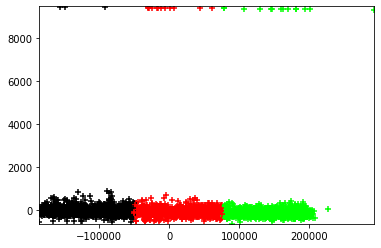

In [11]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
D_clus = kmeans.fit_predict(D_train)
D_clus = np.eye(n_clusters)[D_clus]

plot_cluster(D_train, kmeans.predict(D_train), n_clusters)

D_clus_val = kmeans.predict(D_test)
D_clus_val = np.eye(n_clusters)[D_clus_val]


losses = []
if fully_observed:
    full_losses = []
    weighted_full_losses = []
    accs = []
    
vs = []

base_hists = {}
base_hists['val_loss_hist'] = []
base_hists['loss_hist'] = []
    
for i in range(20):
    base, hist = train_base(D_clus, D_clus_val)
    base.load_weights('./model/BaseCheckpoint')
    base_hists['val_loss_hist'].append(hist.history['val_loss'])
    base_hists['loss_hist'].append(hist.history['loss'])
    
    t = kmeans.predict(D_test)
    pred = base.predict(R_test)
    vs.append(np.mean(np.var(pred, axis=0)))
    yf = pred[np.arange(len(t)), t]

    loss = np.mean(np.square(y_test - yf))
    losses.append(loss)
    
    if fully_observed:
        w = np.eye(n_clusters)[t]
        w = np.sum(w, axis=0) / len(t)
        diff = np.square(pred - y_full_test)
        weighted_full_loss = np.mean(np.sum(diff*w, axis=-1))
        weighted_full_losses.append(weighted_full_loss)
        full_loss = np.mean(diff)
        full_losses.append(full_loss)
        accs.append(AoDT(pred, y_full_test))


In [12]:
# pre = list(np.array(vs).astype('float'))
# if os.path.isfile('./model/kmbase_vs.json'):
#     with open('./model/kmbase_vs.json', 'r', encoding='utf8') as f:
#         pre += json.loads(f.read())

# with open('./model/kmbase_vs.json', 'w+', encoding='utf8') as f:
#     f.write(json.dumps(pre, ensure_ascii=False))

    
# print(np.mean(np.sort(pre)[:10]))

pre = list(np.array(accs).astype('float'))
if os.path.isfile('./model/kmbase_aodt.json'):
    with open('./model/kmbase_aodt.json', 'r', encoding='utf8') as f:
        pre += json.loads(f.read())

with open('./model/kmbase_aodt.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(pre, ensure_ascii=False))


In [13]:
print(np.mean(np.sort(pre)[-20:]))
print(len(pre))
print(pre)

0.6410313901345291
50
[0.6165919282511211, 0.6210762331838565, 0.5582959641255605, 0.6210762331838565, 0.6210762331838565, 0.6210762331838565, 0.6210762331838565, 0.6210762331838565, 0.6210762331838565, 0.6210762331838565, 0.7331838565022422, 0.6076233183856502, 0.6210762331838565, 0.6210762331838565, 0.5246636771300448, 0.6188340807174888, 0.6210762331838565, 0.6210762331838565, 0.6188340807174888, 0.6210762331838565, 0.6188340807174888, 0.6502242152466368, 0.5739910313901345, 0.5896860986547086, 0.594170403587444, 0.594170403587444, 0.594170403587444, 0.5650224215246636, 0.594170403587444, 0.594170403587444, 0.594170403587444, 0.594170403587444, 0.594170403587444, 0.5964125560538116, 0.594170403587444, 0.594170403587444, 0.594170403587444, 0.5807174887892377, 0.5896860986547086, 0.5627802690582959, 0.6502242152466368, 0.6502242152466368, 0.6502242152466368, 0.6502242152466368, 0.6502242152466368, 0.6524663677130045, 0.5538116591928252, 0.6502242152466368, 0.6502242152466368, 0.643497

In [11]:
base_hists['a_losses'] = list(np.array(losses).astype('float'))

if fully_observed:
    base_hists['full_losses'] = list(np.array(full_losses).astype('float'))
    base_hists['weighted_full_losses'] = list(np.array(weighted_full_losses).astype('float')) 

if os.path.isfile('./model/base_hist.json'):
    with open('./model/base_hist.json', 'r', encoding='utf8') as f:
        pre_hists = json.loads(f.read())
    base_hists['a_losses'] += pre_hists['a_losses']
    if fully_observed:
        base_hists['full_losses'] += pre_hists['full_losses']
        base_hists['weighted_full_losses'] += pre_hists['weighted_full_losses']
    base_hists['val_loss_hist'] += pre_hists['val_loss_hist']
    base_hists['loss_hist'] += pre_hists['loss_hist']
    
with open('./model/base_hist.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(base_hists, ensure_ascii=False))


In [12]:
with open('./model/base_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())

a_losses = hists['a_losses']
print(len(a_losses))

topa_losses = np.sort(a_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(topa_losses)), "+-", np.log(np.sqrt(np.var(topa_losses))))

if fully_observed:
    full_losses = hists['full_losses']
    weighted_full_losses = hists['weighted_full_losses']
    topfull_losses = np.sort(full_losses)[:50]
    topweighted_full_losses = np.sort(weighted_full_losses)[:50]
    print('Base line model fully observed test loss: ', np.log(np.mean(topfull_losses)), "+-", np.log(np.sqrt(np.var(topfull_losses))))
    print('Base line model weighted full observed test loss: ', np.log(np.mean(topweighted_full_losses)), "+-", np.log(np.sqrt(np.var(topweighted_full_losses))))


100
Base line model test loss:  8.858652832121773 +- 6.7375159820264425
Base line model fully observed test loss:  11.837778037295893 +- 11.36414069266046
Base line model weighted full observed test loss:  11.988666203794487 +- 11.586653762715583


## EM + Branched

In [9]:
def BaseEMLoss(y_true, y_pred):
    y = K.flatten(y_true[:, 0])
    t = y_true[:, 1:]
    
    yf = K.sum(y_pred * t, axis=-1)
    
    return K.flatten(K.square(yf - y))

def train_base_em_branched(D_cls, D_cls_val):
    RBase, Base = BaseModel(rdims, bdims)
    Base.compile(optimizer='Adam', loss=BaseEMLoss)
    checkpointer = ModelCheckpoint(filepath='./model/BaseEMCheckpoint', verbose=1, save_best_only=True)
    target = np.hstack([y_train.reshape(-1, 1), D_cls])
    target_val = np.hstack([y_test.reshape(-1, 1), D_cls_val])

    hist = Base.fit(R_train, target, validation_data=(R_test, target_val), batch_size=256, epochs=30, callbacks=[checkpointer])
    
    return Base, hist

In [10]:
gm = GaussianMixture(n_components=n_clusters, covariance_type='diag')
gm.fit(D_train)
D_clus = gm.predict_proba(D_train)
D_clus_val = gm.predict_proba(D_test)


e_losses = []
a_losses = []
vs = []

if fully_observed:
    full_losses = []
    weighted_full_losses = []
    accs = []
    
hists = {}
hists['val_loss_hist'] = []
hists['loss_hist'] = []

for i in range(10):
    base, hist = train_base_em_branched(D_clus, D_clus_val)
    base.load_weights('./model/BaseEMCheckpoint')
    hists['val_loss_hist'].append(hist.history['val_loss'])
    hists['loss_hist'].append(hist.history['loss'])
    
    test_Y_pred = base.predict(R_test)
    vs.append(np.mean(np.var(test_Y_pred, axis=0)))
    test_T_pred = D_clus_val

    # expected loss
    e_test_y_pred = np.sum(np.multiply(test_Y_pred, test_T_pred), axis=-1)
    e_test_loss = np.mean(np.square(e_test_y_pred - y_test))

    #absolute loss

    a_test_clus = np.argmax(test_T_pred, axis=-1)
    a_test_y_pred = test_Y_pred[np.arange(a_test_clus.size), a_test_clus]
    a_test_loss = np.mean(np.square(a_test_y_pred - y_test))
    
    e_losses.append(e_test_loss)
    a_losses.append(a_test_loss)
    
    if fully_observed:
        w = np.eye(n_clusters)[a_test_clus]
        w = np.sum(w, axis=0) / len(a_test_clus)
        diff = np.square(test_Y_pred - y_full_test)
        weighted_full_loss = np.mean(np.sum(diff*w, axis=-1))
        weighted_full_losses.append(weighted_full_loss)
        full_losses.append(np.mean(diff))
        accs.append(AoDT(test_Y_pred, y_full_test))
        









Train on 4014 samples, validate on 446 samples
Epoch 1/30





4014/4014 [==============================] - 2s 575us/step - loss: 2462641.5741 - val_loss: 2314314.4854

Epoch 00001: val_loss improved from inf to 2314314.48543, saving model to ./model/BaseEMCheckpoint
Epoch 2/30
4014/4014 [==============================] - 0s 39us/step - loss: 2460789.1979 - val_loss: 2307355.0078

Epoch 00002: val_loss improved from 2314314.48543 to 2307355.00785, saving model to ./model/BaseEMCheckpoint
Epoch 3/30
4014/4014 [==============================] - 0s 37us/step - loss: 2438632.6437 - val_loss: 2226751.9843

Epoch 00003: val_loss improved from 2307355.00785 to 2226751.98430, saving model to ./model/BaseEMCheckpoint
Epoch 4/30
4014/4014 [==============================] - 0s 34us/step - loss: 2262869.9393 - val_loss: 1761038.5107

Epoch 00004: val_loss improved from 2226751.98430 to 1761038.51065, saving model to ./model/BaseEMCheckpoint
Epoch 5/30
4014/4014 [===========================


Epoch 00009: val_loss improved from 752645.92517 to 679570.22253, saving model to ./model/BaseEMCheckpoint
Epoch 10/30
4014/4014 [==============================] - 0s 37us/step - loss: 491855.7338 - val_loss: 602510.4877

Epoch 00010: val_loss improved from 679570.22253 to 602510.48767, saving model to ./model/BaseEMCheckpoint
Epoch 11/30
4014/4014 [==============================] - 0s 35us/step - loss: 460664.1473 - val_loss: 577165.6740

Epoch 00011: val_loss improved from 602510.48767 to 577165.67405, saving model to ./model/BaseEMCheckpoint
Epoch 12/30
4014/4014 [==============================] - 0s 37us/step - loss: 442339.9163 - val_loss: 566549.3142

Epoch 00012: val_loss improved from 577165.67405 to 566549.31418, saving model to ./model/BaseEMCheckpoint
Epoch 13/30
4014/4014 [==============================] - 0s 48us/step - loss: 429255.5522 - val_loss: 584684.1578

Epoch 00013: val_loss did not improve from 566549.31418
Epoch 14/30
4014/4014 [==============================] 


Epoch 00004: val_loss improved from 2230133.18386 to 1790957.41536, saving model to ./model/BaseEMCheckpoint
Epoch 5/30
4014/4014 [==============================] - 0s 40us/step - loss: 1642340.3650 - val_loss: 1003111.9041

Epoch 00005: val_loss improved from 1790957.41536 to 1003111.90415, saving model to ./model/BaseEMCheckpoint
Epoch 6/30
4014/4014 [==============================] - 0s 40us/step - loss: 849660.0684 - val_loss: 1603897.1670

Epoch 00006: val_loss did not improve from 1003111.90415
Epoch 7/30
4014/4014 [==============================] - 0s 40us/step - loss: 634622.0858 - val_loss: 937564.7719

Epoch 00007: val_loss improved from 1003111.90415 to 937564.77186, saving model to ./model/BaseEMCheckpoint
Epoch 8/30
4014/4014 [==============================] - 0s 40us/step - loss: 541857.6084 - val_loss: 802021.4243

Epoch 00008: val_loss improved from 937564.77186 to 802021.42433, saving model to ./model/BaseEMCheckpoint
Epoch 9/30
4014/4014 [============================


Epoch 00016: val_loss improved from 587574.16228 to 574156.79596, saving model to ./model/BaseEMCheckpoint
Epoch 17/30
4014/4014 [==============================] - 0s 37us/step - loss: 410409.1925 - val_loss: 561579.2105

Epoch 00017: val_loss improved from 574156.79596 to 561579.21048, saving model to ./model/BaseEMCheckpoint
Epoch 18/30
4014/4014 [==============================] - 0s 40us/step - loss: 400163.9027 - val_loss: 576529.1247

Epoch 00018: val_loss did not improve from 561579.21048
Epoch 19/30
4014/4014 [==============================] - 0s 39us/step - loss: 387029.9757 - val_loss: 561546.0942

Epoch 00019: val_loss improved from 561579.21048 to 561546.09417, saving model to ./model/BaseEMCheckpoint
Epoch 20/30
4014/4014 [==============================] - 0s 38us/step - loss: 385165.2215 - val_loss: 575794.6163

Epoch 00020: val_loss did not improve from 561546.09417
Epoch 21/30
4014/4014 [==============================] - 0s 42us/step - loss: 372594.7548 - val_loss: 5829

4014/4014 [==============================] - 0s 41us/step - loss: 335650.6462 - val_loss: 574599.9739

Epoch 00029: val_loss did not improve from 554330.13285
Epoch 30/30
4014/4014 [==============================] - 0s 38us/step - loss: 330932.0257 - val_loss: 563975.9193

Epoch 00030: val_loss did not improve from 554330.13285
Train on 4014 samples, validate on 446 samples
Epoch 1/30
4014/4014 [==============================] - 2s 620us/step - loss: 2462649.9949 - val_loss: 2314348.4305

Epoch 00001: val_loss improved from inf to 2314348.43049, saving model to ./model/BaseEMCheckpoint
Epoch 2/30
4014/4014 [==============================] - 0s 47us/step - loss: 2460857.5187 - val_loss: 2308263.7567

Epoch 00002: val_loss improved from 2314348.43049 to 2308263.75673, saving model to ./model/BaseEMCheckpoint
Epoch 3/30
4014/4014 [==============================] - 0s 43us/step - loss: 2438823.6885 - val_loss: 2241130.6962

Epoch 00003: val_loss improved from 2308263.75673 to 2241130.69619

In [11]:
# pre = list(np.array(vs).astype('float'))
# if os.path.isfile('./model/embase_vs.json'):
#     with open('./model/embase_vs.json', 'r', encoding='utf8') as f:
#         pre += json.loads(f.read())

# with open('./model/embase_vs.json', 'w+', encoding='utf8') as f:
#     f.write(json.dumps(pre, ensure_ascii=False))

    
# print(np.mean(np.sort(pre)[:10]))

pre = list(np.array(accs).astype('float'))
if os.path.isfile('./model/embase_aodt.json'):
    with open('./model/embase_aodt.json', 'r', encoding='utf8') as f:
        pre += json.loads(f.read())

with open('./model/embase_aodt.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(pre, ensure_ascii=False))

    
print(np.mean(np.sort(pre)[-20:]))
print(pre)

0.6562780269058297
[0.594170403587444, 0.48878923766816146, 0.6681614349775785, 0.5179372197309418, 0.531390134529148, 0.6681614349775785, 0.7286995515695067, 0.4641255605381166, 0.695067264573991, 0.5807174887892377, 0.5381165919282511, 0.5919282511210763, 0.5201793721973094, 0.47757847533632286, 0.5336322869955157, 0.594170403587444, 0.6547085201793722, 0.5426008968609866, 0.5874439461883408, 0.6681614349775785, 0.5224215246636771, 0.6412556053811659, 0.48878923766816146, 0.6883408071748879, 0.4618834080717489, 0.5605381165919282, 0.4977578475336323, 0.6434977578475336, 0.5717488789237668, 0.672645739910314, 0.5739910313901345, 0.5112107623318386, 0.6278026905829597, 0.7152466367713004, 0.6053811659192825, 0.6502242152466368, 0.5358744394618834, 0.5179372197309418, 0.48878923766816146, 0.47085201793721976, 0.5964125560538116, 0.6367713004484304, 0.594170403587444, 0.547085201793722, 0.6076233183856502, 0.647982062780269, 0.6681614349775785, 0.6121076233183856, 0.625560538116592, 0.52

In [10]:
hists['e_losses'] = list(np.array(e_losses).astype('float'))
hists['a_losses'] = list(np.array(a_losses).astype('float'))

if fully_observed:
    hists['full_losses'] = list(np.array(full_losses).astype('float'))
    hists['weighted_full_losses'] = list(np.array(weighted_full_losses).astype('float')) 

if os.path.isfile('./model/base_em_hist.json'):
    with open('./model/base_em_hist.json', 'r', encoding='utf8') as f:
        pre_hists = json.loads(f.read())
    hists['e_losses'] += pre_hists['e_losses']
    hists['a_losses'] += pre_hists['a_losses']
    if fully_observed:
        hists['full_losses'] += pre_hists['full_losses']
        hists['weighted_full_losses'] += pre_hists['weighted_full_losses']
    hists['val_loss_hist'] += pre_hists['val_loss_hist']
    hists['loss_hist'] += pre_hists['loss_hist']
    
with open('./model/base_em_hist.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(hists, ensure_ascii=False))

In [11]:
with open('./model/base_em_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())
    
print(len(hists['e_losses']))

100


In [12]:
with open('./model/base_em_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())

e_losses = hists['e_losses']
a_losses = hists['a_losses']

tope_losses = np.sort(e_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(tope_losses)), "+-", np.log(np.sqrt(np.var(tope_losses))))
topa_losses = np.sort(a_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(topa_losses)), "+-", np.log(np.sqrt(np.var(topa_losses))))

if fully_observed:
    full_losses = hists['full_losses']
    weighted_full_losses = hists['weighted_full_losses']
    topfull_losses = np.sort(full_losses)[:50]
    topweighted_full_losses = np.sort(weighted_full_losses)[:50]
    print('Base line model fully observed test loss: ', np.log(np.mean(topfull_losses)), "+-", np.log(np.sqrt(np.var(topfull_losses))))
    print('Base line model weighted full observed test loss: ', np.log(np.mean(topweighted_full_losses)), "+-", np.log(np.sqrt(np.var(topweighted_full_losses))))


Base line model test loss:  8.129735354059456 +- 4.744467998376108
Base line model test loss:  8.1297353441535 +- 4.744468065578055
Base line model fully observed test loss:  11.015848486396793 +- 6.955980979550284
Base line model weighted full observed test loss:  10.831527369718057 +- 6.85120863739337


## DEC + Branched

In [13]:
def BaseDECLoss(y_true, y_pred):
    y = K.flatten(y_true[:, 0])
    t = y_true[:, 1:]
    
    yf = K.sum(y_pred * t, axis=-1)
    
    return K.flatten(K.square(yf - y))

def train_base_dec_branched(D_cls, D_cls_val):
    RBase, Base = BaseModel(rdims, bdims)
    Base.compile(optimizer='Adam', loss=BaseDECLoss)
    checkpointer = ModelCheckpoint(filepath='./model/BaseDECCheckpoint', verbose=1, save_best_only=True)
    target = np.hstack([y_train.reshape(-1, 1), D_cls])
    target_val = np.hstack([y_test.reshape(-1, 1), D_cls_val])

    hist = Base.fit(R_train, target, validation_data=(R_test, target_val), batch_size=256, epochs=30, callbacks=[checkpointer])
    
    return Base, hist

In [14]:
DEC.load_weights(model_path + '/DECweights')
D_clus = DEC.predict(D_train)
D_clus_val = DEC.predict(D_test)

e_losses = []
a_losses = []
vs = []

if fully_observed:
    full_losses = []
    weighted_full_losses = []
    accs = []
    
hists = {}
hists['val_loss_hist'] = []
hists['loss_hist'] = []

for i in range(20):
    base, hist = train_base_dec_branched(D_clus, D_clus_val)
    base.load_weights('./model/BaseDECCheckpoint')
    hists['val_loss_hist'].append(hist.history['val_loss'])
    hists['loss_hist'].append(hist.history['loss'])
    
    test_Y_pred = base.predict(R_test)
    vs.append(np.mean(np.var(test_Y_pred, axis=0)))
    test_T_pred = D_clus_val

    # expected loss
    e_test_y_pred = np.sum(np.multiply(test_Y_pred, test_T_pred), axis=-1)
    e_test_loss = np.mean(np.square(e_test_y_pred - y_test))

    #absolute loss

    a_test_clus = np.argmax(test_T_pred, axis=-1)
    a_test_y_pred = test_Y_pred[np.arange(a_test_clus.size), a_test_clus]
    a_test_loss = np.mean(np.square(a_test_y_pred - y_test))
    
    e_losses.append(e_test_loss)
    a_losses.append(a_test_loss)
    
    if fully_observed:
        w = np.eye(n_clusters)[a_test_clus]
        w = np.sum(w, axis=0) / len(a_test_clus)
        diff = np.square(test_Y_pred - y_full_test)
        weighted_full_loss = np.mean(np.sum(diff*w, axis=-1))
        weighted_full_losses.append(weighted_full_loss)
        full_losses.append(np.mean(diff))
        accs.append(AoDT(test_Y_pred, y_full_test))
        




Train on 4014 samples, validate on 446 samples
Epoch 1/30
4014/4014 [==============================] - 1s 223us/step - loss: 2431207.4619 - val_loss: 2597146.5482

Epoch 00001: val_loss improved from inf to 2597146.54821, saving model to ./model/BaseDECCheckpoint
Epoch 2/30
4014/4014 [==============================] - 0s 36us/step - loss: 2429370.5420 - val_loss: 2587787.9776

Epoch 00002: val_loss improved from 2597146.54821 to 2587787.97758, saving model to ./model/BaseDECCheckpoint
Epoch 3/30
4014/4014 [==============================] - 0s 36us/step - loss: 2406994.0762 - val_loss: 2482156.8991

Epoch 00003: val_loss improved from 2587787.97758 to 2482156.89910, saving model to ./model/BaseDECCheckpoint
Epoch 4/30
4014/4014 [==============================] - 0s 38us/step - loss: 2232712.5797 - val_loss: 1960770.0067

Epoch 00004: val_loss improved from 2482156.89910 to 1960770.00673, saving model to ./model/BaseDECCheckpoint
Epoch 5/30
4014/4014 [==============================] -


Epoch 00020: val_loss did not improve from 503961.47365
Epoch 21/30
4014/4014 [==============================] - 0s 33us/step - loss: 361662.7201 - val_loss: 503090.3652

Epoch 00021: val_loss improved from 503961.47365 to 503090.36519, saving model to ./model/BaseDECCheckpoint
Epoch 22/30
4014/4014 [==============================] - 0s 33us/step - loss: 351278.0412 - val_loss: 516406.6841

Epoch 00022: val_loss did not improve from 503090.36519
Epoch 23/30
4014/4014 [==============================] - 0s 31us/step - loss: 341672.6616 - val_loss: 515815.4027

Epoch 00023: val_loss did not improve from 503090.36519
Epoch 24/30
4014/4014 [==============================] - 0s 30us/step - loss: 339491.9389 - val_loss: 528436.2309

Epoch 00024: val_loss did not improve from 503090.36519
Epoch 25/30
4014/4014 [==============================] - 0s 29us/step - loss: 332792.6539 - val_loss: 515079.6917

Epoch 00025: val_loss did not improve from 503090.36519
Epoch 26/30
4014/4014 [=============

Epoch 4/30
4014/4014 [==============================] - 0s 36us/step - loss: 2254032.0521 - val_loss: 2092875.3184

Epoch 00004: val_loss improved from 2517236.34081 to 2092875.31839, saving model to ./model/BaseDECCheckpoint
Epoch 5/30
4014/4014 [==============================] - 0s 35us/step - loss: 1580244.9215 - val_loss: 992325.2741

Epoch 00005: val_loss improved from 2092875.31839 to 992325.27410, saving model to ./model/BaseDECCheckpoint
Epoch 6/30
4014/4014 [==============================] - 0s 35us/step - loss: 722963.9492 - val_loss: 2389997.0605

Epoch 00006: val_loss did not improve from 992325.27410
Epoch 7/30
4014/4014 [==============================] - 0s 36us/step - loss: 520351.2764 - val_loss: 1455230.2685

Epoch 00007: val_loss did not improve from 992325.27410
Epoch 8/30
4014/4014 [==============================] - 0s 34us/step - loss: 480634.7610 - val_loss: 956085.2116

Epoch 00008: val_loss improved from 992325.27410 to 956085.21160, saving model to ./model/Base

4014/4014 [==============================] - 0s 30us/step - loss: 392074.7359 - val_loss: 573746.3627

Epoch 00017: val_loss did not improve from 497605.02186
Epoch 18/30
4014/4014 [==============================] - 0s 31us/step - loss: 387048.4461 - val_loss: 569166.5418

Epoch 00018: val_loss did not improve from 497605.02186
Epoch 19/30
4014/4014 [==============================] - 0s 32us/step - loss: 378665.6459 - val_loss: 615583.2559

Epoch 00019: val_loss did not improve from 497605.02186
Epoch 20/30
4014/4014 [==============================] - 0s 30us/step - loss: 375315.0379 - val_loss: 640396.1541

Epoch 00020: val_loss did not improve from 497605.02186
Epoch 21/30
4014/4014 [==============================] - 0s 29us/step - loss: 365265.9994 - val_loss: 605847.7410

Epoch 00021: val_loss did not improve from 497605.02186
Epoch 22/30
4014/4014 [==============================] - 0s 29us/step - loss: 359038.3139 - val_loss: 629419.5384

Epoch 00022: val_loss did not improve from

4014/4014 [==============================] - 2s 509us/step - loss: 2431232.3051 - val_loss: 2597293.8117

Epoch 00001: val_loss improved from inf to 2597293.81166, saving model to ./model/BaseDECCheckpoint
Epoch 2/30
4014/4014 [==============================] - 0s 37us/step - loss: 2429783.5188 - val_loss: 2591902.1267

Epoch 00002: val_loss improved from 2597293.81166 to 2591902.12668, saving model to ./model/BaseDECCheckpoint
Epoch 3/30
4014/4014 [==============================] - 0s 36us/step - loss: 2413194.0725 - val_loss: 2532602.9989

Epoch 00003: val_loss improved from 2591902.12668 to 2532602.99888, saving model to ./model/BaseDECCheckpoint
Epoch 4/30
4014/4014 [==============================] - 0s 36us/step - loss: 2280167.4440 - val_loss: 2165268.4092

Epoch 00004: val_loss improved from 2532602.99888 to 2165268.40919, saving model to ./model/BaseDECCheckpoint
Epoch 5/30
4014/4014 [==============================] - 0s 36us/step - loss: 1682126.8235 - val_loss: 1024227.2220



4014/4014 [==============================] - 0s 33us/step - loss: 301158.6108 - val_loss: 611961.8913

Epoch 00026: val_loss did not improve from 505071.97926
Epoch 27/30
4014/4014 [==============================] - 0s 32us/step - loss: 305273.8291 - val_loss: 611773.0877

Epoch 00027: val_loss did not improve from 505071.97926
Epoch 28/30
4014/4014 [==============================] - 0s 35us/step - loss: 289621.0548 - val_loss: 604092.0286

Epoch 00028: val_loss did not improve from 505071.97926
Epoch 29/30
4014/4014 [==============================] - 0s 32us/step - loss: 286573.0319 - val_loss: 618730.6166

Epoch 00029: val_loss did not improve from 505071.97926
Epoch 30/30
4014/4014 [==============================] - 0s 32us/step - loss: 280894.8006 - val_loss: 674087.8826

Epoch 00030: val_loss did not improve from 505071.97926
Train on 4014 samples, validate on 446 samples
Epoch 1/30
4014/4014 [==============================] - 3s 675us/step - loss: 2431219.6817 - val_loss: 2597239

4014/4014 [==============================] - 0s 34us/step - loss: 328488.3986 - val_loss: 650202.7996

Epoch 00023: val_loss did not improve from 530069.29036
Epoch 24/30
4014/4014 [==============================] - 0s 35us/step - loss: 325551.6473 - val_loss: 624963.9521

Epoch 00024: val_loss did not improve from 530069.29036
Epoch 25/30
4014/4014 [==============================] - 0s 34us/step - loss: 320081.5362 - val_loss: 623814.6623

Epoch 00025: val_loss did not improve from 530069.29036
Epoch 26/30
4014/4014 [==============================] - 0s 33us/step - loss: 314198.6103 - val_loss: 608676.8702

Epoch 00026: val_loss did not improve from 530069.29036
Epoch 27/30
4014/4014 [==============================] - 0s 33us/step - loss: 297676.9749 - val_loss: 628906.9837

Epoch 00027: val_loss did not improve from 530069.29036
Epoch 28/30
4014/4014 [==============================] - 0s 34us/step - loss: 295036.2846 - val_loss: 620745.6768

Epoch 00028: val_loss did not improve from

Epoch 6/30
4014/4014 [==============================] - 0s 39us/step - loss: 744472.4615 - val_loss: 2220965.9809

Epoch 00006: val_loss did not improve from 1039750.38453
Epoch 7/30
4014/4014 [==============================] - 0s 40us/step - loss: 621086.3916 - val_loss: 1214188.7108

Epoch 00007: val_loss did not improve from 1039750.38453
Epoch 8/30
4014/4014 [==============================] - 0s 40us/step - loss: 550445.5284 - val_loss: 830748.3487

Epoch 00008: val_loss improved from 1039750.38453 to 830748.34865, saving model to ./model/BaseDECCheckpoint
Epoch 9/30
4014/4014 [==============================] - 0s 38us/step - loss: 513310.5132 - val_loss: 662354.5488

Epoch 00009: val_loss improved from 830748.34865 to 662354.54877, saving model to ./model/BaseDECCheckpoint
Epoch 10/30
4014/4014 [==============================] - 0s 38us/step - loss: 485454.8824 - val_loss: 586642.3966

Epoch 00010: val_loss improved from 662354.54877 to 586642.39658, saving model to ./model/BaseDE

4014/4014 [==============================] - 0s 38us/step - loss: 351952.5998 - val_loss: 630054.6099

Epoch 00019: val_loss did not improve from 530049.34277
Epoch 20/30
4014/4014 [==============================] - 0s 36us/step - loss: 341379.2437 - val_loss: 580613.4950

Epoch 00020: val_loss did not improve from 530049.34277
Epoch 21/30
4014/4014 [==============================] - 0s 37us/step - loss: 335617.3038 - val_loss: 622932.2777

Epoch 00021: val_loss did not improve from 530049.34277
Epoch 22/30
4014/4014 [==============================] - 0s 37us/step - loss: 325804.5784 - val_loss: 673380.4759

Epoch 00022: val_loss did not improve from 530049.34277
Epoch 23/30
4014/4014 [==============================] - 0s 37us/step - loss: 318642.6850 - val_loss: 618708.1331

Epoch 00023: val_loss did not improve from 530049.34277
Epoch 24/30
4014/4014 [==============================] - 0s 38us/step - loss: 319929.2617 - val_loss: 662071.3290

Epoch 00024: val_loss did not improve from

4014/4014 [==============================] - 0s 40us/step - loss: 437781.8521 - val_loss: 504453.6087

Epoch 00013: val_loss improved from 515569.71244 to 504453.60874, saving model to ./model/BaseDECCheckpoint
Epoch 14/30
4014/4014 [==============================] - 0s 40us/step - loss: 430524.1374 - val_loss: 501004.1483

Epoch 00014: val_loss improved from 504453.60874 to 501004.14826, saving model to ./model/BaseDECCheckpoint
Epoch 15/30
4014/4014 [==============================] - 0s 41us/step - loss: 419706.2207 - val_loss: 510236.3719

Epoch 00015: val_loss did not improve from 501004.14826
Epoch 16/30
4014/4014 [==============================] - 0s 42us/step - loss: 406284.6222 - val_loss: 533342.6421

Epoch 00016: val_loss did not improve from 501004.14826
Epoch 17/30
4014/4014 [==============================] - 0s 41us/step - loss: 401544.9710 - val_loss: 546498.6082

Epoch 00017: val_loss did not improve from 501004.14826
Epoch 18/30
4014/4014 [==============================

4014/4014 [==============================] - 0s 41us/step - loss: 314218.2098 - val_loss: 593645.5835

Epoch 00027: val_loss did not improve from 556530.57483
Epoch 28/30
4014/4014 [==============================] - 0s 41us/step - loss: 298940.3151 - val_loss: 608471.3473

Epoch 00028: val_loss did not improve from 556530.57483
Epoch 29/30
4014/4014 [==============================] - 0s 39us/step - loss: 302693.6076 - val_loss: 621664.0404

Epoch 00029: val_loss did not improve from 556530.57483
Epoch 30/30
4014/4014 [==============================] - 0s 40us/step - loss: 297306.6577 - val_loss: 614317.6031

Epoch 00030: val_loss did not improve from 556530.57483


In [15]:
# pre = list(np.array(vs).astype('float'))
# if os.path.isfile('./model/decbase_vs.json'):
#     with open('./model/decbase_vs.json', 'r', encoding='utf8') as f:
#         pre += json.loads(f.read())

# with open('./model/decbase_vs.json', 'w+', encoding='utf8') as f:
#     f.write(json.dumps(pre, ensure_ascii=False))

    
# print(np.mean(np.sort(pre)[:10]))


pre = list(np.array(accs).astype('float'))
if os.path.isfile('./model/decbase_aodt.json'):
    with open('./model/decbase_aodt.json', 'r', encoding='utf8') as f:
        pre += json.loads(f.read())

with open('./model/decbase_aodt.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(pre, ensure_ascii=False))


In [16]:
print(np.mean(np.sort(pre)[-20:]))
print(pre)
print(len(pre))

0.6430493273542599
[0.6390134529147982, 0.6367713004484304, 0.6390134529147982, 0.6390134529147982, 0.6390134529147982, 0.6390134529147982, 0.6390134529147982, 0.6390134529147982, 0.6390134529147982, 0.6390134529147982, 0.547085201793722, 0.6390134529147982, 0.6390134529147982, 0.6390134529147982, 0.6390134529147982, 0.5291479820627802, 0.625560538116592, 0.6322869955156951, 0.6390134529147982, 0.6390134529147982, 0.6278026905829597, 0.6278026905829597, 0.6143497757847534, 0.6278026905829597, 0.625560538116592, 0.6278026905829597, 0.6121076233183856, 0.6278026905829597, 0.6278026905829597, 0.6322869955156951, 0.5358744394618834, 0.6278026905829597, 0.6278026905829597, 0.515695067264574, 0.6883408071748879, 0.6278026905829597, 0.6278026905829597, 0.6278026905829597, 0.6278026905829597, 0.5358744394618834, 0.5224215246636771, 0.5874439461883408, 0.6300448430493274, 0.6300448430493274, 0.6300448430493274, 0.6300448430493274, 0.5538116591928252, 0.6300448430493274, 0.6860986547085202, 0.62

In [14]:
hists['e_losses'] = list(np.array(e_losses).astype('float'))
hists['a_losses'] = list(np.array(a_losses).astype('float'))

if fully_observed:
    hists['full_losses'] = list(np.array(full_losses).astype('float'))
    hists['weighted_full_losses'] = list(np.array(weighted_full_losses).astype('float')) 

if os.path.isfile('./model/base_dec_hist.json'):
    with open('./model/base_dec_hist.json', 'r', encoding='utf8') as f:
        pre_hists = json.loads(f.read())
    hists['e_losses'] += pre_hists['e_losses']
    hists['a_losses'] += pre_hists['a_losses']
    if fully_observed:
        hists['full_losses'] += pre_hists['full_losses']
        hists['weighted_full_losses'] += pre_hists['weighted_full_losses']
    hists['val_loss_hist'] += pre_hists['val_loss_hist']
    hists['loss_hist'] += pre_hists['loss_hist']
    
with open('./model/base_dec_hist.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(hists, ensure_ascii=False))

In [15]:
with open('./model/base_dec_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())
    
print(len(hists['e_losses']))

with open('./model/base_dec_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())

e_losses = hists['e_losses']
a_losses = hists['a_losses']

tope_losses = np.sort(e_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(tope_losses)), "+-", np.log(np.sqrt(np.var(tope_losses))))
topa_losses = np.sort(a_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(topa_losses)), "+-", np.log(np.sqrt(np.var(topa_losses))))

if fully_observed:
    full_losses = hists['full_losses']
    weighted_full_losses = hists['weighted_full_losses']
    topfull_losses = np.sort(full_losses)[:50]
    topweighted_full_losses = np.sort(weighted_full_losses)[:50]
    print('Base line model fully observed test loss: ', np.log(np.mean(topfull_losses)), "+-", np.log(np.sqrt(np.var(topfull_losses))))
    print('Base line model weighted full observed test loss: ', np.log(np.mean(topweighted_full_losses)), "+-", np.log(np.sqrt(np.var(topweighted_full_losses))))


100
Base line model test loss:  8.748920004049927 +- 6.1721410922791184
Base line model test loss:  8.77929251393875 +- 6.277565029991035
Base line model fully observed test loss:  11.002188481806794 +- 7.09006351081269
Base line model weighted full observed test loss:  10.83695323491431 +- 7.2720361084238005


# Baseline Branched with Rep

In [7]:
def BaseRModel(rdims, bdims):
    inp = Input(shape=(R_train.shape[-1], ), name='recipient_input')
    r = inp
    r = BatchNormalization()(r)
    for i in range(len(rdims)-1):
        r = Dense(rdims[i], activation='relu', kernel_initializer='normal', name='r_representation_%d' % i)(r)
    r = BatchNormalization()(r)
    r = Dense(rdims[-1], activation='relu', kernel_initializer='normal', name='r_representation')(r)
    
    ys = []
    for i in range(n_clusters):
        z = Dense(bdims[0], activation='relu', kernel_initializer='normal', name='branch_%d_0' % i)(r)
        for j in range(1, len(bdims)):
            z = Dense(bdims[j], activation='relu', kernel_initializer='normal', name='branch_%d_%d' % (i, j))(z)
        z = Dense(1, activation='relu', kernel_initializer='normal', name='branch_%d' % i)(z)
        ys.append(z)
        
    ys = Concatenate()(ys)
    out = Concatenate()([ys, r])
    
    return Model(inputs=inp, outputs=ys), Model(inputs=inp, outputs=out)

## Kmeans

In [8]:
alpha = .5

def BaseRloss(y_true, y_pred):
    r = y_pred[:, n_clusters:]
    y_pred = y_pred[:, :n_clusters]
    
    y = K.repeat_elements(K.reshape(y_true[:, 0], (-1, 1)), rep=n_clusters, axis=1)
    t = y_true[:, 1:]
    
    yf = y_pred * t
    y = y * t
    
    yloss = K.flatten(K.sum(K.square(y - yf), axis=1))
    
    tmean = K.mean(r, axis=0)
    tvar = K.var(r, axis=0)
    rloss = 0
    for i in range(n_clusters):
        w = K.reshape(t[:, i], shape=(-1, 1))
        weighted = r * w
        mean = K.mean(weighted, axis=0)
        var = K.var(weighted, axis=0)
        rloss += K.sum(K.square(mean-tmean)) + K.sum(K.square(var-tvar))

    return yloss + alpha*rloss

In [9]:
def train_base_r(D_cls, D_cls_val):
    Base, BaseR = BaseRModel(rdims, bdims)
    
    BaseR.compile(optimizer='Adam', loss=BaseRloss)
    
    checkpointer = ModelCheckpoint(filepath='./model/BaseRCheckpoint', verbose=1, save_best_only=True)

    target = np.hstack([y_train.reshape(-1, 1), D_cls])
    target_val = np.hstack([y_test.reshape(-1, 1), D_cls_val])

    hist = BaseR.fit(R_train, target, validation_data=(R_test, target_val), batch_size=256, epochs=30, callbacks=[checkpointer])

    return Base, BaseR, hist
    
#Base.save_weights(model_path + '/RBaseWeights')

In [10]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
D_clus = kmeans.fit_predict(D_train)
D_clus = np.eye(n_clusters)[D_clus]

D_clus_val = kmeans.predict(D_test)
D_clus_val = np.eye(n_clusters)[D_clus_val]

losses = []
if fully_observed:
    full_losses = []
    weighted_full_losses = []
    
hists = {}
hists['val_loss_hist'] = []
hists['loss_hist'] = []
    
for i in range(10):
    Base, BaseR, hist = train_base_r(D_clus, D_clus_val)
    BaseR.load_weights('./model/BaseRCheckpoint')
    hists['val_loss_hist'].append(hist.history['val_loss'])
    hists['loss_hist'].append(hist.history['loss'])

    t = kmeans.predict(D_test)
    pred = Base.predict(R_test)[:, :n_clusters]
    yf = pred[np.arange(len(t)), t]

    loss = np.mean(np.square(y_test - yf))
    losses.append(loss)
    
    if fully_observed:
        w = np.eye(n_clusters)[t]
        w = np.sum(w, axis=0) / len(t)
        diff = np.square(pred - y_full_test)
        weighted_full_loss = np.mean(np.sum(diff*w, axis=-1))
        weighted_full_losses.append(weighted_full_loss)
        full_loss = np.mean(diff)
        full_losses.append(full_loss)









Train on 9000 samples, validate on 1000 samples
Epoch 1/30





9000/9000 [==============================] - 3s 324us/step - loss: 279455.5126 - val_loss: 265909.3108

Epoch 00001: val_loss improved from inf to 265909.31075, saving model to ./model/BaseRCheckpoint
Epoch 2/30
9000/9000 [==============================] - 1s 66us/step - loss: 205671.0344 - val_loss: 101013.0380

Epoch 00002: val_loss improved from 265909.31075 to 101013.03800, saving model to ./model/BaseRCheckpoint
Epoch 3/30
9000/9000 [==============================] - 1s 64us/step - loss: 26689.3298 - val_loss: 29333.4869

Epoch 00003: val_loss improved from 101013.03800 to 29333.48689, saving model to ./model/BaseRCheckpoint
Epoch 4/30
9000/9000 [==============================] - 1s 64us/step - loss: 10751.9900 - val_loss: 12433.5882

Epoch 00004: val_loss improved from 29333.48689 to 12433.58822, saving model to ./model/BaseRCheckpoint
Epoch 5/30
9000/9000 [==============================] - 1s 61us/step - los


Epoch 00013: val_loss did not improve from 10229.74568
Epoch 14/30
9000/9000 [==============================] - 1s 64us/step - loss: 6166.4564 - val_loss: 11217.9047

Epoch 00014: val_loss did not improve from 10229.74568
Epoch 15/30
9000/9000 [==============================] - 1s 63us/step - loss: 5620.2425 - val_loss: 10482.3928

Epoch 00015: val_loss did not improve from 10229.74568
Epoch 16/30
9000/9000 [==============================] - 1s 67us/step - loss: 5801.5436 - val_loss: 10216.8220

Epoch 00016: val_loss improved from 10229.74568 to 10216.82204, saving model to ./model/BaseRCheckpoint
Epoch 17/30
9000/9000 [==============================] - 1s 66us/step - loss: 5794.9456 - val_loss: 9709.5298

Epoch 00017: val_loss improved from 10216.82204 to 9709.52979, saving model to ./model/BaseRCheckpoint
Epoch 18/30
9000/9000 [==============================] - 1s 63us/step - loss: 5539.2184 - val_loss: 8117.2038

Epoch 00018: val_loss improved from 9709.52979 to 8117.20377, saving 


Epoch 00012: val_loss did not improve from 10479.76357
Epoch 13/30
9000/9000 [==============================] - 1s 62us/step - loss: 6291.9288 - val_loss: 11975.5527

Epoch 00013: val_loss did not improve from 10479.76357
Epoch 14/30
9000/9000 [==============================] - 1s 63us/step - loss: 5951.2882 - val_loss: 13672.8438

Epoch 00014: val_loss did not improve from 10479.76357
Epoch 15/30
9000/9000 [==============================] - 1s 64us/step - loss: 5180.8738 - val_loss: 10726.0515

Epoch 00015: val_loss did not improve from 10479.76357
Epoch 16/30
9000/9000 [==============================] - 1s 63us/step - loss: 5569.8067 - val_loss: 10859.3350

Epoch 00016: val_loss did not improve from 10479.76357
Epoch 17/30
9000/9000 [==============================] - 1s 67us/step - loss: 5272.7169 - val_loss: 10854.9056

Epoch 00017: val_loss did not improve from 10479.76357
Epoch 18/30
9000/9000 [==============================] - 1s 62us/step - loss: 4938.2951 - val_loss: 10197.336

9000/9000 [==============================] - 1s 65us/step - loss: 3949.7624 - val_loss: 9981.8821

Epoch 00027: val_loss did not improve from 8614.47377
Epoch 28/30
9000/9000 [==============================] - 1s 65us/step - loss: 3918.9734 - val_loss: 8745.4302

Epoch 00028: val_loss did not improve from 8614.47377
Epoch 29/30
9000/9000 [==============================] - 1s 66us/step - loss: 4052.1148 - val_loss: 9236.1001

Epoch 00029: val_loss did not improve from 8614.47377
Epoch 30/30
9000/9000 [==============================] - 1s 66us/step - loss: 4033.8532 - val_loss: 9550.1237

Epoch 00030: val_loss did not improve from 8614.47377
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 3s 362us/step - loss: 279786.9051 - val_loss: 268342.5648

Epoch 00001: val_loss improved from inf to 268342.56475, saving model to ./model/BaseRCheckpoint
Epoch 2/30
9000/9000 [==============================] - 1s 68us/step - loss: 220579.7881 - v

9000/9000 [==============================] - 1s 74us/step - loss: 4053.4125 - val_loss: 9767.0883

Epoch 00026: val_loss did not improve from 8516.88555
Epoch 27/30
9000/9000 [==============================] - 1s 75us/step - loss: 4004.0728 - val_loss: 9211.6006

Epoch 00027: val_loss did not improve from 8516.88555
Epoch 28/30
9000/9000 [==============================] - 1s 75us/step - loss: 3865.2814 - val_loss: 8960.4186

Epoch 00028: val_loss did not improve from 8516.88555
Epoch 29/30
9000/9000 [==============================] - 1s 74us/step - loss: 4798.0620 - val_loss: 9279.8383

Epoch 00029: val_loss did not improve from 8516.88555
Epoch 30/30
9000/9000 [==============================] - 1s 74us/step - loss: 3653.6988 - val_loss: 11320.3081

Epoch 00030: val_loss did not improve from 8516.88555


In [11]:
hists['a_losses'] = list(np.array(losses).astype('float'))

if fully_observed:
    hists['full_losses'] = list(np.array(full_losses).astype('float'))
    hists['weighted_full_losses'] = list(np.array(weighted_full_losses).astype('float')) 

if os.path.isfile('./model/base_rep_hist.json'):
    with open('./model/base_rep_hist.json', 'r', encoding='utf8') as f:
        pre_hists = json.loads(f.read())
    hists['a_losses'] += pre_hists['a_losses']
    if fully_observed:
        hists['full_losses'] += pre_hists['full_losses']
        hists['weighted_full_losses'] += pre_hists['weighted_full_losses']
    hists['val_loss_hist'] += pre_hists['val_loss_hist']
    hists['loss_hist'] += pre_hists['loss_hist']
    
with open('./model/base_rep_hist.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(hists, ensure_ascii=False))


In [12]:
with open('./model/base_rep_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())

a_losses = hists['a_losses']
print(len(a_losses))

topa_losses = np.sort(a_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(topa_losses)), "+-", np.log(np.sqrt(np.var(topa_losses))))

if fully_observed:
    full_losses = hists['full_losses']
    weighted_full_losses = hists['weighted_full_losses']
    topfull_losses = np.sort(full_losses)[:50]
    topweighted_full_losses = np.sort(weighted_full_losses)[:50]
    print('Base line model fully observed test loss: ', np.log(np.mean(topfull_losses)), "+-", np.log(np.sqrt(np.var(topfull_losses))))
    print('Base line model weighted full observed test loss: ', np.log(np.mean(topweighted_full_losses)), "+-", np.log(np.sqrt(np.var(topweighted_full_losses))))


100
Base line model test loss:  8.8560561463956 +- 6.096554725743669
Base line model fully observed test loss:  11.657553938871699 +- 11.3230840869469
Base line model weighted full observed test loss:  11.762359029965108 +- 11.53718935860779


## EM

In [8]:
alpha = .2

def BaseEMRloss(y_true, y_pred):
    r = y_pred[:, n_clusters:]
    y_pred = y_pred[:, :n_clusters]
    
    y = K.flatten(y_true[:, 0])
    t = y_true[:, 1:]
    
    yf = K.sum(y_pred * t, axis=-1)
    
    yloss = K.flatten(K.square(yf - y))
    
    tmean = K.mean(r, axis=0)
    tvar = K.var(r, axis=0)
    rloss = 0
    for i in range(n_clusters):
        w = K.reshape(t[:, i], shape=(-1, 1))
        weighted = r * w
        mean = K.mean(weighted, axis=0)
        var = K.var(weighted, axis=0)
        rloss += K.sum(K.square(mean-tmean)) + K.sum(K.square(var-tvar))

    return yloss + alpha*rloss


def train_base_em_r(D_cls, D_cls_val):
    Base, BaseR = BaseRModel(rdims, bdims)
    
    BaseR.compile(optimizer='Adam', loss=BaseEMRloss)
    
    checkpointer = ModelCheckpoint(filepath='./model/BaseEMRCheckpoint', verbose=1, save_best_only=True)

    target = np.hstack([y_train.reshape(-1, 1), D_cls])
    target_val = np.hstack([y_test.reshape(-1, 1), D_cls_val])

    hist = BaseR.fit(R_train, target, validation_data=(R_test, target_val), batch_size=256, epochs=30, callbacks=[checkpointer])

    return Base, BaseR, hist

In [9]:
gm = GaussianMixture(n_components=n_clusters, covariance_type='diag')
gm.fit(D_train)
D_clus = gm.predict_proba(D_train)
D_clus_val = gm.predict_proba(D_test)


e_losses = []
a_losses = []

if fully_observed:
    full_losses = []
    weighted_full_losses = []
    
hists = {}
hists['val_loss_hist'] = []
hists['loss_hist'] = []

for i in range(10):
    base, baseR, hist = train_base_em_r(D_clus, D_clus_val)
    baseR.load_weights('./model/BaseEMRCheckpoint')
    hists['val_loss_hist'].append(hist.history['val_loss'])
    hists['loss_hist'].append(hist.history['loss'])
    
    test_Y_pred = base.predict(R_test)
    test_T_pred = D_clus_val

    # expected loss
    e_test_y_pred = np.sum(np.multiply(test_Y_pred, test_T_pred), axis=-1)
    e_test_loss = np.mean(np.square(e_test_y_pred - y_test))

    #absolute loss

    a_test_clus = np.argmax(test_T_pred, axis=-1)
    a_test_y_pred = test_Y_pred[np.arange(a_test_clus.size), a_test_clus]
    a_test_loss = np.mean(np.square(a_test_y_pred - y_test))
    
    e_losses.append(e_test_loss)
    a_losses.append(a_test_loss)
    
    if fully_observed:
        w = np.eye(n_clusters)[a_test_clus]
        w = np.sum(w, axis=0) / len(a_test_clus)
        diff = np.square(test_Y_pred - y_full_test)
        weighted_full_loss = np.mean(np.sum(diff*w, axis=-1))
        weighted_full_losses.append(weighted_full_loss)
        full_losses.append(np.mean(diff))









Train on 4014 samples, validate on 446 samples
Epoch 1/30





4014/4014 [==============================] - 3s 648us/step - loss: 2439437.8607 - val_loss: 2522931.6334

Epoch 00001: val_loss improved from inf to 2522931.63341, saving model to ./model/BaseEMRCheckpoint
Epoch 2/30
4014/4014 [==============================] - 0s 53us/step - loss: 2436835.6259 - val_loss: 2510566.4058

Epoch 00002: val_loss improved from 2522931.63341 to 2510566.40583, saving model to ./model/BaseEMRCheckpoint
Epoch 3/30
4014/4014 [==============================] - 0s 52us/step - loss: 2397271.2889 - val_loss: 2339363.4843

Epoch 00003: val_loss improved from 2510566.40583 to 2339363.48430, saving model to ./model/BaseEMRCheckpoint
Epoch 4/30
4014/4014 [==============================] - 0s 52us/step - loss: 2099343.2691 - val_loss: 1537380.6087

Epoch 00004: val_loss improved from 2339363.48430 to 1537380.60874, saving model to ./model/BaseEMRCheckpoint
Epoch 5/30
4014/4014 [=======================


Epoch 00026: val_loss did not improve from 512137.12556
Epoch 27/30
4014/4014 [==============================] - 0s 46us/step - loss: 344761.5887 - val_loss: 560173.2379

Epoch 00027: val_loss did not improve from 512137.12556
Epoch 28/30
4014/4014 [==============================] - 0s 45us/step - loss: 338550.9092 - val_loss: 551010.8097

Epoch 00028: val_loss did not improve from 512137.12556
Epoch 29/30
4014/4014 [==============================] - 0s 47us/step - loss: 322662.9106 - val_loss: 536139.2180

Epoch 00029: val_loss did not improve from 512137.12556
Epoch 30/30
4014/4014 [==============================] - 0s 45us/step - loss: 319765.4223 - val_loss: 540122.2365

Epoch 00030: val_loss did not improve from 512137.12556
Train on 4014 samples, validate on 446 samples
Epoch 1/30
4014/4014 [==============================] - 1s 351us/step - loss: 2439479.6487 - val_loss: 2523065.6783

Epoch 00001: val_loss improved from inf to 2523065.67825, saving model to ./model/BaseEMRCheckp

4014/4014 [==============================] - 0s 53us/step - loss: 364808.5743 - val_loss: 542889.0619

Epoch 00021: val_loss did not improve from 540498.81979
Epoch 22/30
4014/4014 [==============================] - 0s 54us/step - loss: 357006.4307 - val_loss: 554783.3771

Epoch 00022: val_loss did not improve from 540498.81979
Epoch 23/30
4014/4014 [==============================] - 0s 51us/step - loss: 353447.4947 - val_loss: 557106.7258

Epoch 00023: val_loss did not improve from 540498.81979
Epoch 24/30
4014/4014 [==============================] - 0s 54us/step - loss: 345043.2022 - val_loss: 573256.6079

Epoch 00024: val_loss did not improve from 540498.81979
Epoch 25/30
4014/4014 [==============================] - 0s 54us/step - loss: 333383.8976 - val_loss: 551208.8278

Epoch 00025: val_loss did not improve from 540498.81979
Epoch 26/30
4014/4014 [==============================] - 0s 51us/step - loss: 334575.9559 - val_loss: 566647.5869

Epoch 00026: val_loss did not improve from

Epoch 4/30
4014/4014 [==============================] - 0s 63us/step - loss: 2146280.6038 - val_loss: 1582418.0768

Epoch 00004: val_loss improved from 2370057.51233 to 1582418.07679, saving model to ./model/BaseEMRCheckpoint
Epoch 5/30
4014/4014 [==============================] - 0s 54us/step - loss: 1292454.7303 - val_loss: 1574302.4283

Epoch 00005: val_loss improved from 1582418.07679 to 1574302.42825, saving model to ./model/BaseEMRCheckpoint
Epoch 6/30
4014/4014 [==============================] - 0s 62us/step - loss: 793564.5758 - val_loss: 1103999.3198

Epoch 00006: val_loss improved from 1574302.42825 to 1103999.31979, saving model to ./model/BaseEMRCheckpoint
Epoch 7/30
4014/4014 [==============================] - 0s 57us/step - loss: 637732.1017 - val_loss: 706333.4860

Epoch 00007: val_loss improved from 1103999.31979 to 706333.48599, saving model to ./model/BaseEMRCheckpoint
Epoch 8/30
4014/4014 [==============================] - 0s 46us/step - loss: 551109.9340 - val_loss:

4014/4014 [==============================] - 0s 49us/step - loss: 410706.4369 - val_loss: 574488.3601

Epoch 00016: val_loss did not improve from 527375.29554
Epoch 17/30
4014/4014 [==============================] - 0s 53us/step - loss: 402096.8466 - val_loss: 578832.2295

Epoch 00017: val_loss did not improve from 527375.29554
Epoch 18/30
4014/4014 [==============================] - 0s 50us/step - loss: 392994.8925 - val_loss: 593605.3714

Epoch 00018: val_loss did not improve from 527375.29554
Epoch 19/30
4014/4014 [==============================] - 0s 50us/step - loss: 384824.3268 - val_loss: 527830.9908

Epoch 00019: val_loss did not improve from 527375.29554
Epoch 20/30
4014/4014 [==============================] - 0s 49us/step - loss: 372533.3266 - val_loss: 529791.2040

Epoch 00020: val_loss did not improve from 527375.29554
Epoch 21/30
4014/4014 [==============================] - 0s 51us/step - loss: 375859.5948 - val_loss: 542727.0488

Epoch 00021: val_loss did not improve from


Epoch 00030: val_loss did not improve from 508426.22309
Train on 4014 samples, validate on 446 samples
Epoch 1/30
4014/4014 [==============================] - 3s 760us/step - loss: 2439398.8124 - val_loss: 2522802.7522

Epoch 00001: val_loss improved from inf to 2522802.75224, saving model to ./model/BaseEMRCheckpoint
Epoch 2/30
4014/4014 [==============================] - 0s 52us/step - loss: 2436347.7451 - val_loss: 2509277.6132

Epoch 00002: val_loss improved from 2522802.75224 to 2509277.61323, saving model to ./model/BaseEMRCheckpoint
Epoch 3/30
4014/4014 [==============================] - 0s 54us/step - loss: 2395665.6063 - val_loss: 2351281.9574

Epoch 00003: val_loss improved from 2509277.61323 to 2351281.95740, saving model to ./model/BaseEMRCheckpoint
Epoch 4/30
4014/4014 [==============================] - 0s 59us/step - loss: 2099574.2425 - val_loss: 1515534.7018

Epoch 00004: val_loss improved from 2351281.95740 to 1515534.70179, saving model to ./model/BaseEMRCheckpoint
E


Epoch 00012: val_loss did not improve from 513661.63327
Epoch 13/30
4014/4014 [==============================] - 0s 54us/step - loss: 421454.8598 - val_loss: 576020.4395

Epoch 00013: val_loss did not improve from 513661.63327
Epoch 14/30
4014/4014 [==============================] - 0s 51us/step - loss: 410455.8509 - val_loss: 568143.0359

Epoch 00014: val_loss did not improve from 513661.63327
Epoch 15/30
4014/4014 [==============================] - 0s 55us/step - loss: 404272.2153 - val_loss: 563020.6334

Epoch 00015: val_loss did not improve from 513661.63327
Epoch 16/30
4014/4014 [==============================] - 0s 49us/step - loss: 401849.4691 - val_loss: 574121.6132

Epoch 00016: val_loss did not improve from 513661.63327
Epoch 17/30
4014/4014 [==============================] - 0s 49us/step - loss: 392516.0255 - val_loss: 558451.0429

Epoch 00017: val_loss did not improve from 513661.63327
Epoch 18/30
4014/4014 [==============================] - 0s 50us/step - loss: 385142.796

In [10]:
hists['e_losses'] = list(np.array(e_losses).astype('float'))
hists['a_losses'] = list(np.array(a_losses).astype('float'))

if fully_observed:
    hists['full_losses'] = list(np.array(full_losses).astype('float'))
    hists['weighted_full_losses'] = list(np.array(weighted_full_losses).astype('float')) 

if os.path.isfile('./model/base_em_rep_hist.json'):
    with open('./model/base_em_rep_hist.json', 'r', encoding='utf8') as f:
        pre_hists = json.loads(f.read())
    hists['e_losses'] += pre_hists['e_losses']
    hists['a_losses'] += pre_hists['a_losses']
    if fully_observed:
        hists['full_losses'] += pre_hists['full_losses']
        hists['weighted_full_losses'] += pre_hists['weighted_full_losses']
    hists['val_loss_hist'] += pre_hists['val_loss_hist']
    hists['loss_hist'] += pre_hists['loss_hist']
    
with open('./model/base_em_rep_hist.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(hists, ensure_ascii=False))

In [11]:
with open('./model/base_em_rep_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())
    
print(len(hists['e_losses']))

100


In [12]:
with open('./model/base_em_rep_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())

e_losses = hists['e_losses']
a_losses = hists['a_losses']

tope_losses = np.sort(e_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(tope_losses)), "+-", np.log(np.sqrt(np.var(tope_losses))))
topa_losses = np.sort(a_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(topa_losses)), "+-", np.log(np.sqrt(np.var(topa_losses))))

if fully_observed:
    full_losses = hists['full_losses']
    weighted_full_losses = hists['weighted_full_losses']
    topfull_losses = np.sort(full_losses)[:50]
    topweighted_full_losses = np.sort(weighted_full_losses)[:50]
    print('Base line model fully observed test loss: ', np.log(np.mean(topfull_losses)), "+-", np.log(np.sqrt(np.var(topfull_losses))))
    print('Base line model weighted full observed test loss: ', np.log(np.mean(topweighted_full_losses)), "+-", np.log(np.sqrt(np.var(topweighted_full_losses))))


Base line model test loss:  13.138006809417929 +- 9.88845988189273
Base line model test loss:  13.138017329955574 +- 9.88782807627377
Base line model fully observed test loss:  13.094919991466138 +- 10.206449534909238
Base line model weighted full observed test loss:  13.055494115383047 +- 10.404981710558769


## DEC

In [17]:
alpha = .5

def BaseDECRloss(y_true, y_pred):
    r = y_pred[:, n_clusters:]
    y_pred = y_pred[:, :n_clusters]
    
    y = K.flatten(y_true[:, 0])
    t = y_true[:, 1:]
    
    yf = K.sum(y_pred * t, axis=-1)
    
    yloss = K.flatten(K.square(yf - y))
    
    tmean = K.mean(r, axis=0)
    tvar = K.var(r, axis=0)
    rloss = 0
    for i in range(n_clusters):
        w = K.reshape(t[:, i], shape=(-1, 1))
        weighted = r * w
        mean = K.mean(weighted, axis=0)
        var = K.var(weighted, axis=0)
        rloss += K.sum(K.square(mean-tmean)) + K.sum(K.square(var-tvar))

    return yloss + alpha*rloss


def train_base_dec_r(D_cls, D_cls_val):
    Base, BaseR = BaseRModel(rdims, bdims)
    
    BaseR.compile(optimizer='Adam', loss=BaseDECRloss)
    
    checkpointer = ModelCheckpoint(filepath='./model/BaseDECRCheckpoint', verbose=1, save_best_only=True)

    target = np.hstack([y_train.reshape(-1, 1), D_cls])
    target_val = np.hstack([y_test.reshape(-1, 1), D_cls_val])

    hist = BaseR.fit(R_train, target, validation_data=(R_test, target_val), batch_size=256, epochs=30, callbacks=[checkpointer])

    return Base, BaseR, hist

In [18]:
DEC.load_weights(model_path + '/DECweights')
D_clus = DEC.predict(D_train)
D_clus_val = DEC.predict(D_test)


e_losses = []
a_losses = []

if fully_observed:
    full_losses = []
    weighted_full_losses = []
    
hists = {}
hists['val_loss_hist'] = []
hists['loss_hist'] = []

for i in range(10):
    base, baseR, hist = train_base_dec_r(D_clus, D_clus_val)
    baseR.load_weights('./model/BaseDECRCheckpoint')
    hists['val_loss_hist'].append(hist.history['val_loss'])
    hists['loss_hist'].append(hist.history['loss'])
    
    test_Y_pred = base.predict(R_test)
    test_T_pred = D_clus_val

    # expected loss
    e_test_y_pred = np.sum(np.multiply(test_Y_pred, test_T_pred), axis=-1)
    e_test_loss = np.mean(np.square(e_test_y_pred - y_test))

    #absolute loss

    a_test_clus = np.argmax(test_T_pred, axis=-1)
    a_test_y_pred = test_Y_pred[np.arange(a_test_clus.size), a_test_clus]
    a_test_loss = np.mean(np.square(a_test_y_pred - y_test))
    
    e_losses.append(e_test_loss)
    a_losses.append(a_test_loss)
    
    if fully_observed:
        w = np.eye(n_clusters)[a_test_clus]
        w = np.sum(w, axis=0) / len(a_test_clus)
        diff = np.square(test_Y_pred - y_full_test)
        weighted_full_loss = np.mean(np.sum(diff*w, axis=-1))
        weighted_full_losses.append(weighted_full_loss)
        full_losses.append(np.mean(diff))




Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 2s 176us/step - loss: 280612.0311 - val_loss: 255176.6297

Epoch 00001: val_loss improved from inf to 255176.62975, saving model to ./model/BaseDECRCheckpoint
Epoch 2/30
9000/9000 [==============================] - 0s 46us/step - loss: 208674.6177 - val_loss: 112870.4939

Epoch 00002: val_loss improved from 255176.62975 to 112870.49394, saving model to ./model/BaseDECRCheckpoint
Epoch 3/30
9000/9000 [==============================] - 0s 47us/step - loss: 27182.5432 - val_loss: 16977.0134

Epoch 00003: val_loss improved from 112870.49394 to 16977.01336, saving model to ./model/BaseDECRCheckpoint
Epoch 4/30
9000/9000 [==============================] - 0s 50us/step - loss: 9391.7439 - val_loss: 8411.9381

Epoch 00004: val_loss improved from 16977.01336 to 8411.93807, saving model to ./model/BaseDECRCheckpoint
Epoch 5/30
9000/9000 [==============================] - 0s 49us/step - loss

9000/9000 [==============================] - 0s 47us/step - loss: 4524.0097 - val_loss: 6905.1691

Epoch 00011: val_loss improved from 7353.79185 to 6905.16911, saving model to ./model/BaseDECRCheckpoint
Epoch 12/30
9000/9000 [==============================] - 0s 47us/step - loss: 5165.3963 - val_loss: 7056.9452

Epoch 00012: val_loss did not improve from 6905.16911
Epoch 13/30
9000/9000 [==============================] - 0s 47us/step - loss: 5113.9660 - val_loss: 7379.3821

Epoch 00013: val_loss did not improve from 6905.16911
Epoch 14/30
9000/9000 [==============================] - 0s 48us/step - loss: 3734.7081 - val_loss: 8201.6444

Epoch 00014: val_loss did not improve from 6905.16911
Epoch 15/30
9000/9000 [==============================] - 0s 48us/step - loss: 3633.2179 - val_loss: 6166.3907

Epoch 00015: val_loss improved from 6905.16911 to 6166.39068, saving model to ./model/BaseDECRCheckpoint
Epoch 16/30
9000/9000 [==============================] - 0s 48us/step - loss: 3716.37

9000/9000 [==============================] - 0s 52us/step - loss: 5354.4197 - val_loss: 6423.1361

Epoch 00009: val_loss did not improve from 6358.74862
Epoch 10/30
9000/9000 [==============================] - 0s 52us/step - loss: 5044.9699 - val_loss: 8014.7930

Epoch 00010: val_loss did not improve from 6358.74862
Epoch 11/30
9000/9000 [==============================] - 0s 51us/step - loss: 4939.4747 - val_loss: 7327.4625

Epoch 00011: val_loss did not improve from 6358.74862
Epoch 12/30
9000/9000 [==============================] - 0s 50us/step - loss: 4462.0280 - val_loss: 9230.9721

Epoch 00012: val_loss did not improve from 6358.74862
Epoch 13/30
9000/9000 [==============================] - 0s 52us/step - loss: 4714.5292 - val_loss: 8833.1065

Epoch 00013: val_loss did not improve from 6358.74862
Epoch 14/30
9000/9000 [==============================] - 0s 51us/step - loss: 4028.3644 - val_loss: 7103.0808

Epoch 00014: val_loss did not improve from 6358.74862
Epoch 15/30
9000/9000 

Epoch 24/30
9000/9000 [==============================] - 0s 52us/step - loss: 3890.5268 - val_loss: 3399.7669

Epoch 00024: val_loss improved from 3979.70235 to 3399.76693, saving model to ./model/BaseDECRCheckpoint
Epoch 25/30
9000/9000 [==============================] - 0s 53us/step - loss: 3010.3103 - val_loss: 3793.6738

Epoch 00025: val_loss did not improve from 3399.76693
Epoch 26/30
9000/9000 [==============================] - 0s 54us/step - loss: 2986.7528 - val_loss: 4369.9911

Epoch 00026: val_loss did not improve from 3399.76693
Epoch 27/30
9000/9000 [==============================] - 0s 54us/step - loss: 2743.8782 - val_loss: 3601.4977

Epoch 00027: val_loss did not improve from 3399.76693
Epoch 28/30
9000/9000 [==============================] - 0s 54us/step - loss: 2951.0919 - val_loss: 3575.3847

Epoch 00028: val_loss did not improve from 3399.76693
Epoch 29/30
9000/9000 [==============================] - 0s 52us/step - loss: 2648.4179 - val_loss: 3324.2297

Epoch 00029: 

9000/9000 [==============================] - 0s 55us/step - loss: 98443.8336 - val_loss: 97251.0979

Epoch 00021: val_loss did not improve from 96995.49862
Epoch 22/30
9000/9000 [==============================] - 1s 56us/step - loss: 98261.8275 - val_loss: 97810.6776

Epoch 00022: val_loss did not improve from 96995.49862
Epoch 23/30
9000/9000 [==============================] - 0s 54us/step - loss: 97986.5494 - val_loss: 96858.3163

Epoch 00023: val_loss improved from 96995.49862 to 96858.31625, saving model to ./model/BaseDECRCheckpoint
Epoch 24/30
9000/9000 [==============================] - 0s 53us/step - loss: 98083.5665 - val_loss: 97103.9658

Epoch 00024: val_loss did not improve from 96858.31625
Epoch 25/30
9000/9000 [==============================] - 0s 55us/step - loss: 98068.2765 - val_loss: 96924.5698

Epoch 00025: val_loss did not improve from 96858.31625
Epoch 26/30
9000/9000 [==============================] - 0s 55us/step - loss: 97967.1062 - val_loss: 96967.3054

Epoch 0

In [19]:
hists['e_losses'] = list(np.array(e_losses).astype('float'))
hists['a_losses'] = list(np.array(a_losses).astype('float'))

if fully_observed:
    hists['full_losses'] = list(np.array(full_losses).astype('float'))
    hists['weighted_full_losses'] = list(np.array(weighted_full_losses).astype('float')) 

if os.path.isfile('./model/base_dec_rep_hist.json'):
    with open('./model/base_dec_rep_hist.json', 'r', encoding='utf8') as f:
        pre_hists = json.loads(f.read())
    hists['e_losses'] += pre_hists['e_losses']
    hists['a_losses'] += pre_hists['a_losses']
    if fully_observed:
        hists['full_losses'] += pre_hists['full_losses']
        hists['weighted_full_losses'] += pre_hists['weighted_full_losses']
    hists['val_loss_hist'] += pre_hists['val_loss_hist']
    hists['loss_hist'] += pre_hists['loss_hist']
    
with open('./model/base_dec_rep_hist.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(hists, ensure_ascii=False))

In [20]:
with open('./model/base_dec_rep_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())
    
print(len(hists['e_losses']))

100


In [21]:
with open('./model/base_dec_rep_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())

e_losses = hists['e_losses']
a_losses = hists['a_losses']

tope_losses = np.sort(e_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(tope_losses)), "+-", np.log(np.sqrt(np.var(tope_losses))))
topa_losses = np.sort(a_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(topa_losses)), "+-", np.log(np.sqrt(np.var(topa_losses))))

if fully_observed:
    full_losses = hists['full_losses']
    weighted_full_losses = hists['weighted_full_losses']
    topfull_losses = np.sort(full_losses)[:50]
    topweighted_full_losses = np.sort(weighted_full_losses)[:50]
    print('Base line model fully observed test loss: ', np.log(np.mean(topfull_losses)), "+-", np.log(np.sqrt(np.var(topfull_losses))))
    print('Base line model weighted full observed test loss: ', np.log(np.mean(topweighted_full_losses)), "+-", np.log(np.sqrt(np.var(topweighted_full_losses))))


Base line model test loss:  8.191147487994618 +- 5.567193552713424
Base line model test loss:  8.189725211327193 +- 5.5246407295069595
Base line model fully observed test loss:  12.50891716959473 +- 9.742894236737051
Base line model weighted full observed test loss:  12.453231579281903 +- 10.01762655119664


# Branched

In [13]:
def BranchModel(rdims, bdims):
    inp = Input(shape=(R_train.shape[-1], ), name='recipient_input')
    r = inp
    r = BatchNormalization()(r)
    for i in range(len(rdims)-1):
        r = Dense(rdims[i], activation='relu', kernel_initializer='normal', name='r_representation_%d' % i)(r)
    r = BatchNormalization()(r)
    r = Dense(rdims[-1], activation='relu', kernel_initializer='normal', name='r_representation')(r)
    
    ys = []
    for i in range(n_clusters):
        z = Dense(bdims[0], activation='relu', kernel_initializer='normal', name='branch_%d_0' % i)(r)
        for j in range(1, len(bdims)):
            z = Dense(bdims[j], activation='relu', kernel_initializer='normal', name='branch_%d_%d' % (i, j))(z)
        z = Dense(1, activation='relu', kernel_initializer='normal', name='branch_%d' % i)(z)
        ys.append(z)
        
    ys = Concatenate()(ys)
    out = Concatenate()([ys, DEC.output])
    
    return Model(inputs=inp, outputs=ys), Model(inputs=[inp, DEC.input], outputs=out)

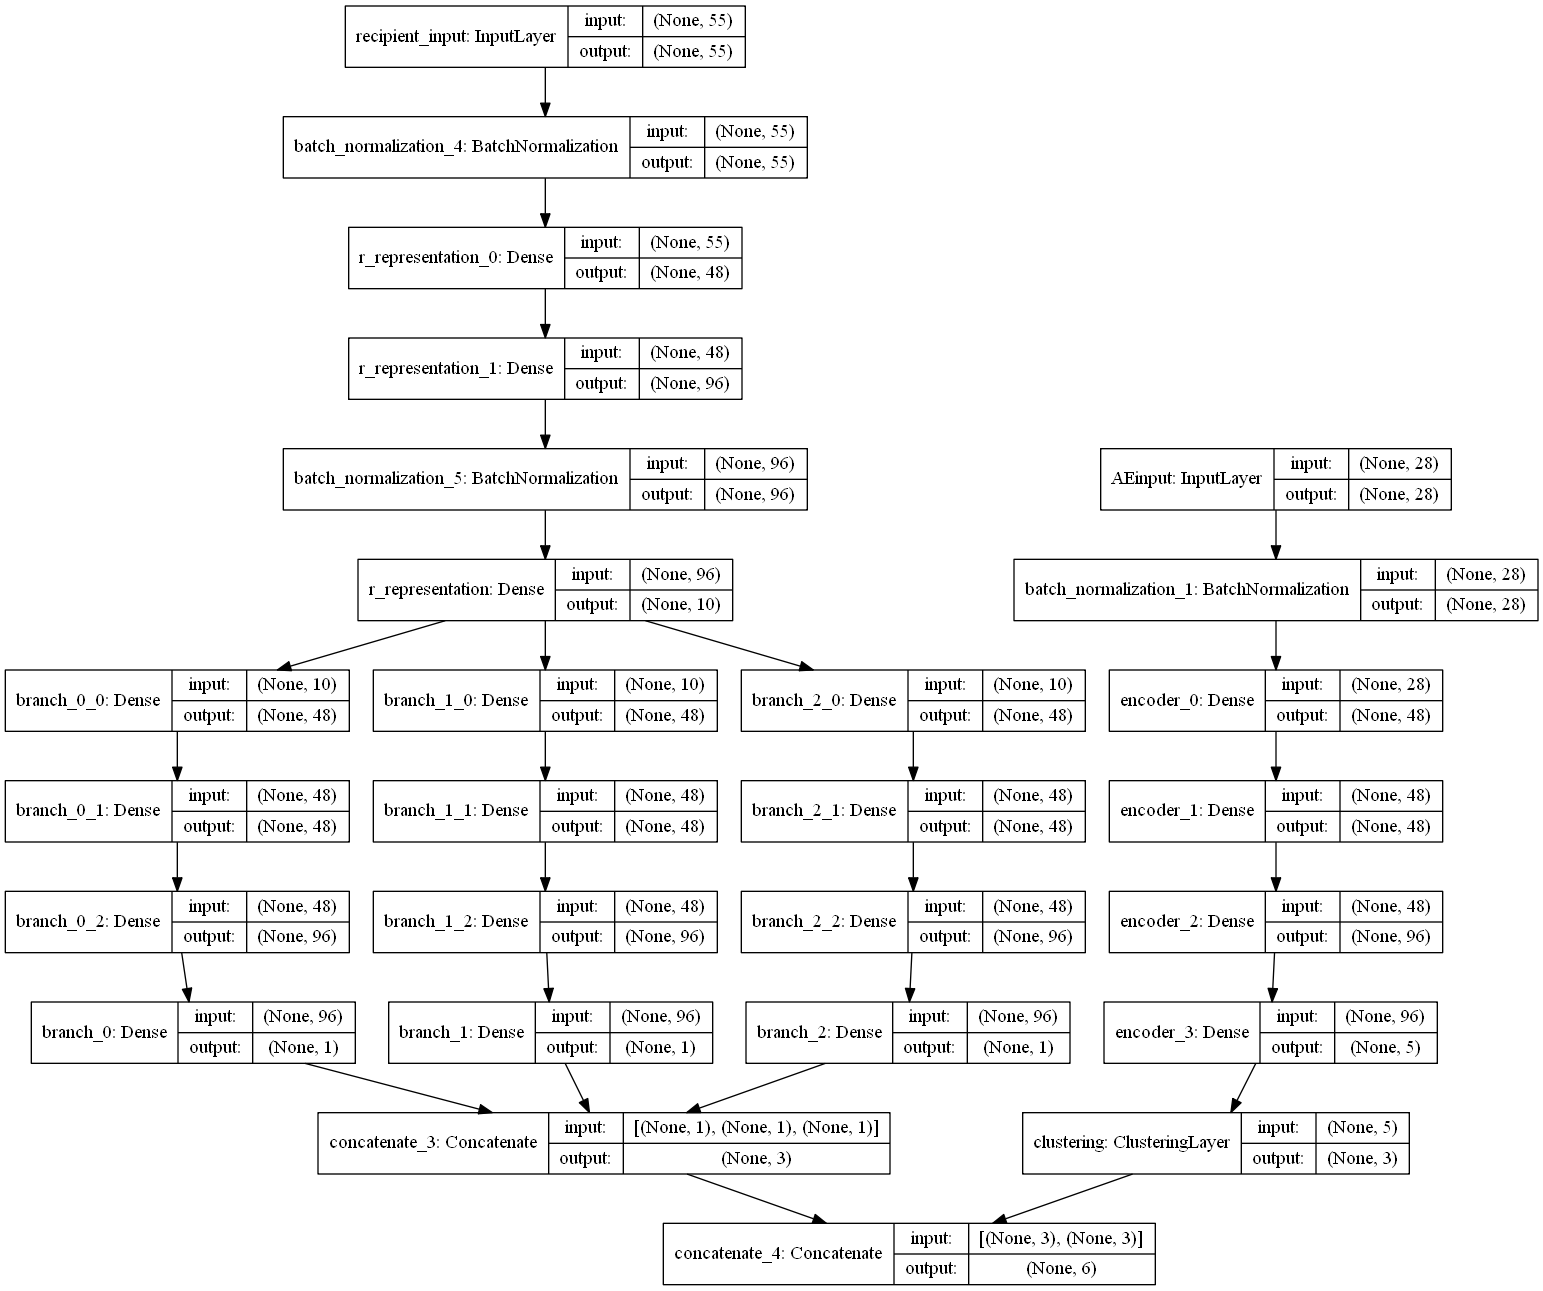

In [14]:
BM, TBM = BranchModel(rdims, bdims)
plot_model(TBM, show_shapes=True, show_layer_names=True, to_file='TBM.png')
Image('TBM.png')

In [13]:
alpha = 1

def TBMloss(y_true, y_pred):
    ys = y_pred[:, 0:n_clusters]
    tpred = y_pred[:, n_clusters:]
    
    y = y_true[:, 0]
    p = y_true[:, 1:]
    
    ypred = K.sum(ys*tpred, axis=-1)
    yloss = K.square(ypred-y)
    tloss = KLD(p, tpred)
    
    return yloss + alpha*tloss

## train branched model

In [14]:
def train_branch():
    BM, TBM = BranchModel(rdims, bdims)
    TBM.compile(optimizer='Adam', loss=TBMloss)
    checkpointer = ModelCheckpoint(filepath='./model/BranchCheckpoint', verbose=1, save_best_only=True)
    DEC.load_weights(model_path + '/DECweights')

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for ite in range(10):
        q = DEC.predict(D_train, verbose=0)
        p = target_distribution(q)
    
        q_val = DEC.predict(D_test, verbose=0)
        p_val = target_distribution(q_val)
    
        target = np.hstack([y_train.reshape(-1, 1), p])
        target_val = np.hstack([y_test.reshape(-1, 1), p_val])
    
        hist = TBM.fit([R_train, D_train], target, validation_data=([R_test, D_test], target_val), batch_size=256, epochs=5, callbacks=[checkpointer])
        history['loss'] += hist.history['loss']
        history['val_loss'] += hist.history['val_loss']
        
    return BM, TBM, DEC, history

#TBM.save_weights(model_path + '/TBMweights')

### test

In [15]:
e_losses = []
a_losses = []
vs = []

if fully_observed:
    full_losses = []
    weighted_full_losses = []
    accs = []
    
hists = {}
hists['val_loss_hist'] = []
hists['loss_hist'] = []

for i in range(20):
    BM, TBM, DEC, hist = train_branch()
    TBM.load_weights('./model/BranchCheckpoint')
    hists['val_loss_hist'].append(hist['val_loss'])
    hists['loss_hist'].append(hist['loss'])
    
    test_Y_pred = BM.predict(R_test)
    vs.append(np.mean(np.var(test_Y_pred, axis=0)))
    test_T_pred = DEC.predict(D_test)

    # expected loss
    e_test_y_pred = np.sum(np.multiply(test_Y_pred, test_T_pred), axis=-1)
    e_test_loss = np.mean(np.square(e_test_y_pred - y_test))

    #absolute loss

    a_test_clus = np.argmax(test_T_pred, axis=-1)
    a_test_y_pred = test_Y_pred[np.arange(a_test_clus.size), a_test_clus]
    a_test_loss = np.mean(np.square(a_test_y_pred - y_test))

    e_losses.append(e_test_loss)
    a_losses.append(a_test_loss)
    
    if fully_observed:
        w = np.eye(n_clusters)[a_test_clus]
        w = np.sum(w, axis=0) / len(a_test_clus)
        diff = np.square(test_Y_pred - y_full_test)
        weighted_full_loss = np.mean(np.sum(diff*w, axis=-1))
        weighted_full_losses.append(weighted_full_loss)
        full_losses.append(np.mean(diff))
        accs.append(AoDT(test_Y_pred, y_full_test))




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 1s 289us/step - loss: 2435024.7657 - val_loss: 2563032.3565

Epoch 00001: val_loss improved from inf to 2563032.35650, saving model to ./model/BranchCheckpoint
Epoch 2/5
4014/4014 [==============================] - 0s 46us/step - loss: 2433473.2059 - val_loss: 2556616.2971

Epoch 00002: val_loss improved from 2563032.35650 to 2556616.29709, saving model to ./model/BranchCheckpoint
Epoch 3/5
4014/4014 [==============================] - 0s 41us/step - loss: 2415595.8713 - val_loss: 2484813.3655

Epoch 00003: val_loss improved from 2556616.29709 to 2484813.36547, saving model to ./model/BranchCheckpoint
Epoch 4/5
4014/4014 [==============================] - 0s 44us/step - loss: 2278783.3834 - val_loss: 2074909.2152

Epoch 00004: val_loss improved from 2484813.36547 to 2074909.21525, saving mo

4014/4014 [==============================] - 0s 40us/step - loss: 296705.0026 - val_loss: 575997.3386

Epoch 00005: val_loss did not improve from 507043.53433
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 40us/step - loss: 290418.7946 - val_loss: 563338.5000

Epoch 00001: val_loss did not improve from 507043.53433
Epoch 2/5
4014/4014 [==============================] - 0s 41us/step - loss: 287107.8745 - val_loss: 569637.9361

Epoch 00002: val_loss did not improve from 507043.53433
Epoch 3/5
4014/4014 [==============================] - 0s 41us/step - loss: 288295.7810 - val_loss: 598315.1578

Epoch 00003: val_loss did not improve from 507043.53433
Epoch 4/5
4014/4014 [==============================] - 0s 40us/step - loss: 275342.2550 - val_loss: 579512.6373

Epoch 00004: val_loss did not improve from 507043.53433
Epoch 5/5
4014/4014 [==============================] - 0s 42us/step - loss: 276944.1606 - val_loss: 599900.4156

Epoch


Epoch 00004: val_loss improved from 553371.50504 to 551329.21272, saving model to ./model/BranchCheckpoint
Epoch 5/5
4014/4014 [==============================] - 0s 44us/step - loss: 392743.4578 - val_loss: 566943.4633

Epoch 00005: val_loss did not improve from 551329.21272
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 41us/step - loss: 390629.8081 - val_loss: 570798.7385

Epoch 00001: val_loss did not improve from 551329.21272
Epoch 2/5
4014/4014 [==============================] - 0s 44us/step - loss: 383399.2467 - val_loss: 562777.5849

Epoch 00002: val_loss did not improve from 551329.21272
Epoch 3/5
4014/4014 [==============================] - 0s 43us/step - loss: 365923.7790 - val_loss: 562531.3299

Epoch 00003: val_loss did not improve from 551329.21272
Epoch 4/5
4014/4014 [==============================] - 0s 43us/step - loss: 363581.1585 - val_loss: 586463.0645

Epoch 00004: val_loss did not improve from 551329.21272


Epoch 3/5
4014/4014 [==============================] - 0s 47us/step - loss: 2414639.4305 - val_loss: 2479725.2085

Epoch 00003: val_loss improved from 2555796.62108 to 2479725.20852, saving model to ./model/BranchCheckpoint
Epoch 4/5
4014/4014 [==============================] - 0s 47us/step - loss: 2277079.4418 - val_loss: 2073811.4036

Epoch 00004: val_loss improved from 2479725.20852 to 2073811.40359, saving model to ./model/BranchCheckpoint
Epoch 5/5
4014/4014 [==============================] - 0s 47us/step - loss: 1678098.0923 - val_loss: 1052711.7225

Epoch 00005: val_loss improved from 2073811.40359 to 1052711.72253, saving model to ./model/BranchCheckpoint
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 44us/step - loss: 736822.5062 - val_loss: 758251.5541

Epoch 00001: val_loss improved from 1052711.72253 to 758251.55409, saving model to ./model/BranchCheckpoint
Epoch 2/5
4014/4014 [==============================] - 0s 43

4014/4014 [==============================] - 0s 42us/step - loss: 215328.9974 - val_loss: 636705.5418

Epoch 00001: val_loss did not improve from 560229.99916
Epoch 2/5
4014/4014 [==============================] - 0s 44us/step - loss: 220761.2100 - val_loss: 667802.0485

Epoch 00002: val_loss did not improve from 560229.99916
Epoch 3/5
4014/4014 [==============================] - 0s 44us/step - loss: 209209.4801 - val_loss: 666048.7166

Epoch 00003: val_loss did not improve from 560229.99916
Epoch 4/5
4014/4014 [==============================] - 0s 43us/step - loss: 206638.1822 - val_loss: 671071.2901

Epoch 00004: val_loss did not improve from 560229.99916
Epoch 5/5
4014/4014 [==============================] - 0s 41us/step - loss: 202686.7950 - val_loss: 679687.8980

Epoch 00005: val_loss did not improve from 560229.99916
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 2s 614us/step - loss: 2434945.9682 - val_loss: 2562761.3789

Ep


Epoch 00002: val_loss did not improve from 524391.56110
Epoch 3/5
4014/4014 [==============================] - 0s 44us/step - loss: 234583.2003 - val_loss: 602610.6533

Epoch 00003: val_loss did not improve from 524391.56110
Epoch 4/5
4014/4014 [==============================] - 0s 41us/step - loss: 230241.2355 - val_loss: 628849.4624

Epoch 00004: val_loss did not improve from 524391.56110
Epoch 5/5
4014/4014 [==============================] - 0s 44us/step - loss: 223011.7811 - val_loss: 644395.4717

Epoch 00005: val_loss did not improve from 524391.56110
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 41us/step - loss: 229710.4426 - val_loss: 645986.1508

Epoch 00001: val_loss did not improve from 524391.56110
Epoch 2/5
4014/4014 [==============================] - 0s 43us/step - loss: 225583.8028 - val_loss: 673262.8360

Epoch 00002: val_loss did not improve from 524391.56110
Epoch 3/5
4014/4014 [==============================


Epoch 00005: val_loss did not improve from 533149.01990
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 43us/step - loss: 282410.1604 - val_loss: 607171.9540

Epoch 00001: val_loss did not improve from 533149.01990
Epoch 2/5
4014/4014 [==============================] - 0s 44us/step - loss: 281576.9151 - val_loss: 613924.8302

Epoch 00002: val_loss did not improve from 533149.01990
Epoch 3/5
4014/4014 [==============================] - 0s 45us/step - loss: 277207.6930 - val_loss: 605687.4246

Epoch 00003: val_loss did not improve from 533149.01990
Epoch 4/5
4014/4014 [==============================] - 0s 47us/step - loss: 275482.5098 - val_loss: 610466.6564

Epoch 00004: val_loss did not improve from 533149.01990
Epoch 5/5
4014/4014 [==============================] - 0s 45us/step - loss: 261612.1078 - val_loss: 631401.3739

Epoch 00005: val_loss did not improve from 533149.01990
Train on 4014 samples, validate on 446 samples
Epoc

Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 45us/step - loss: 371501.9039 - val_loss: 573394.0698

Epoch 00001: val_loss did not improve from 568881.18414
Epoch 2/5
4014/4014 [==============================] - 0s 45us/step - loss: 361372.4016 - val_loss: 568536.0049

Epoch 00002: val_loss improved from 568881.18414 to 568536.00490, saving model to ./model/BranchCheckpoint
Epoch 3/5
4014/4014 [==============================] - 0s 44us/step - loss: 359814.9956 - val_loss: 560890.4271

Epoch 00003: val_loss improved from 568536.00490 to 560890.42713, saving model to ./model/BranchCheckpoint
Epoch 4/5
4014/4014 [==============================] - 0s 45us/step - loss: 341971.3522 - val_loss: 564529.7164

Epoch 00004: val_loss did not improve from 560890.42713
Epoch 5/5
4014/4014 [==============================] - 0s 48us/step - loss: 333977.2098 - val_loss: 545561.2007

Epoch 00005: val_loss improved from 560890.42713 to 545561.200

Epoch 4/5
4014/4014 [==============================] - 0s 47us/step - loss: 458535.9750 - val_loss: 604769.5362

Epoch 00004: val_loss improved from 651202.34501 to 604769.53615, saving model to ./model/BranchCheckpoint
Epoch 5/5
4014/4014 [==============================] - 0s 51us/step - loss: 430812.6135 - val_loss: 551941.1281

Epoch 00005: val_loss improved from 604769.53615 to 551941.12808, saving model to ./model/BranchCheckpoint
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 47us/step - loss: 417860.8067 - val_loss: 543154.5900

Epoch 00001: val_loss improved from 551941.12808 to 543154.58997, saving model to ./model/BranchCheckpoint
Epoch 2/5
4014/4014 [==============================] - 0s 49us/step - loss: 404840.7497 - val_loss: 527996.9198

Epoch 00002: val_loss improved from 543154.58997 to 527996.91984, saving model to ./model/BranchCheckpoint
Epoch 3/5
4014/4014 [==============================] - 0s 48us/step - los

Epoch 3/5
4014/4014 [==============================] - 0s 52us/step - loss: 2409395.1866 - val_loss: 2461692.6087

Epoch 00003: val_loss improved from 2554494.26233 to 2461692.60874, saving model to ./model/BranchCheckpoint
Epoch 4/5
4014/4014 [==============================] - 0s 51us/step - loss: 2236314.4356 - val_loss: 1941228.2096

Epoch 00004: val_loss improved from 2461692.60874 to 1941228.20964, saving model to ./model/BranchCheckpoint
Epoch 5/5
4014/4014 [==============================] - 0s 50us/step - loss: 1531118.8597 - val_loss: 877966.3203

Epoch 00005: val_loss improved from 1941228.20964 to 877966.32035, saving model to ./model/BranchCheckpoint
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 48us/step - loss: 699786.2897 - val_loss: 688216.8237

Epoch 00001: val_loss improved from 877966.32035 to 688216.82371, saving model to ./model/BranchCheckpoint
Epoch 2/5
4014/4014 [==============================] - 0s 50us/

4014/4014 [==============================] - 0s 47us/step - loss: 251740.8788 - val_loss: 666319.4737

Epoch 00004: val_loss did not improve from 558843.45516
Epoch 5/5
4014/4014 [==============================] - 0s 48us/step - loss: 244988.7086 - val_loss: 676152.5325

Epoch 00005: val_loss did not improve from 558843.45516
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 45us/step - loss: 240672.1795 - val_loss: 684937.0740

Epoch 00001: val_loss did not improve from 558843.45516
Epoch 2/5
4014/4014 [==============================] - 0s 47us/step - loss: 245910.2828 - val_loss: 730904.3885

Epoch 00002: val_loss did not improve from 558843.45516
Epoch 3/5
4014/4014 [==============================] - 0s 51us/step - loss: 237204.1347 - val_loss: 665024.9686

Epoch 00003: val_loss did not improve from 558843.45516
Epoch 4/5
4014/4014 [==============================] - 0s 49us/step - loss: 237294.6387 - val_loss: 671852.9627

Epoch


Epoch 00002: val_loss did not improve from 528485.60902
Epoch 3/5
4014/4014 [==============================] - 0s 48us/step - loss: 265247.3124 - val_loss: 583449.0703

Epoch 00003: val_loss did not improve from 528485.60902
Epoch 4/5
4014/4014 [==============================] - 0s 47us/step - loss: 256120.5539 - val_loss: 589721.5670

Epoch 00004: val_loss did not improve from 528485.60902
Epoch 5/5
4014/4014 [==============================] - 0s 47us/step - loss: 254601.7411 - val_loss: 589742.9198

Epoch 00005: val_loss did not improve from 528485.60902
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 47us/step - loss: 245407.5675 - val_loss: 601472.7660

Epoch 00001: val_loss did not improve from 528485.60902
Epoch 2/5
4014/4014 [==============================] - 0s 48us/step - loss: 247085.1923 - val_loss: 594658.6099

Epoch 00002: val_loss did not improve from 528485.60902
Epoch 3/5
4014/4014 [==============================

4014/4014 [==============================] - 0s 47us/step - loss: 317243.5557 - val_loss: 645100.5698

Epoch 00001: val_loss did not improve from 537093.48739
Epoch 2/5
4014/4014 [==============================] - 0s 47us/step - loss: 305628.9647 - val_loss: 622346.8394

Epoch 00002: val_loss did not improve from 537093.48739
Epoch 3/5
4014/4014 [==============================] - 0s 47us/step - loss: 296208.8835 - val_loss: 599882.6883

Epoch 00003: val_loss did not improve from 537093.48739
Epoch 4/5
4014/4014 [==============================] - 0s 47us/step - loss: 290081.2091 - val_loss: 594981.1455

Epoch 00004: val_loss did not improve from 537093.48739
Epoch 5/5
4014/4014 [==============================] - 0s 49us/step - loss: 290147.7373 - val_loss: 617513.2808

Epoch 00005: val_loss did not improve from 537093.48739
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 46us/step - loss: 284667.1645 - val_loss: 613606.7822

Epoch

Epoch 2/5
4014/4014 [==============================] - 0s 50us/step - loss: 415951.0912 - val_loss: 558187.4672

Epoch 00002: val_loss did not improve from 556951.14770
Epoch 3/5
4014/4014 [==============================] - 0s 53us/step - loss: 411766.0193 - val_loss: 546496.4773

Epoch 00003: val_loss improved from 556951.14770 to 546496.47730, saving model to ./model/BranchCheckpoint
Epoch 4/5
4014/4014 [==============================] - 0s 48us/step - loss: 393286.7308 - val_loss: 555381.0746

Epoch 00004: val_loss did not improve from 546496.47730
Epoch 5/5
4014/4014 [==============================] - 0s 50us/step - loss: 386680.6656 - val_loss: 556675.5384

Epoch 00005: val_loss did not improve from 546496.47730
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 49us/step - loss: 384819.1147 - val_loss: 560339.7710

Epoch 00001: val_loss did not improve from 546496.47730
Epoch 2/5
4014/4014 [==============================] - 0s

4014/4014 [==============================] - 0s 54us/step - loss: 207729.7554 - val_loss: 714988.2029

Epoch 00003: val_loss did not improve from 573046.27803
Epoch 4/5
4014/4014 [==============================] - 0s 55us/step - loss: 214228.8100 - val_loss: 715808.3307

Epoch 00004: val_loss did not improve from 573046.27803
Epoch 5/5
4014/4014 [==============================] - 0s 55us/step - loss: 205861.1191 - val_loss: 691755.3304

Epoch 00005: val_loss did not improve from 573046.27803
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 6s 2ms/step - loss: 2434999.3155 - val_loss: 2562930.9103

Epoch 00001: val_loss improved from inf to 2562930.91031, saving model to ./model/BranchCheckpoint
Epoch 2/5
4014/4014 [==============================] - 0s 59us/step - loss: 2432978.3940 - val_loss: 2554903.5527

Epoch 00002: val_loss improved from 2562930.91031 to 2554903.55269, saving model to ./model/BranchCheckpoint
Epoch 3/5
4014/4014

Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 54us/step - loss: 208865.0668 - val_loss: 630644.8083

Epoch 00001: val_loss did not improve from 532108.66172
Epoch 2/5
4014/4014 [==============================] - 0s 54us/step - loss: 218221.1509 - val_loss: 649818.7197

Epoch 00002: val_loss did not improve from 532108.66172
Epoch 3/5
4014/4014 [==============================] - 0s 54us/step - loss: 202022.7417 - val_loss: 650026.3027

Epoch 00003: val_loss did not improve from 532108.66172
Epoch 4/5
4014/4014 [==============================] - 0s 54us/step - loss: 209850.5492 - val_loss: 636279.5280

Epoch 00004: val_loss did not improve from 532108.66172
Epoch 5/5
4014/4014 [==============================] - 0s 54us/step - loss: 207654.9912 - val_loss: 636956.7814

Epoch 00005: val_loss did not improve from 532108.66172
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 52u


Epoch 00003: val_loss did not improve from 538188.45235
Epoch 4/5
4014/4014 [==============================] - 0s 56us/step - loss: 243358.2910 - val_loss: 676908.9577

Epoch 00004: val_loss did not improve from 538188.45235
Epoch 5/5
4014/4014 [==============================] - 0s 54us/step - loss: 229325.7176 - val_loss: 685697.6054

Epoch 00005: val_loss did not improve from 538188.45235
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 54us/step - loss: 232586.4943 - val_loss: 688288.2643

Epoch 00001: val_loss did not improve from 538188.45235
Epoch 2/5
4014/4014 [==============================] - 0s 55us/step - loss: 230229.1041 - val_loss: 695292.0950

Epoch 00002: val_loss did not improve from 538188.45235
Epoch 3/5
4014/4014 [==============================] - 0s 57us/step - loss: 234771.6062 - val_loss: 675866.7354

Epoch 00003: val_loss did not improve from 538188.45235
Epoch 4/5
4014/4014 [==============================

In [16]:
# pre = list(np.array(vs).astype('float'))
# if os.path.isfile('./model/sccn_vs.json'):
#     with open('./model/sccn_vs.json', 'r', encoding='utf8') as f:
#         pre += json.loads(f.read())

# with open('./model/sccn_vs.json', 'w+', encoding='utf8') as f:
#     f.write(json.dumps(pre, ensure_ascii=False))

    
# print(np.mean(np.sort(pre)[:10]))

pre = list(np.array(accs).astype('float'))
if os.path.isfile('./model/sccn_aodt.json'):
    with open('./model/sccn_aodt.json', 'r', encoding='utf8') as f:
        pre += json.loads(f.read())

with open('./model/sccn_aodt.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(pre, ensure_ascii=False))

    
print(np.mean(np.sort(pre)[-20:]))
print(pre)

0.6736547085201792
[0.6278026905829597, 0.5605381165919282, 0.6278026905829597, 0.6278026905829597, 0.6278026905829597, 0.6278026905829597, 0.6860986547085202, 0.5224215246636771, 0.6278026905829597, 0.6278026905829597, 0.6278026905829597, 0.5605381165919282, 0.6278026905829597, 0.6569506726457399, 0.6278026905829597, 0.6390134529147982, 0.6278026905829597, 0.6233183856502242, 0.6278026905829597, 0.6278026905829597, 0.6188340807174888, 0.6748878923766816, 0.6748878923766816, 0.6748878923766816, 0.6748878923766816, 0.6748878923766816, 0.6748878923766816, 0.6748878923766816, 0.5896860986547086, 0.6748878923766816, 0.6748878923766816, 0.6188340807174888, 0.6748878923766816, 0.6748878923766816, 0.6748878923766816, 0.6748878923766816, 0.6748878923766816, 0.6748878923766816, 0.6748878923766816, 0.6748878923766816, 0.6569506726457399, 0.6569506726457399, 0.6569506726457399, 0.6569506726457399, 0.6569506726457399, 0.5224215246636771, 0.6569506726457399, 0.6569506726457399, 0.6188340807174888, 

In [20]:
hists['e_losses'] = list(np.array(e_losses).astype('float'))
hists['a_losses'] = list(np.array(a_losses).astype('float'))

if fully_observed:
    hists['full_losses'] = list(np.array(full_losses).astype('float'))
    hists['weighted_full_losses'] = list(np.array(weighted_full_losses).astype('float')) 

if os.path.isfile('./model/branched_hist.json'):
    with open('./model/branched_hist.json', 'r', encoding='utf8') as f:
        pre_hists = json.loads(f.read())
    hists['e_losses'] += pre_hists['e_losses']
    hists['a_losses'] += pre_hists['a_losses']
    if fully_observed:
        hists['full_losses'] += pre_hists['full_losses']
        hists['weighted_full_losses'] += pre_hists['weighted_full_losses']
    hists['val_loss_hist'] += pre_hists['val_loss_hist']
    hists['loss_hist'] += pre_hists['loss_hist']
    
with open('./model/branched_hist.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(hists, ensure_ascii=False))

In [21]:
with open('./model/branched_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())
    
print(len(hists['e_losses']))

10


In [22]:
with open('./model/branched_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())

e_losses = hists['e_losses']
a_losses = hists['a_losses']
print(e_losses)

tope_losses = np.sort(e_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(tope_losses)), "+-", np.log(np.sqrt(np.var(tope_losses))))
topa_losses = np.sort(a_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(topa_losses)), "+-", np.log(np.sqrt(np.var(topa_losses))))

if fully_observed:
    full_losses = hists['full_losses']
    weighted_full_losses = hists['weighted_full_losses']
    topfull_losses = np.sort(full_losses)[:50]
    topweighted_full_losses = np.sort(weighted_full_losses)[:50]
    print('Base line model fully observed test loss: ', np.log(np.mean(topfull_losses)), "+-", np.log(np.sqrt(np.var(topfull_losses))))
    print('Base line model weighted full observed test loss: ', np.log(np.mean(topweighted_full_losses)), "+-", np.log(np.sqrt(np.var(topweighted_full_losses))))


[9256.6201171875, 241.4112091064453, 204.4826202392578, 202.56564331054688, 200.01846313476562, 437.026611328125, 330.5880126953125, 189.28077697753906, 298.53521728515625, 351.469482421875]
Base line model test loss:  7.065783985564149 +- 7.899618435787026
Base line model test loss:  11.450206454185954 +- 10.4381466207874
Base line model fully observed test loss:  14.167795163298775 +- 13.906620844114713
Base line model weighted full observed test loss:  14.516983570173789 +- 14.313330700135863


### plot joint DEC result

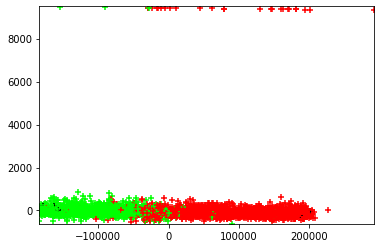

In [21]:
# BM, TBM, DEC, hist = train_branch()
D_clus = DEC.predict(D_train, verbose=0)
D_clus = D_clus.argmax(1)
plot_cluster(D_train, D_clus, n_clusters)

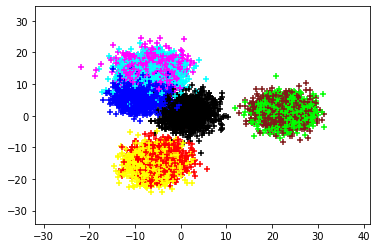

In [21]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
D_clus = kmeans.fit_predict(D_train)
plot_cluster(D_train, D_clus, n_clusters)

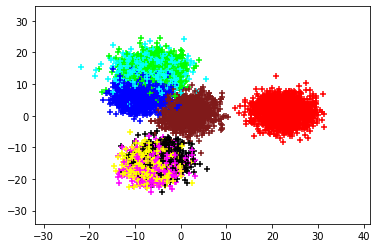

In [22]:
gm = GaussianMixture(n_components=n_clusters, covariance_type='diag', n_init=10)
gm.fit(D_train)
D_clus = gm.predict(D_train)
plot_cluster(D_train, D_clus, n_clusters)

In [83]:
idx = 4
print(BM.predict(R_train)[idx])
print(DEC.predict(D_train)[idx])
print(y_train[idx])

[   4.4637356 2015.91        20.254057 ]
[0.22717392 0.4868346  0.2859915 ]
997.10455


# Branched with representation loss

In [11]:
def BranchRModel(rdims, bdims):
    inp = Input(shape=(R_train.shape[-1], ), name='recipient_input')
    r = inp
    r = BatchNormalization()(r)
    for i in range(len(rdims)-1):
        r = Dense(rdims[i], activation='relu', kernel_initializer='normal', name='r_representation_%d' % i)(r)
    r = BatchNormalization()(r)
    r = Dense(rdims[-1], activation='relu', kernel_initializer='normal', name='r_representation')(r)
    
    ys = []
    for i in range(n_clusters):
        z = Dense(bdims[0], activation='relu', kernel_initializer='normal', name='branch_%d_0' % i)(r)
        for j in range(1, len(bdims)):
            z = Dense(bdims[j], activation='relu', kernel_initializer='normal', name='branch_%d_%d' % (i, j))(z)
        z = Dense(1, activation='relu', kernel_initializer='normal', name='branch_%d' % i)(z)
        ys.append(z)
        
    ys = Concatenate()(ys)
    out = Concatenate()([ys, r, DEC.output])
    
    return Model(inputs=inp, outputs=ys), Model(inputs=[inp, DEC.input], outputs=out)

In [58]:
alpha = 1
beta = 50000

def RMloss(y_true, y_pred):
    ys = y_pred[:, 0:n_clusters]
    r = y_pred[:, n_clusters:-n_clusters]
    tpred = y_pred[:, -n_clusters:]
    
    y = y_true[:, 0]
    p = y_true[:, 1:]
    
    ypred = K.sum(ys*tpred, axis=-1)
    yloss = K.square(ypred-y)
    tloss = KLD(p, tpred)
    
    tmean = K.mean(r, axis=0)
    tvar = K.var(r, axis=0)
    rloss = 0
    for i in range(n_clusters):
        w = K.reshape(p[:, i], shape=(-1, 1))
        weighted = r * w
        mean = K.mean(weighted, axis=0)
        var = K.var(weighted, axis=0)
        rloss += K.sum(K.square(mean-tmean)) + K.sum(K.square(var-tvar))
    
    return yloss + alpha*tloss + beta*rloss

In [59]:
def train_branch_r():
    BM, TBM = BranchRModel(rdims, bdims)
    TBM.compile(optimizer='Adam', loss=RMloss)
    checkpointer = ModelCheckpoint(filepath='./model/BranchRCheckpoint', verbose=1, save_best_only=True)

    DEC.load_weights(model_path + '/DECweights')

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for ite in range(10):
        q = DEC.predict(D_train, verbose=0)
        p = target_distribution(q)
    
        q_val = DEC.predict(D_test, verbose=0)
        p_val = target_distribution(q_val)
    
        target = np.hstack([y_train.reshape(-1, 1), p])
        target_val = np.hstack([y_test.reshape(-1, 1), p_val])
    
        hist = TBM.fit([R_train, D_train], target, validation_data=([R_test, D_test], target_val), batch_size=256, epochs=5, callbacks=[checkpointer])
        history['loss'] += hist.history['loss']
        history['val_loss'] += hist.history['val_loss']
    return BM, TBM, DEC, history
        
#TBM.save_weights(model_path + '/RTBMweights')

In [60]:
e_losses = []
a_losses = []

if fully_observed:
    full_losses = []
    weighted_full_losses = []

hists = {}
hists['val_loss_hist'] = []
hists['loss_hist'] = []

# betas = [0, 0.001, 0.1, 0.2, 0.5, 1, 10, 50, 100, 500] 

for i in range(1):
#     beta = betas[i]
      
    BM, TBM, DEC, hist = train_branch_r()
    TBM.load_weights('./model/BranchRCheckpoint')
    hists['val_loss_hist'].append(hist['val_loss'])
    hists['loss_hist'].append(hist['loss'])

    test_Y_pred = BM.predict(R_test)
    test_T_pred = DEC.predict(D_test)

    # expected loss
    e_test_y_pred = np.sum(np.multiply(test_Y_pred, test_T_pred), axis=-1)
    e_test_loss = np.mean(np.square(e_test_y_pred - y_test))

    #absolute loss

    a_test_clus = np.argmax(test_T_pred, axis=-1)
    a_test_y_pred = test_Y_pred[np.arange(a_test_clus.size), a_test_clus]
    a_test_loss = np.mean(np.square(a_test_y_pred - y_test))
    
    e_losses.append(e_test_loss)
    a_losses.append(a_test_loss)
    
    if fully_observed:
        w = np.eye(n_clusters)[a_test_clus]
        w = np.sum(w, axis=0) / len(a_test_clus)
        diff = np.square(test_Y_pred - y_full_test)
        weighted_full_loss = np.mean(np.sum(diff*w, axis=-1))
        weighted_full_losses.append(weighted_full_loss)
        full_losses.append(np.mean(diff))


Train on 9000 samples, validate on 1000 samples
Epoch 1/5
9000/9000 [==============================] - 4s 458us/step - loss: 284485.4784 - val_loss: 275224.7635

Epoch 00001: val_loss improved from inf to 275224.76350, saving model to ./model/BranchRCheckpoint
Epoch 2/5
9000/9000 [==============================] - 1s 70us/step - loss: 275614.5618 - val_loss: 260962.6880

Epoch 00002: val_loss improved from 275224.76350 to 260962.68800, saving model to ./model/BranchRCheckpoint
Epoch 3/5
9000/9000 [==============================] - 1s 61us/step - loss: 219582.0123 - val_loss: 160270.4122

Epoch 00003: val_loss improved from 260962.68800 to 160270.41225, saving model to ./model/BranchRCheckpoint
Epoch 4/5
9000/9000 [==============================] - 1s 62us/step - loss: 105561.2772 - val_loss: 92122.4326

Epoch 00004: val_loss improved from 160270.41225 to 92122.43256, saving model to ./model/BranchRCheckpoint
Epoch 5/5
9000/9000 [==============================] - 1s 64us/step - loss: 54

In [61]:
hists['e_losses'] = list(np.array(e_losses).astype('float'))
hists['a_losses'] = list(np.array(a_losses).astype('float'))

if fully_observed:
    hists['full_losses'] = list(np.array(full_losses).astype('float'))
    hists['weighted_full_losses'] = list(np.array(weighted_full_losses).astype('float')) 

if os.path.isfile('./model/branched_rep_hist.json'):
    with open('./model/branched_rep_hist.json', 'r', encoding='utf8') as f:
        pre_hists = json.loads(f.read())
    hists['e_losses'] += pre_hists['e_losses']
    hists['a_losses'] += pre_hists['a_losses']
    if fully_observed:
        hists['full_losses'] += pre_hists['full_losses']
        hists['weighted_full_losses'] += pre_hists['weighted_full_losses']
    hists['val_loss_hist'] += pre_hists['val_loss_hist']
    hists['loss_hist'] += pre_hists['loss_hist']
    
with open('./model/branched_rep_hist.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(hists, ensure_ascii=False))

In [62]:
with open('./model/branched_rep_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())
    
print(len(hists['e_losses']))

with open('./model/branched_rep_hist.json', 'r', encoding='utf8') as f:
    hists = json.loads(f.read())

e_losses = hists['e_losses']
a_losses = hists['a_losses']

tope_losses = np.sort(e_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(tope_losses)), "+-", np.log(np.sqrt(np.var(tope_losses))))
topa_losses = np.sort(a_losses)[:50]
print('Base line model test loss: ', np.log(np.mean(topa_losses)), "+-", np.log(np.sqrt(np.var(topa_losses))))

if fully_observed:
    full_losses = hists['full_losses']
    weighted_full_losses = hists['weighted_full_losses']
    topfull_losses = np.sort(full_losses)[:50]
    topweighted_full_losses = np.sort(weighted_full_losses)[:50]
    print('Base line model fully observed test loss: ', np.log(np.mean(topfull_losses)), "+-", np.log(np.sqrt(np.var(topfull_losses))))
    print('Base line model weighted full observed test loss: ', np.log(np.mean(topweighted_full_losses)), "+-", np.log(np.sqrt(np.var(topweighted_full_losses))))


8
Base line model test loss:  9.109251650460614 +- 9.074602694800053
Base line model test loss:  11.122967783326676 +- 11.190814187485264
Base line model fully observed test loss:  13.170921196875488 +- 12.862737094009367
Base line model weighted full observed test loss:  12.852039844042608 +- 12.04724168756531


In [ ]:
D_clus = DEC.predict(D_train, verbose=0)
D_clus = D_clus.argmax(1)
plot_cluster(D_train, D_clus, n_clusters)

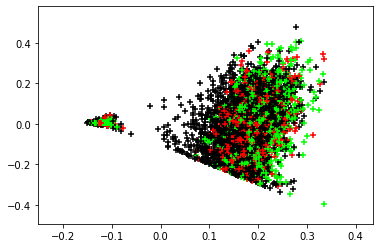

In [63]:
TBM.load_weights('./model/BranchRCheckpoint')
Phi = TBM.predict([R_train, D_train])[:, n_clusters:n_clusters+rdims[-1]]
plot_cluster(Phi, D_clus, n_clusters, scale=.1)

In [41]:
idx = 0
print(BM.predict(R_train)[idx])
print(DEC.predict(D_train)[idx])
print(y_train[idx])

[151.79057 154.33246 247.75026]
[0.24366952 0.1641036  0.5922269 ]
178.73041


# Alternate Training Branched

In [7]:
def CLUS(dims):
    inp = Input(shape=(dims[0],), name='CLSinput')
    x = BatchNormalization()(inp)
    for i in range(1, len(dims)):
        x = Dense(dims[i], activation='relu', kernel_initializer='normal', name='cls_%d' % i)(x)
        
    out = Dense(n_clusters, activation='softmax', kernel_initializer='normal', name='cls_out')(x)
    
    return Model(inputs=inp, outputs=out)

def BMCross(rdims, bdims):
    inp = Input(shape=(R_train.shape[-1], ), name='recipient_input')
    r = inp
    r = BatchNormalization()(r)
    for i in range(len(rdims)-1):
        r = Dense(rdims[i], activation='relu', kernel_initializer='normal', name='r_representation_%d' % i)(r)
    r = BatchNormalization()(r)
    r = Dense(rdims[-1], activation='relu', kernel_initializer='normal', name='r_representation')(r)
    
    ys = []
    for i in range(n_clusters):
        z = Dense(bdims[0], activation='relu', kernel_initializer='normal', name='branch_%d_0' % i)(r)
        for j in range(1, len(bdims)):
            z = Dense(bdims[j], activation='relu', kernel_initializer='normal', name='branch_%d_%d' % (i, j))(z)
        z = Dense(1, activation='relu', kernel_initializer='normal', name='branch_%d' % i)(z)
        ys.append(z)
        
    ys = Concatenate()(ys)
    out = Concatenate()([ys, r])
    
    return Model(inputs=inp, outputs=ys), Model(inputs=inp, outputs=out)


# plot_model(RBM, show_shapes=True, to_file='BMC.png')
# Image('BMC.png')
# plot_model(CLS, show_shapes=True, to_file='CLS.png')
# Image('CLS.png')

def RBMloss(y_true, y_pred):
    y = K.repeat_elements(K.reshape(y_true[:, 0], (-1, 1)), rep=n_clusters, axis=1)
    t = y_true[:, 1:n_clusters+1]
    
    ypred = y_pred[:, :n_clusters]
    r = y_pred[:, n_clusters:]
    
    yf = ypred * t
    y = y * t
    lossf = K.flatten(K.sum(K.square(y - yf), axis=1))
    
    tmean = K.mean(r, axis=0)
    tvar = K.mean(r, axis=0)
    lossr = 0
    for i in range(n_clusters):
        mask = t[:, i]
        masked = tf.boolean_mask(r, mask)
        mean = K.mean(masked, axis=0)
        var = K.var(masked, axis=0)
        mean = tf.where(tf.is_nan(mean), tf.zeros_like(mean), mean)
        var = tf.where(tf.is_nan(var), tf.zeros_like(var), var)
        
        lossr += K.sum(K.square(mean-tmean)) + K.sum(K.square(var-tvar))
    
    return lossf + lossr

In [8]:
def train_branch_cross():
    BM, RBM = BMCross(rdims, bdims)
    RBM.compile(optimizer='Adam', loss=RBMloss)
    
    CLS = CLUS(cdims)
    CLS.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    ## initialize clustering using kmeans
    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    D_clus = kmeans.fit_predict(D_train)
    D_clus = np.eye(n_clusters)[D_clus]

    D_clus_val = kmeans.predict(D_test)
    D_clus_val = np.eye(n_clusters)[D_clus_val]

    for i in range(5):
        checkpointer_c = ModelCheckpoint(filepath='./model/CLSCheckpoint', verbose=1, save_best_only=True)
        checkpointer = ModelCheckpoint(filepath='./model/AlterCheckpoint', verbose=1, save_best_only=True)
        
        CLS.fit(D_train, D_clus, validation_data=(D_test, D_clus_val), batch_size=256, epochs=20, callbacks=[checkpointer_c])
        CLS.load_weights('./model/CLSCheckpoint')
        
        D_clus = CLS.predict(D_train, verbose=0)
        D_clus = np.argmax(D_clus, axis=1)
        D_clus = np.eye(n_clusters)[D_clus]
    
        D_clus_val = CLS.predict(D_test, verbose=0)
        D_clus_val = np.argmax(D_clus_val, axis=1)
        D_clus_val = np.eye(n_clusters)[D_clus_val]
    
        
        target = np.hstack([y_train.reshape(-1, 1), D_clus])
        target_val = np.hstack([y_test.reshape(-1, 1), D_clus_val])
        
        RBM.fit(R_train, target, validation_data=(R_test, target_val), batch_size=256, epochs=5, callbacks=[checkpointer])
        RBM.load_weights('./model/AlterCheckpoint')
        y_pred = BM.predict(R_train, verbose=0)
        diff = np.square(y_pred - y_train.reshape(-1, 1))
        D_clus = np.argmin(diff, axis=1)
        D_clus = np.eye(n_clusters)[D_clus]
    
        y_pred_val = BM.predict(R_test, verbose=0)
        diff_val = np.square(y_pred_val - y_test.reshape(-1, 1))
        D_clus_val = np.argmin(diff_val, axis=1)
        D_clus_val = np.eye(n_clusters)[D_clus_val]
    
    return BM, RBM, CLS
    

### test

In [9]:
e_losses = []
a_losses = []
if fully_observed:
    full_losses = []
    weighted_full_losses = []
    
for i in range(1):
    BM, RBM, CLS = train_branch_cross()
    RBM.load_weights('./model/AlterCheckpoint')
    CLS.load_weights('./model/CLSCheckpoint')

    test_Y_pred = BM.predict(R_test)
    test_T_pred = CLS.predict(D_test)

    # expected loss
    e_test_y_pred = np.sum(np.multiply(test_Y_pred, test_T_pred), axis=-1)
    e_test_loss = np.mean(np.square(e_test_y_pred - y_test))

    #absolute loss

    a_test_clus = np.argmax(test_T_pred, axis=-1)
    a_test_y_pred = test_Y_pred[np.arange(a_test_clus.size), a_test_clus]
    a_test_loss = np.mean(np.square(a_test_y_pred - y_test))

    e_losses.append(e_test_loss)
    a_losses.append(a_test_loss)
    
    if fully_observed:
        w = np.eye(n_clusters)[a_test_clus]
        w = np.sum(w, axis=0) / len(a_test_clus)
        diff = np.square(test_Y_pred - y_full_test)
        weighted_full_loss = np.mean(np.sum(diff*w, axis=-1))
        weighted_full_losses.append(weighted_full_loss)
        full_losses.append(np.mean(diff))







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Train on 9000 samples, validate on 1000 samples
Epoch 1/20





9000/9000 [==============================] - 2s 226us/step - loss: 1.1366 - acc: 0.9071 - val_loss: 0.3026 - val_acc: 0.9990
Epoch 2/20
9000/9000 [==============================] - 0s 16us/step - loss: 0.0676 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 3/20
9000/9000 [==============================] - 0s 14us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 4/20
9000/9000 [==============================] - 0s 14us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 5/20
9000/9000 [==============================] - 0s 15us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 6/20
9000/9000 [==============================] - 0s 15us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 7/20
9000/9000 [===========

9000/9000 [==============================] - 0s 16us/step - loss: 0.7576 - acc: 0.6181 - val_loss: 0.9531 - val_acc: 0.4440
Epoch 12/20
9000/9000 [==============================] - 0s 15us/step - loss: 0.7540 - acc: 0.6242 - val_loss: 0.9775 - val_acc: 0.4510
Epoch 13/20
9000/9000 [==============================] - 0s 16us/step - loss: 0.7475 - acc: 0.6276 - val_loss: 0.9566 - val_acc: 0.4510
Epoch 14/20
9000/9000 [==============================] - 0s 16us/step - loss: 0.7411 - acc: 0.6322 - val_loss: 0.9610 - val_acc: 0.4560
Epoch 15/20
9000/9000 [==============================] - 0s 16us/step - loss: 0.7369 - acc: 0.6353 - val_loss: 0.9794 - val_acc: 0.4450
Epoch 16/20
9000/9000 [==============================] - 0s 15us/step - loss: 0.7291 - acc: 0.6452 - val_loss: 0.9819 - val_acc: 0.4540
Epoch 17/20
9000/9000 [==============================] - 0s 15us/step - loss: 0.7272 - acc: 0.6399 - val_loss: 0.9971 - val_acc: 0.4560
Epoch 18/20
9000/9000 [==============================] - 0s 

expected loss:  9.320585
absolute loss:  9.464736


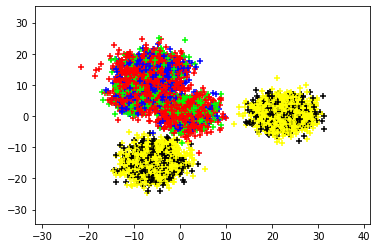

In [10]:
print('expected loss: ', np.log(np.mean(e_losses)))
print('absolute loss: ', np.log(np.mean(a_losses)))
if fully_observed:
    print('full loss: ', np.mean(full_losses))
    print('weighted full loss: ', np.mean(weighted_full_losses))

D_clus = CLS.predict(D_train, verbose=0)
D_clus = D_clus.argmax(1)
plot_cluster(D_train, D_clus, n_clusters)